In [169]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np
import pandas as pd
import plotting

import data_higgs as dh

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version ",tf.__version__)
print("TF Keras version ",tf.keras.__version__)

from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from catboost import CatBoostClassifier, Pool

TensorFlow version  2.7.0
TF Keras version  2.7.0


In [5]:
# Split data
def split_xy(rawdata):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    data_x=rawdata.drop(['hlabel'], axis=1) # features only

    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    #data_x = (data_x - mu)/s

    # scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    data_x = (data_x - dmin)/(dmax-dmin)


    return data_x,data_y

In [15]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(SEED_VALUE)

# DECISION TREES

In [26]:
# Get the data ready for decision tres
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))
x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample

print("Shapes train:{} and test:{}".format(x_train.shape,x_test.shape))

#plot distributions
#plotting.plot_sig_bkg_from_np_arrays(x_train.to_numpy(),y_train.to_numpy(),data_fnames,logy=False)

# ready the data for Catboost
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())


# set fixed parameters
eval_metric = 'AUC'
task_type = 'CPU'

Loading /Users/tijanprijon/Code/mfpr/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
[0. 1.]
Shapes train:(360000, 18) and test:(40000, 18)


In [84]:
# train model with set parameters
from datetime import datetime
def set_parameters(max_depth, max_number_of_trees):
    """Depth and number of trees are the only hyperparameters that i will change"""
    bdt=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    )
    bdt.fit(
        pool_train,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test,
        # plot=True # works when called through Ipython/jupyter
    )
    return bdt

In [53]:
def AUC_score(y_val,y_score):
    return roc_auc_score(y_val,y_score)

def F1_score(y_val,y_score):
    y_score = [int(i > .5) for i in y_score] # Convert probabilities to binary
    return f1_score(y_val,y_score)

In [103]:
def parameters_impact():
    auc_max_depth = list()
    auc_max_number_of_trees = list()
    f1_max_depth = list()
    f1_max_number_of_trees = list()
    
    for max_depth in range(2,20,2):
        bdt = set_parameters(max_depth, 500)
        y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
        auc_max_depth.append(AUC_score(y_val,y_score))
        f1_max_depth.append(F1_score(y_val,y_score)) 
            
    for max_number_of_trees in range(50,500,10):
        bdt = set_parameters(6, max_number_of_trees)
        y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
        auc_max_number_of_trees.append(AUC_score(y_val,y_score))
        f1_max_number_of_trees.append(F1_score(y_val,y_score))
        
    return auc_max_depth, f1_max_depth, auc_max_number_of_trees, f1_max_number_of_trees

auc_max_depth, f1_max_depth, auc_max_number_of_trees, f1_max_number_of_trees = parameters_impact()

0:	test: 0.7142780	best: 0.7142780 (0)	total: 16.1ms	remaining: 32.1s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 34.6ms	remaining: 34.6s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 53.4ms	remaining: 35.5s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 71.4ms	remaining: 35.7s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 89.5ms	remaining: 35.7s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 109ms	remaining: 36.4s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 127ms	remaining: 36.2s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 145ms	remaining: 36.2s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 162ms	remaining: 35.8s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 180ms	remaining: 35.8s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 196ms	remaining: 35.5s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 215ms	remaining: 35.6s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 232ms	remaining: 35.5s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 251ms	remaining: 35.6s
14:	test: 0.7346298	be

125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.32s	remaining: 34.5s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.34s	remaining: 34.5s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.35s	remaining: 34.4s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.37s	remaining: 34.4s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.39s	remaining: 34.4s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.41s	remaining: 34.4s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.43s	remaining: 34.4s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.44s	remaining: 34.3s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.46s	remaining: 34.3s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.48s	remaining: 34.3s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.5s	remaining: 34.2s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.52s	remaining: 34.2s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.54s	remaining: 34.2s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.

239:	test: 0.7710947	best: 0.7710947 (239)	total: 4.41s	remaining: 32.3s
240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.43s	remaining: 32.3s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.45s	remaining: 32.3s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.47s	remaining: 32.3s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.49s	remaining: 32.3s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.5s	remaining: 32.3s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.52s	remaining: 32.2s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.54s	remaining: 32.2s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.56s	remaining: 32.2s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.58s	remaining: 32.2s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.59s	remaining: 32.1s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.61s	remaining: 32.1s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.63s	remaining: 32.1s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.

363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.7s	remaining: 30.1s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.72s	remaining: 30.1s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.74s	remaining: 30.1s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.75s	remaining: 30s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.77s	remaining: 30s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.79s	remaining: 30s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.8s	remaining: 30s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.82s	remaining: 30s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.84s	remaining: 29.9s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.85s	remaining: 29.9s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.87s	remaining: 29.9s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.89s	remaining: 29.9s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.91s	remaining: 29.8s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.93s	remaini

482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.75s	remaining: 27.5s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.77s	remaining: 27.5s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.78s	remaining: 27.4s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.8s	remaining: 27.4s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.82s	remaining: 27.4s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.83s	remaining: 27.4s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.85s	remaining: 27.3s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.87s	remaining: 27.3s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.88s	remaining: 27.3s
491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.9s	remaining: 27.3s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.92s	remaining: 27.3s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.94s	remaining: 27.2s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.95s	remaining: 27.2s
495:	test: 0.7859758	best: 0.7859758 (495)	total: 8.9

602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.8s	remaining: 25s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 10.8s	remaining: 25s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.8s	remaining: 25s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.8s	remaining: 25s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 10.9s	remaining: 24.9s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 10.9s	remaining: 24.9s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.9s	remaining: 24.9s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.9s	remaining: 24.9s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.9s	remaining: 24.9s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 11s	remaining: 24.8s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 11s	remaining: 24.8s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 11s	remaining: 24.8s
614:	test: 0.7898811	best: 0.7898811 (614)	total: 11s	remaining: 24.8s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 11s	remaining: 24

722:	test: 0.7925442	best: 0.7925442 (722)	total: 12.8s	remaining: 22.7s
723:	test: 0.7925558	best: 0.7925558 (723)	total: 12.9s	remaining: 22.7s
724:	test: 0.7925760	best: 0.7925760 (724)	total: 12.9s	remaining: 22.7s
725:	test: 0.7925912	best: 0.7925912 (725)	total: 12.9s	remaining: 22.6s
726:	test: 0.7926175	best: 0.7926175 (726)	total: 12.9s	remaining: 22.6s
727:	test: 0.7926527	best: 0.7926527 (727)	total: 12.9s	remaining: 22.6s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 13s	remaining: 22.6s
729:	test: 0.7926798	best: 0.7926798 (729)	total: 13s	remaining: 22.6s
730:	test: 0.7926964	best: 0.7926964 (730)	total: 13s	remaining: 22.6s
731:	test: 0.7927267	best: 0.7927267 (731)	total: 13s	remaining: 22.5s
732:	test: 0.7927491	best: 0.7927491 (732)	total: 13s	remaining: 22.5s
733:	test: 0.7927738	best: 0.7927738 (733)	total: 13s	remaining: 22.5s
734:	test: 0.7927862	best: 0.7927862 (734)	total: 13.1s	remaining: 22.5s
735:	test: 0.7928033	best: 0.7928033 (735)	total: 13.1s	remaini

842:	test: 0.7948481	best: 0.7948481 (842)	total: 14.9s	remaining: 20.5s
843:	test: 0.7948589	best: 0.7948589 (843)	total: 15s	remaining: 20.5s
844:	test: 0.7948722	best: 0.7948722 (844)	total: 15s	remaining: 20.5s
845:	test: 0.7948846	best: 0.7948846 (845)	total: 15s	remaining: 20.5s
846:	test: 0.7948923	best: 0.7948923 (846)	total: 15s	remaining: 20.4s
847:	test: 0.7949064	best: 0.7949064 (847)	total: 15s	remaining: 20.4s
848:	test: 0.7949272	best: 0.7949272 (848)	total: 15s	remaining: 20.4s
849:	test: 0.7949424	best: 0.7949424 (849)	total: 15.1s	remaining: 20.4s
850:	test: 0.7949633	best: 0.7949633 (850)	total: 15.1s	remaining: 20.4s
851:	test: 0.7949836	best: 0.7949836 (851)	total: 15.1s	remaining: 20.3s
852:	test: 0.7950194	best: 0.7950194 (852)	total: 15.1s	remaining: 20.3s
853:	test: 0.7950287	best: 0.7950287 (853)	total: 15.1s	remaining: 20.3s
854:	test: 0.7950455	best: 0.7950455 (854)	total: 15.1s	remaining: 20.3s
855:	test: 0.7950585	best: 0.7950585 (855)	total: 15.2s	remaini

964:	test: 0.7968325	best: 0.7968325 (964)	total: 17s	remaining: 18.2s
965:	test: 0.7968421	best: 0.7968421 (965)	total: 17s	remaining: 18.2s
966:	test: 0.7968489	best: 0.7968489 (966)	total: 17s	remaining: 18.2s
967:	test: 0.7968740	best: 0.7968740 (967)	total: 17.1s	remaining: 18.2s
968:	test: 0.7968851	best: 0.7968851 (968)	total: 17.1s	remaining: 18.2s
969:	test: 0.7969026	best: 0.7969026 (969)	total: 17.1s	remaining: 18.1s
970:	test: 0.7969189	best: 0.7969189 (970)	total: 17.1s	remaining: 18.1s
971:	test: 0.7969258	best: 0.7969258 (971)	total: 17.1s	remaining: 18.1s
972:	test: 0.7969480	best: 0.7969480 (972)	total: 17.1s	remaining: 18.1s
973:	test: 0.7969616	best: 0.7969616 (973)	total: 17.2s	remaining: 18.1s
974:	test: 0.7969659	best: 0.7969659 (974)	total: 17.2s	remaining: 18.1s
975:	test: 0.7969855	best: 0.7969855 (975)	total: 17.2s	remaining: 18s
976:	test: 0.7969940	best: 0.7969940 (976)	total: 17.2s	remaining: 18s
977:	test: 0.7970027	best: 0.7970027 (977)	total: 17.2s	remai

1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 18.9s	remaining: 16.2s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 18.9s	remaining: 16.2s
1077:	test: 0.7983398	best: 0.7983398 (1077)	total: 18.9s	remaining: 16.2s
1078:	test: 0.7983474	best: 0.7983474 (1078)	total: 18.9s	remaining: 16.2s
1079:	test: 0.7983603	best: 0.7983603 (1079)	total: 19s	remaining: 16.1s
1080:	test: 0.7983729	best: 0.7983729 (1080)	total: 19s	remaining: 16.1s
1081:	test: 0.7983845	best: 0.7983845 (1081)	total: 19s	remaining: 16.1s
1082:	test: 0.7983959	best: 0.7983959 (1082)	total: 19s	remaining: 16.1s
1083:	test: 0.7984084	best: 0.7984084 (1083)	total: 19s	remaining: 16.1s
1084:	test: 0.7984185	best: 0.7984185 (1084)	total: 19s	remaining: 16.1s
1085:	test: 0.7984338	best: 0.7984338 (1085)	total: 19s	remaining: 16s
1086:	test: 0.7984493	best: 0.7984493 (1086)	total: 19.1s	remaining: 16s
1087:	test: 0.7984773	best: 0.7984773 (1087)	total: 19.1s	remaining: 16s
1088:	test: 0.7984984	best: 0.7984984 (1088)	

1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 20.7s	remaining: 14.2s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 20.8s	remaining: 14.2s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 20.8s	remaining: 14.2s
1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 20.8s	remaining: 14.2s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 20.8s	remaining: 14.2s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 20.8s	remaining: 14.1s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 20.8s	remaining: 14.1s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 20.9s	remaining: 14.1s
1193:	test: 0.7997403	best: 0.7997403 (1193)	total: 20.9s	remaining: 14.1s
1194:	test: 0.7997559	best: 0.7997559 (1194)	total: 20.9s	remaining: 14.1s
1195:	test: 0.7997693	best: 0.7997693 (1195)	total: 20.9s	remaining: 14.1s
1196:	test: 0.7997829	best: 0.7997829 (1196)	total: 20.9s	remaining: 14s
1197:	test: 0.7997918	best: 0.7997918 (1197)	total: 21s	remaining: 14s
1198:	test: 0.7998013	best: 0.7

1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 22.8s	remaining: 12.1s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 22.8s	remaining: 12.1s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 22.8s	remaining: 12.1s
1308:	test: 0.8010177	best: 0.8010177 (1308)	total: 22.8s	remaining: 12.1s
1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 22.9s	remaining: 12s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 22.9s	remaining: 12s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 22.9s	remaining: 12s
1312:	test: 0.8010522	best: 0.8010522 (1312)	total: 22.9s	remaining: 12s
1313:	test: 0.8010605	best: 0.8010605 (1313)	total: 22.9s	remaining: 12s
1314:	test: 0.8010709	best: 0.8010709 (1314)	total: 22.9s	remaining: 12s
1315:	test: 0.8010775	best: 0.8010775 (1315)	total: 23s	remaining: 11.9s
1316:	test: 0.8010871	best: 0.8010871 (1316)	total: 23s	remaining: 11.9s
1317:	test: 0.8011015	best: 0.8011015 (1317)	total: 23s	remaining: 11.9s
1318:	test: 0.8011107	best: 0.8011107 (1318

1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 24.8s	remaining: 10s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 24.9s	remaining: 9.98s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 24.9s	remaining: 9.96s
1428:	test: 0.8021559	best: 0.8021559 (1428)	total: 24.9s	remaining: 9.95s
1429:	test: 0.8021646	best: 0.8021646 (1429)	total: 24.9s	remaining: 9.93s
1430:	test: 0.8021697	best: 0.8021697 (1430)	total: 24.9s	remaining: 9.91s
1431:	test: 0.8021731	best: 0.8021731 (1431)	total: 24.9s	remaining: 9.89s
1432:	test: 0.8021791	best: 0.8021791 (1432)	total: 25s	remaining: 9.88s
1433:	test: 0.8021957	best: 0.8021957 (1433)	total: 25s	remaining: 9.86s
1434:	test: 0.8022000	best: 0.8022000 (1434)	total: 25s	remaining: 9.84s
1435:	test: 0.8022068	best: 0.8022068 (1435)	total: 25s	remaining: 9.82s
1436:	test: 0.8022160	best: 0.8022160 (1436)	total: 25s	remaining: 9.81s
1437:	test: 0.8022362	best: 0.8022362 (1437)	total: 25.1s	remaining: 9.79s
1438:	test: 0.8022469	best: 0.8022469

1546:	test: 0.8032253	best: 0.8032253 (1546)	total: 26.9s	remaining: 7.88s
1547:	test: 0.8032338	best: 0.8032338 (1547)	total: 26.9s	remaining: 7.86s
1548:	test: 0.8032427	best: 0.8032427 (1548)	total: 26.9s	remaining: 7.85s
1549:	test: 0.8032478	best: 0.8032478 (1549)	total: 27s	remaining: 7.83s
1550:	test: 0.8032526	best: 0.8032526 (1550)	total: 27s	remaining: 7.81s
1551:	test: 0.8032682	best: 0.8032682 (1551)	total: 27s	remaining: 7.79s
1552:	test: 0.8032771	best: 0.8032771 (1552)	total: 27s	remaining: 7.78s
1553:	test: 0.8032891	best: 0.8032891 (1553)	total: 27s	remaining: 7.76s
1554:	test: 0.8033004	best: 0.8033004 (1554)	total: 27.1s	remaining: 7.74s
1555:	test: 0.8033107	best: 0.8033107 (1555)	total: 27.1s	remaining: 7.72s
1556:	test: 0.8033243	best: 0.8033243 (1556)	total: 27.1s	remaining: 7.71s
1557:	test: 0.8033340	best: 0.8033340 (1557)	total: 27.1s	remaining: 7.69s
1558:	test: 0.8033442	best: 0.8033442 (1558)	total: 27.1s	remaining: 7.67s
1559:	test: 0.8033545	best: 0.80335

1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 28.8s	remaining: 5.96s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 28.8s	remaining: 5.94s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 28.8s	remaining: 5.92s
1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 28.8s	remaining: 5.91s
1660:	test: 0.8042142	best: 0.8042142 (1660)	total: 28.8s	remaining: 5.89s
1661:	test: 0.8042240	best: 0.8042240 (1661)	total: 28.9s	remaining: 5.87s
1662:	test: 0.8042293	best: 0.8042293 (1662)	total: 28.9s	remaining: 5.85s
1663:	test: 0.8042363	best: 0.8042363 (1663)	total: 28.9s	remaining: 5.83s
1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 28.9s	remaining: 5.82s
1665:	test: 0.8042541	best: 0.8042541 (1665)	total: 28.9s	remaining: 5.8s
1666:	test: 0.8042565	best: 0.8042565 (1666)	total: 29s	remaining: 5.78s
1667:	test: 0.8042657	best: 0.8042657 (1667)	total: 29s	remaining: 5.77s
1668:	test: 0.8042730	best: 0.8042730 (1668)	total: 29s	remaining: 5.75s
1669:	test: 0.8042804	best: 0.80

1771:	test: 0.8050454	best: 0.8050454 (1771)	total: 30.8s	remaining: 3.97s
1772:	test: 0.8050531	best: 0.8050531 (1772)	total: 30.8s	remaining: 3.95s
1773:	test: 0.8050642	best: 0.8050642 (1773)	total: 30.9s	remaining: 3.93s
1774:	test: 0.8050701	best: 0.8050701 (1774)	total: 30.9s	remaining: 3.91s
1775:	test: 0.8050822	best: 0.8050822 (1775)	total: 30.9s	remaining: 3.9s
1776:	test: 0.8050915	best: 0.8050915 (1776)	total: 30.9s	remaining: 3.88s
1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 30.9s	remaining: 3.86s
1778:	test: 0.8051044	best: 0.8051044 (1778)	total: 30.9s	remaining: 3.84s
1779:	test: 0.8051113	best: 0.8051113 (1779)	total: 31s	remaining: 3.83s
1780:	test: 0.8051230	best: 0.8051230 (1780)	total: 31s	remaining: 3.81s
1781:	test: 0.8051325	best: 0.8051325 (1781)	total: 31s	remaining: 3.79s
1782:	test: 0.8051325	best: 0.8051325 (1781)	total: 31s	remaining: 3.77s
1783:	test: 0.8051375	best: 0.8051375 (1783)	total: 31s	remaining: 3.76s
1784:	test: 0.8051467	best: 0.805146

1890:	test: 0.8058705	best: 0.8058705 (1890)	total: 32.9s	remaining: 1.9s
1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 32.9s	remaining: 1.88s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 32.9s	remaining: 1.86s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 33s	remaining: 1.84s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 33s	remaining: 1.83s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 33s	remaining: 1.81s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 33s	remaining: 1.79s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 33s	remaining: 1.77s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 33s	remaining: 1.76s
1899:	test: 0.8059452	best: 0.8059452 (1899)	total: 33s	remaining: 1.74s
1900:	test: 0.8059583	best: 0.8059583 (1900)	total: 33.1s	remaining: 1.72s
1901:	test: 0.8059614	best: 0.8059614 (1901)	total: 33.1s	remaining: 1.7s
1902:	test: 0.8059668	best: 0.8059668 (1902)	total: 33.1s	remaining: 1.69s
1903:	test: 0.8059743	best: 0.8059743 (19

0:	test: 0.7142780	best: 0.7142780 (0)	total: 18.1ms	remaining: 36.1s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 39.2ms	remaining: 39.2s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 57ms	remaining: 38s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 75.6ms	remaining: 37.7s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 94.2ms	remaining: 37.6s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 112ms	remaining: 37.2s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 129ms	remaining: 36.7s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 147ms	remaining: 36.6s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 162ms	remaining: 35.8s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 182ms	remaining: 36.2s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 207ms	remaining: 37.4s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 224ms	remaining: 37s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 242ms	remaining: 37s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 259ms	remaining: 36.8s
14:	test: 0.7346298	best: 0.73

117:	test: 0.7551764	best: 0.7551764 (117)	total: 2.09s	remaining: 33.4s
118:	test: 0.7553914	best: 0.7553914 (118)	total: 2.11s	remaining: 33.3s
119:	test: 0.7555430	best: 0.7555430 (119)	total: 2.13s	remaining: 33.3s
120:	test: 0.7557150	best: 0.7557150 (120)	total: 2.14s	remaining: 33.3s
121:	test: 0.7558479	best: 0.7558479 (121)	total: 2.16s	remaining: 33.2s
122:	test: 0.7560479	best: 0.7560479 (122)	total: 2.17s	remaining: 33.2s
123:	test: 0.7562712	best: 0.7562712 (123)	total: 2.19s	remaining: 33.2s
124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.21s	remaining: 33.1s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.23s	remaining: 33.1s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.24s	remaining: 33.1s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.26s	remaining: 33s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.28s	remaining: 33s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.29s	remaining: 33s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.31s	r

236:	test: 0.7707909	best: 0.7707909 (236)	total: 4.15s	remaining: 30.9s
237:	test: 0.7708845	best: 0.7708845 (237)	total: 4.17s	remaining: 30.8s
238:	test: 0.7709797	best: 0.7709797 (238)	total: 4.18s	remaining: 30.8s
239:	test: 0.7710947	best: 0.7710947 (239)	total: 4.2s	remaining: 30.8s
240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.22s	remaining: 30.8s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.23s	remaining: 30.8s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.25s	remaining: 30.7s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.27s	remaining: 30.7s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.28s	remaining: 30.7s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.3s	remaining: 30.7s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.32s	remaining: 30.7s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.34s	remaining: 30.6s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.36s	remaining: 30.6s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.3

357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.2s	remaining: 28.4s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.21s	remaining: 28.4s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.24s	remaining: 28.4s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.25s	remaining: 28.4s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.27s	remaining: 28.4s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.29s	remaining: 28.3s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.3s	remaining: 28.3s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.32s	remaining: 28.3s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.34s	remaining: 28.3s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.35s	remaining: 28.3s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.37s	remaining: 28.3s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.39s	remaining: 28.2s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.41s	remaining: 28.2s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.4

480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.27s	remaining: 26.1s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.29s	remaining: 26.1s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.31s	remaining: 26.1s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.32s	remaining: 26.1s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.34s	remaining: 26s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.35s	remaining: 26s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.37s	remaining: 26s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.39s	remaining: 26s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.4s	remaining: 26s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.42s	remaining: 26s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.44s	remaining: 25.9s
491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.46s	remaining: 25.9s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.47s	remaining: 25.9s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.49s	remainin

604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.4s	remaining: 23.9s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.4s	remaining: 23.9s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 10.4s	remaining: 23.9s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 10.4s	remaining: 23.9s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.4s	remaining: 23.8s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.5s	remaining: 23.8s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.5s	remaining: 23.8s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 10.5s	remaining: 23.8s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 10.5s	remaining: 23.8s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 10.5s	remaining: 23.8s
614:	test: 0.7898811	best: 0.7898811 (614)	total: 10.5s	remaining: 23.7s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 10.6s	remaining: 23.7s
616:	test: 0.7899600	best: 0.7899600 (616)	total: 10.6s	remaining: 23.7s
617:	test: 0.7899905	best: 0.7899905 (617)	total: 1

725:	test: 0.7925912	best: 0.7925912 (725)	total: 12.4s	remaining: 21.8s
726:	test: 0.7926175	best: 0.7926175 (726)	total: 12.5s	remaining: 21.8s
727:	test: 0.7926527	best: 0.7926527 (727)	total: 12.5s	remaining: 21.8s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 12.5s	remaining: 21.8s
729:	test: 0.7926798	best: 0.7926798 (729)	total: 12.5s	remaining: 21.8s
730:	test: 0.7926964	best: 0.7926964 (730)	total: 12.5s	remaining: 21.8s
731:	test: 0.7927267	best: 0.7927267 (731)	total: 12.5s	remaining: 21.7s
732:	test: 0.7927491	best: 0.7927491 (732)	total: 12.6s	remaining: 21.7s
733:	test: 0.7927738	best: 0.7927738 (733)	total: 12.6s	remaining: 21.7s
734:	test: 0.7927862	best: 0.7927862 (734)	total: 12.6s	remaining: 21.7s
735:	test: 0.7928033	best: 0.7928033 (735)	total: 12.6s	remaining: 21.7s
736:	test: 0.7928143	best: 0.7928143 (736)	total: 12.6s	remaining: 21.6s
737:	test: 0.7928417	best: 0.7928417 (737)	total: 12.6s	remaining: 21.6s
738:	test: 0.7928662	best: 0.7928662 (738)	total: 1

847:	test: 0.7949064	best: 0.7949064 (847)	total: 14.5s	remaining: 19.7s
848:	test: 0.7949272	best: 0.7949272 (848)	total: 14.5s	remaining: 19.7s
849:	test: 0.7949424	best: 0.7949424 (849)	total: 14.6s	remaining: 19.7s
850:	test: 0.7949633	best: 0.7949633 (850)	total: 14.6s	remaining: 19.7s
851:	test: 0.7949836	best: 0.7949836 (851)	total: 14.6s	remaining: 19.6s
852:	test: 0.7950194	best: 0.7950194 (852)	total: 14.6s	remaining: 19.6s
853:	test: 0.7950287	best: 0.7950287 (853)	total: 14.6s	remaining: 19.6s
854:	test: 0.7950455	best: 0.7950455 (854)	total: 14.6s	remaining: 19.6s
855:	test: 0.7950585	best: 0.7950585 (855)	total: 14.7s	remaining: 19.6s
856:	test: 0.7950800	best: 0.7950800 (856)	total: 14.7s	remaining: 19.6s
857:	test: 0.7950931	best: 0.7950931 (857)	total: 14.7s	remaining: 19.5s
858:	test: 0.7951211	best: 0.7951211 (858)	total: 14.7s	remaining: 19.5s
859:	test: 0.7951406	best: 0.7951406 (859)	total: 14.7s	remaining: 19.5s
860:	test: 0.7951696	best: 0.7951696 (860)	total: 1

972:	test: 0.7969480	best: 0.7969480 (972)	total: 16.6s	remaining: 17.5s
973:	test: 0.7969616	best: 0.7969616 (973)	total: 16.6s	remaining: 17.5s
974:	test: 0.7969659	best: 0.7969659 (974)	total: 16.6s	remaining: 17.5s
975:	test: 0.7969855	best: 0.7969855 (975)	total: 16.7s	remaining: 17.5s
976:	test: 0.7969940	best: 0.7969940 (976)	total: 16.7s	remaining: 17.5s
977:	test: 0.7970027	best: 0.7970027 (977)	total: 16.7s	remaining: 17.5s
978:	test: 0.7970234	best: 0.7970234 (978)	total: 16.7s	remaining: 17.4s
979:	test: 0.7970459	best: 0.7970459 (979)	total: 16.7s	remaining: 17.4s
980:	test: 0.7970568	best: 0.7970568 (980)	total: 16.8s	remaining: 17.4s
981:	test: 0.7970802	best: 0.7970802 (981)	total: 16.8s	remaining: 17.4s
982:	test: 0.7970889	best: 0.7970889 (982)	total: 16.8s	remaining: 17.4s
983:	test: 0.7971052	best: 0.7971052 (983)	total: 16.8s	remaining: 17.3s
984:	test: 0.7971203	best: 0.7971203 (984)	total: 16.8s	remaining: 17.3s
985:	test: 0.7971364	best: 0.7971364 (985)	total: 1

1093:	test: 0.7985570	best: 0.7985570 (1093)	total: 18.7s	remaining: 15.5s
1094:	test: 0.7985639	best: 0.7985639 (1094)	total: 18.7s	remaining: 15.4s
1095:	test: 0.7985753	best: 0.7985753 (1095)	total: 18.7s	remaining: 15.4s
1096:	test: 0.7985863	best: 0.7985863 (1096)	total: 18.7s	remaining: 15.4s
1097:	test: 0.7985967	best: 0.7985967 (1097)	total: 18.7s	remaining: 15.4s
1098:	test: 0.7986128	best: 0.7986128 (1098)	total: 18.8s	remaining: 15.4s
1099:	test: 0.7986229	best: 0.7986229 (1099)	total: 18.8s	remaining: 15.4s
1100:	test: 0.7986329	best: 0.7986329 (1100)	total: 18.8s	remaining: 15.3s
1101:	test: 0.7986469	best: 0.7986469 (1101)	total: 18.8s	remaining: 15.3s
1102:	test: 0.7986566	best: 0.7986566 (1102)	total: 18.8s	remaining: 15.3s
1103:	test: 0.7986673	best: 0.7986673 (1103)	total: 18.8s	remaining: 15.3s
1104:	test: 0.7986804	best: 0.7986804 (1104)	total: 18.9s	remaining: 15.3s
1105:	test: 0.7986871	best: 0.7986871 (1105)	total: 18.9s	remaining: 15.3s
1106:	test: 0.7986974	bes

1213:	test: 0.7999748	best: 0.7999748 (1213)	total: 20.7s	remaining: 13.4s
1214:	test: 0.7999865	best: 0.7999865 (1214)	total: 20.7s	remaining: 13.4s
1215:	test: 0.7999930	best: 0.7999930 (1215)	total: 20.8s	remaining: 13.4s
1216:	test: 0.8000009	best: 0.8000009 (1216)	total: 20.8s	remaining: 13.4s
1217:	test: 0.8000133	best: 0.8000133 (1217)	total: 20.8s	remaining: 13.3s
1218:	test: 0.8000192	best: 0.8000192 (1218)	total: 20.8s	remaining: 13.3s
1219:	test: 0.8000300	best: 0.8000300 (1219)	total: 20.8s	remaining: 13.3s
1220:	test: 0.8000377	best: 0.8000377 (1220)	total: 20.8s	remaining: 13.3s
1221:	test: 0.8000445	best: 0.8000445 (1221)	total: 20.9s	remaining: 13.3s
1222:	test: 0.8000567	best: 0.8000567 (1222)	total: 20.9s	remaining: 13.3s
1223:	test: 0.8000678	best: 0.8000678 (1223)	total: 20.9s	remaining: 13.2s
1224:	test: 0.8000843	best: 0.8000843 (1224)	total: 20.9s	remaining: 13.2s
1225:	test: 0.8000894	best: 0.8000894 (1225)	total: 20.9s	remaining: 13.2s
1226:	test: 0.8001061	bes

1323:	test: 0.8011623	best: 0.8011623 (1323)	total: 22.6s	remaining: 11.5s
1324:	test: 0.8011686	best: 0.8011686 (1324)	total: 22.6s	remaining: 11.5s
1325:	test: 0.8011772	best: 0.8011772 (1325)	total: 22.6s	remaining: 11.5s
1326:	test: 0.8011857	best: 0.8011857 (1326)	total: 22.6s	remaining: 11.5s
1327:	test: 0.8012029	best: 0.8012029 (1327)	total: 22.6s	remaining: 11.5s
1328:	test: 0.8012069	best: 0.8012069 (1328)	total: 22.7s	remaining: 11.4s
1329:	test: 0.8012197	best: 0.8012197 (1329)	total: 22.7s	remaining: 11.4s
1330:	test: 0.8012264	best: 0.8012264 (1330)	total: 22.7s	remaining: 11.4s
1331:	test: 0.8012392	best: 0.8012392 (1331)	total: 22.7s	remaining: 11.4s
1332:	test: 0.8012550	best: 0.8012550 (1332)	total: 22.7s	remaining: 11.4s
1333:	test: 0.8012589	best: 0.8012589 (1333)	total: 22.8s	remaining: 11.4s
1334:	test: 0.8012650	best: 0.8012650 (1334)	total: 22.8s	remaining: 11.3s
1335:	test: 0.8012760	best: 0.8012760 (1335)	total: 22.8s	remaining: 11.3s
1336:	test: 0.8012878	bes

1443:	test: 0.8022995	best: 0.8022995 (1443)	total: 24.6s	remaining: 9.48s
1444:	test: 0.8023113	best: 0.8023113 (1444)	total: 24.6s	remaining: 9.46s
1445:	test: 0.8023263	best: 0.8023263 (1445)	total: 24.7s	remaining: 9.45s
1446:	test: 0.8023340	best: 0.8023340 (1446)	total: 24.7s	remaining: 9.43s
1447:	test: 0.8023426	best: 0.8023426 (1447)	total: 24.7s	remaining: 9.41s
1448:	test: 0.8023521	best: 0.8023521 (1448)	total: 24.7s	remaining: 9.4s
1449:	test: 0.8023635	best: 0.8023635 (1449)	total: 24.7s	remaining: 9.38s
1450:	test: 0.8023713	best: 0.8023713 (1450)	total: 24.7s	remaining: 9.36s
1451:	test: 0.8023784	best: 0.8023784 (1451)	total: 24.8s	remaining: 9.35s
1452:	test: 0.8023853	best: 0.8023853 (1452)	total: 24.8s	remaining: 9.33s
1453:	test: 0.8023924	best: 0.8023924 (1453)	total: 24.8s	remaining: 9.31s
1454:	test: 0.8024024	best: 0.8024024 (1454)	total: 24.8s	remaining: 9.29s
1455:	test: 0.8024113	best: 0.8024113 (1455)	total: 24.8s	remaining: 9.28s
1456:	test: 0.8024204	best

1563:	test: 0.8033965	best: 0.8033965 (1563)	total: 26.7s	remaining: 7.44s
1564:	test: 0.8034020	best: 0.8034020 (1564)	total: 26.7s	remaining: 7.42s
1565:	test: 0.8034081	best: 0.8034081 (1565)	total: 26.7s	remaining: 7.4s
1566:	test: 0.8034187	best: 0.8034187 (1566)	total: 26.7s	remaining: 7.39s
1567:	test: 0.8034295	best: 0.8034295 (1567)	total: 26.8s	remaining: 7.37s
1568:	test: 0.8034342	best: 0.8034342 (1568)	total: 26.8s	remaining: 7.35s
1569:	test: 0.8034404	best: 0.8034404 (1569)	total: 26.8s	remaining: 7.33s
1570:	test: 0.8034514	best: 0.8034514 (1570)	total: 26.8s	remaining: 7.32s
1571:	test: 0.8034578	best: 0.8034578 (1571)	total: 26.8s	remaining: 7.3s
1572:	test: 0.8034718	best: 0.8034718 (1572)	total: 26.8s	remaining: 7.28s
1573:	test: 0.8034757	best: 0.8034757 (1573)	total: 26.9s	remaining: 7.27s
1574:	test: 0.8034846	best: 0.8034846 (1574)	total: 26.9s	remaining: 7.25s
1575:	test: 0.8034962	best: 0.8034962 (1575)	total: 26.9s	remaining: 7.23s
1576:	test: 0.8035109	best:

1673:	test: 0.8043140	best: 0.8043140 (1673)	total: 28.6s	remaining: 5.56s
1674:	test: 0.8043205	best: 0.8043205 (1674)	total: 28.6s	remaining: 5.54s
1675:	test: 0.8043283	best: 0.8043283 (1675)	total: 28.6s	remaining: 5.53s
1676:	test: 0.8043356	best: 0.8043356 (1676)	total: 28.6s	remaining: 5.51s
1677:	test: 0.8043431	best: 0.8043431 (1677)	total: 28.6s	remaining: 5.49s
1678:	test: 0.8043483	best: 0.8043483 (1678)	total: 28.6s	remaining: 5.48s
1679:	test: 0.8043537	best: 0.8043537 (1679)	total: 28.7s	remaining: 5.46s
1680:	test: 0.8043594	best: 0.8043594 (1680)	total: 28.7s	remaining: 5.44s
1681:	test: 0.8043661	best: 0.8043661 (1681)	total: 28.7s	remaining: 5.42s
1682:	test: 0.8043785	best: 0.8043785 (1682)	total: 28.7s	remaining: 5.41s
1683:	test: 0.8043843	best: 0.8043843 (1683)	total: 28.7s	remaining: 5.39s
1684:	test: 0.8043928	best: 0.8043928 (1684)	total: 28.8s	remaining: 5.37s
1685:	test: 0.8043999	best: 0.8043999 (1685)	total: 28.8s	remaining: 5.36s
1686:	test: 0.8044108	bes

1792:	test: 0.8052120	best: 0.8052120 (1792)	total: 30.6s	remaining: 3.53s
1793:	test: 0.8052144	best: 0.8052144 (1793)	total: 30.6s	remaining: 3.52s
1794:	test: 0.8052235	best: 0.8052235 (1794)	total: 30.7s	remaining: 3.5s
1795:	test: 0.8052283	best: 0.8052283 (1795)	total: 30.7s	remaining: 3.48s
1796:	test: 0.8052351	best: 0.8052351 (1796)	total: 30.7s	remaining: 3.47s
1797:	test: 0.8052535	best: 0.8052535 (1797)	total: 30.7s	remaining: 3.45s
1798:	test: 0.8052633	best: 0.8052633 (1798)	total: 30.7s	remaining: 3.43s
1799:	test: 0.8052686	best: 0.8052686 (1799)	total: 30.7s	remaining: 3.42s
1800:	test: 0.8052781	best: 0.8052781 (1800)	total: 30.8s	remaining: 3.4s
1801:	test: 0.8052849	best: 0.8052849 (1801)	total: 30.8s	remaining: 3.38s
1802:	test: 0.8052949	best: 0.8052949 (1802)	total: 30.8s	remaining: 3.36s
1803:	test: 0.8052972	best: 0.8052972 (1803)	total: 30.8s	remaining: 3.35s
1804:	test: 0.8052982	best: 0.8052982 (1804)	total: 30.8s	remaining: 3.33s
1805:	test: 0.8053033	best:

1913:	test: 0.8060650	best: 0.8060650 (1913)	total: 32.7s	remaining: 1.47s
1914:	test: 0.8060766	best: 0.8060766 (1914)	total: 32.7s	remaining: 1.45s
1915:	test: 0.8060845	best: 0.8060845 (1915)	total: 32.7s	remaining: 1.44s
1916:	test: 0.8061018	best: 0.8061018 (1916)	total: 32.8s	remaining: 1.42s
1917:	test: 0.8061084	best: 0.8061084 (1917)	total: 32.8s	remaining: 1.4s
1918:	test: 0.8061227	best: 0.8061227 (1918)	total: 32.8s	remaining: 1.38s
1919:	test: 0.8061281	best: 0.8061281 (1919)	total: 32.8s	remaining: 1.37s
1920:	test: 0.8061394	best: 0.8061394 (1920)	total: 32.8s	remaining: 1.35s
1921:	test: 0.8061439	best: 0.8061439 (1921)	total: 32.8s	remaining: 1.33s
1922:	test: 0.8061499	best: 0.8061499 (1922)	total: 32.9s	remaining: 1.31s
1923:	test: 0.8061600	best: 0.8061600 (1923)	total: 32.9s	remaining: 1.3s
1924:	test: 0.8061679	best: 0.8061679 (1924)	total: 32.9s	remaining: 1.28s
1925:	test: 0.8061771	best: 0.8061771 (1925)	total: 32.9s	remaining: 1.26s
1926:	test: 0.8061852	best:

24:	test: 0.7365030	best: 0.7365030 (24)	total: 446ms	remaining: 35.2s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 461ms	remaining: 35s
26:	test: 0.7367853	best: 0.7367853 (26)	total: 479ms	remaining: 35s
27:	test: 0.7375016	best: 0.7375016 (27)	total: 497ms	remaining: 35s
28:	test: 0.7375893	best: 0.7375893 (28)	total: 514ms	remaining: 34.9s
29:	test: 0.7382250	best: 0.7382250 (29)	total: 531ms	remaining: 34.9s
30:	test: 0.7382137	best: 0.7382250 (29)	total: 550ms	remaining: 34.9s
31:	test: 0.7384112	best: 0.7384112 (31)	total: 566ms	remaining: 34.8s
32:	test: 0.7389893	best: 0.7389893 (32)	total: 581ms	remaining: 34.6s
33:	test: 0.7391905	best: 0.7391905 (33)	total: 596ms	remaining: 34.5s
34:	test: 0.7394959	best: 0.7394959 (34)	total: 612ms	remaining: 34.4s
35:	test: 0.7396591	best: 0.7396591 (35)	total: 629ms	remaining: 34.3s
36:	test: 0.7398795	best: 0.7398795 (36)	total: 645ms	remaining: 34.2s
37:	test: 0.7401372	best: 0.7401372 (37)	total: 664ms	remaining: 34.3s
38:	test: 0.

147:	test: 0.7605092	best: 0.7605092 (147)	total: 2.78s	remaining: 34.8s
148:	test: 0.7606715	best: 0.7606715 (148)	total: 2.8s	remaining: 34.8s
149:	test: 0.7608651	best: 0.7608651 (149)	total: 2.82s	remaining: 34.8s
150:	test: 0.7610500	best: 0.7610500 (150)	total: 2.83s	remaining: 34.7s
151:	test: 0.7611967	best: 0.7611967 (151)	total: 2.85s	remaining: 34.7s
152:	test: 0.7613018	best: 0.7613018 (152)	total: 2.87s	remaining: 34.6s
153:	test: 0.7614163	best: 0.7614163 (153)	total: 2.88s	remaining: 34.6s
154:	test: 0.7615147	best: 0.7615147 (154)	total: 2.9s	remaining: 34.5s
155:	test: 0.7617660	best: 0.7617660 (155)	total: 2.92s	remaining: 34.5s
156:	test: 0.7619246	best: 0.7619246 (156)	total: 2.94s	remaining: 34.5s
157:	test: 0.7621635	best: 0.7621635 (157)	total: 2.96s	remaining: 34.5s
158:	test: 0.7621990	best: 0.7621990 (158)	total: 2.97s	remaining: 34.4s
159:	test: 0.7623956	best: 0.7623956 (159)	total: 2.99s	remaining: 34.4s
160:	test: 0.7624879	best: 0.7624879 (160)	total: 3.0

264:	test: 0.7731836	best: 0.7731836 (264)	total: 4.9s	remaining: 32.1s
265:	test: 0.7732620	best: 0.7732620 (265)	total: 4.92s	remaining: 32.1s
266:	test: 0.7733431	best: 0.7733431 (266)	total: 4.94s	remaining: 32s
267:	test: 0.7734359	best: 0.7734359 (267)	total: 4.95s	remaining: 32s
268:	test: 0.7734742	best: 0.7734742 (268)	total: 4.97s	remaining: 32s
269:	test: 0.7735348	best: 0.7735348 (269)	total: 4.99s	remaining: 32s
270:	test: 0.7736098	best: 0.7736098 (270)	total: 5s	remaining: 31.9s
271:	test: 0.7736760	best: 0.7736760 (271)	total: 5.02s	remaining: 31.9s
272:	test: 0.7737402	best: 0.7737402 (272)	total: 5.04s	remaining: 31.9s
273:	test: 0.7737912	best: 0.7737912 (273)	total: 5.06s	remaining: 31.9s
274:	test: 0.7738845	best: 0.7738845 (274)	total: 5.08s	remaining: 31.8s
275:	test: 0.7739486	best: 0.7739486 (275)	total: 5.09s	remaining: 31.8s
276:	test: 0.7740639	best: 0.7740639 (276)	total: 5.12s	remaining: 31.8s
277:	test: 0.7741651	best: 0.7741651 (277)	total: 5.13s	remaini

377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.98s	remaining: 29.9s
378:	test: 0.7808904	best: 0.7808904 (378)	total: 7s	remaining: 30s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 7.02s	remaining: 29.9s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 7.04s	remaining: 29.9s
381:	test: 0.7810217	best: 0.7810217 (381)	total: 7.06s	remaining: 29.9s
382:	test: 0.7810595	best: 0.7810595 (382)	total: 7.08s	remaining: 29.9s
383:	test: 0.7811199	best: 0.7811199 (383)	total: 7.1s	remaining: 29.9s
384:	test: 0.7811573	best: 0.7811573 (384)	total: 7.12s	remaining: 29.8s
385:	test: 0.7812054	best: 0.7812054 (385)	total: 7.13s	remaining: 29.8s
386:	test: 0.7812619	best: 0.7812619 (386)	total: 7.15s	remaining: 29.8s
387:	test: 0.7813103	best: 0.7813103 (387)	total: 7.17s	remaining: 29.8s
388:	test: 0.7813558	best: 0.7813558 (388)	total: 7.19s	remaining: 29.8s
389:	test: 0.7814235	best: 0.7814235 (389)	total: 7.2s	remaining: 29.7s
390:	test: 0.7814791	best: 0.7814791 (390)	total: 7.22s	re

493:	test: 0.7858951	best: 0.7858951 (493)	total: 9.1s	remaining: 27.7s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 9.12s	remaining: 27.7s
495:	test: 0.7859758	best: 0.7859758 (495)	total: 9.14s	remaining: 27.7s
496:	test: 0.7860105	best: 0.7860105 (496)	total: 9.15s	remaining: 27.7s
497:	test: 0.7860507	best: 0.7860507 (497)	total: 9.17s	remaining: 27.7s
498:	test: 0.7860827	best: 0.7860827 (498)	total: 9.19s	remaining: 27.6s
499:	test: 0.7861138	best: 0.7861138 (499)	total: 9.2s	remaining: 27.6s
500:	test: 0.7861552	best: 0.7861552 (500)	total: 9.22s	remaining: 27.6s
501:	test: 0.7861847	best: 0.7861847 (501)	total: 9.24s	remaining: 27.6s
502:	test: 0.7862243	best: 0.7862243 (502)	total: 9.26s	remaining: 27.5s
503:	test: 0.7862505	best: 0.7862505 (503)	total: 9.27s	remaining: 27.5s
504:	test: 0.7862825	best: 0.7862825 (504)	total: 9.29s	remaining: 27.5s
505:	test: 0.7863209	best: 0.7863209 (505)	total: 9.31s	remaining: 27.5s
506:	test: 0.7863507	best: 0.7863507 (506)	total: 9.3

609:	test: 0.7897263	best: 0.7897263 (609)	total: 11.2s	remaining: 25.5s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 11.2s	remaining: 25.5s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 11.2s	remaining: 25.4s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 11.2s	remaining: 25.4s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 11.3s	remaining: 25.4s
614:	test: 0.7898811	best: 0.7898811 (614)	total: 11.3s	remaining: 25.4s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 11.3s	remaining: 25.4s
616:	test: 0.7899600	best: 0.7899600 (616)	total: 11.3s	remaining: 25.4s
617:	test: 0.7899905	best: 0.7899905 (617)	total: 11.3s	remaining: 25.3s
618:	test: 0.7900090	best: 0.7900090 (618)	total: 11.3s	remaining: 25.3s
619:	test: 0.7900435	best: 0.7900435 (619)	total: 11.4s	remaining: 25.3s
620:	test: 0.7900678	best: 0.7900678 (620)	total: 11.4s	remaining: 25.3s
621:	test: 0.7901050	best: 0.7901050 (621)	total: 11.4s	remaining: 25.3s
622:	test: 0.7901263	best: 0.7901263 (622)	total: 1

727:	test: 0.7926527	best: 0.7926527 (727)	total: 13.3s	remaining: 23.2s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 13.3s	remaining: 23.2s
729:	test: 0.7926798	best: 0.7926798 (729)	total: 13.3s	remaining: 23.2s
730:	test: 0.7926964	best: 0.7926964 (730)	total: 13.3s	remaining: 23.1s
731:	test: 0.7927267	best: 0.7927267 (731)	total: 13.3s	remaining: 23.1s
732:	test: 0.7927491	best: 0.7927491 (732)	total: 13.4s	remaining: 23.1s
733:	test: 0.7927738	best: 0.7927738 (733)	total: 13.4s	remaining: 23.1s
734:	test: 0.7927862	best: 0.7927862 (734)	total: 13.4s	remaining: 23.1s
735:	test: 0.7928033	best: 0.7928033 (735)	total: 13.4s	remaining: 23.1s
736:	test: 0.7928143	best: 0.7928143 (736)	total: 13.4s	remaining: 23s
737:	test: 0.7928417	best: 0.7928417 (737)	total: 13.5s	remaining: 23s
738:	test: 0.7928662	best: 0.7928662 (738)	total: 13.5s	remaining: 23s
739:	test: 0.7928870	best: 0.7928870 (739)	total: 13.5s	remaining: 23s
740:	test: 0.7929064	best: 0.7929064 (740)	total: 13.5s	rem

841:	test: 0.7948318	best: 0.7948318 (841)	total: 15.4s	remaining: 21.2s
842:	test: 0.7948481	best: 0.7948481 (842)	total: 15.4s	remaining: 21.1s
843:	test: 0.7948589	best: 0.7948589 (843)	total: 15.4s	remaining: 21.1s
844:	test: 0.7948722	best: 0.7948722 (844)	total: 15.4s	remaining: 21.1s
845:	test: 0.7948846	best: 0.7948846 (845)	total: 15.5s	remaining: 21.1s
846:	test: 0.7948923	best: 0.7948923 (846)	total: 15.5s	remaining: 21.1s
847:	test: 0.7949064	best: 0.7949064 (847)	total: 15.5s	remaining: 21s
848:	test: 0.7949272	best: 0.7949272 (848)	total: 15.5s	remaining: 21s
849:	test: 0.7949424	best: 0.7949424 (849)	total: 15.5s	remaining: 21s
850:	test: 0.7949633	best: 0.7949633 (850)	total: 15.5s	remaining: 21s
851:	test: 0.7949836	best: 0.7949836 (851)	total: 15.6s	remaining: 21s
852:	test: 0.7950194	best: 0.7950194 (852)	total: 15.6s	remaining: 20.9s
853:	test: 0.7950287	best: 0.7950287 (853)	total: 15.6s	remaining: 20.9s
854:	test: 0.7950455	best: 0.7950455 (854)	total: 15.6s	remai

958:	test: 0.7967583	best: 0.7967583 (958)	total: 17.5s	remaining: 19s
959:	test: 0.7967780	best: 0.7967780 (959)	total: 17.5s	remaining: 19s
960:	test: 0.7967934	best: 0.7967934 (960)	total: 17.5s	remaining: 18.9s
961:	test: 0.7968087	best: 0.7968087 (961)	total: 17.5s	remaining: 18.9s
962:	test: 0.7968170	best: 0.7968170 (962)	total: 17.6s	remaining: 18.9s
963:	test: 0.7968255	best: 0.7968255 (963)	total: 17.6s	remaining: 18.9s
964:	test: 0.7968325	best: 0.7968325 (964)	total: 17.6s	remaining: 18.9s
965:	test: 0.7968421	best: 0.7968421 (965)	total: 17.6s	remaining: 18.8s
966:	test: 0.7968489	best: 0.7968489 (966)	total: 17.6s	remaining: 18.8s
967:	test: 0.7968740	best: 0.7968740 (967)	total: 17.6s	remaining: 18.8s
968:	test: 0.7968851	best: 0.7968851 (968)	total: 17.7s	remaining: 18.8s
969:	test: 0.7969026	best: 0.7969026 (969)	total: 17.7s	remaining: 18.8s
970:	test: 0.7969189	best: 0.7969189 (970)	total: 17.7s	remaining: 18.8s
971:	test: 0.7969258	best: 0.7969258 (971)	total: 17.7s

1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 19.6s	remaining: 16.9s
1074:	test: 0.7983062	best: 0.7983062 (1074)	total: 19.6s	remaining: 16.8s
1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 19.6s	remaining: 16.8s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 19.6s	remaining: 16.8s
1077:	test: 0.7983398	best: 0.7983398 (1077)	total: 19.6s	remaining: 16.8s
1078:	test: 0.7983474	best: 0.7983474 (1078)	total: 19.7s	remaining: 16.8s
1079:	test: 0.7983603	best: 0.7983603 (1079)	total: 19.7s	remaining: 16.8s
1080:	test: 0.7983729	best: 0.7983729 (1080)	total: 19.7s	remaining: 16.7s
1081:	test: 0.7983845	best: 0.7983845 (1081)	total: 19.7s	remaining: 16.7s
1082:	test: 0.7983959	best: 0.7983959 (1082)	total: 19.7s	remaining: 16.7s
1083:	test: 0.7984084	best: 0.7984084 (1083)	total: 19.7s	remaining: 16.7s
1084:	test: 0.7984185	best: 0.7984185 (1084)	total: 19.8s	remaining: 16.7s
1085:	test: 0.7984338	best: 0.7984338 (1085)	total: 19.8s	remaining: 16.6s
1086:	test: 0.7984493	bes

1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 21.6s	remaining: 14.8s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 21.7s	remaining: 14.7s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 21.7s	remaining: 14.7s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 21.7s	remaining: 14.7s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 21.7s	remaining: 14.7s
1193:	test: 0.7997403	best: 0.7997403 (1193)	total: 21.7s	remaining: 14.7s
1194:	test: 0.7997559	best: 0.7997559 (1194)	total: 21.8s	remaining: 14.7s
1195:	test: 0.7997693	best: 0.7997693 (1195)	total: 21.8s	remaining: 14.6s
1196:	test: 0.7997829	best: 0.7997829 (1196)	total: 21.8s	remaining: 14.6s
1197:	test: 0.7997918	best: 0.7997918 (1197)	total: 21.8s	remaining: 14.6s
1198:	test: 0.7998013	best: 0.7998013 (1198)	total: 21.8s	remaining: 14.6s
1199:	test: 0.7998079	best: 0.7998079 (1199)	total: 21.9s	remaining: 14.6s
1200:	test: 0.7998200	best: 0.7998200 (1200)	total: 21.9s	remaining: 14.5s
1201:	test: 0.7998292	bes

1304:	test: 0.8009691	best: 0.8009691 (1304)	total: 23.7s	remaining: 12.6s
1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 23.8s	remaining: 12.6s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 23.8s	remaining: 12.6s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 23.8s	remaining: 12.6s
1308:	test: 0.8010177	best: 0.8010177 (1308)	total: 23.8s	remaining: 12.6s
1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 23.8s	remaining: 12.6s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 23.9s	remaining: 12.5s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 23.9s	remaining: 12.5s
1312:	test: 0.8010522	best: 0.8010522 (1312)	total: 23.9s	remaining: 12.5s
1313:	test: 0.8010605	best: 0.8010605 (1313)	total: 23.9s	remaining: 12.5s
1314:	test: 0.8010709	best: 0.8010709 (1314)	total: 23.9s	remaining: 12.5s
1315:	test: 0.8010775	best: 0.8010775 (1315)	total: 24s	remaining: 12.5s
1316:	test: 0.8010871	best: 0.8010871 (1316)	total: 24s	remaining: 12.4s
1317:	test: 0.8011015	best: 0

1418:	test: 0.8020810	best: 0.8020810 (1418)	total: 25.9s	remaining: 10.6s
1419:	test: 0.8020915	best: 0.8020915 (1419)	total: 25.9s	remaining: 10.6s
1420:	test: 0.8020959	best: 0.8020959 (1420)	total: 25.9s	remaining: 10.6s
1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25.9s	remaining: 10.5s
1422:	test: 0.8021163	best: 0.8021163 (1422)	total: 25.9s	remaining: 10.5s
1423:	test: 0.8021226	best: 0.8021226 (1423)	total: 26s	remaining: 10.5s
1424:	test: 0.8021287	best: 0.8021287 (1424)	total: 26s	remaining: 10.5s
1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 26s	remaining: 10.5s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 26s	remaining: 10.4s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 26s	remaining: 10.4s
1428:	test: 0.8021559	best: 0.8021559 (1428)	total: 26.1s	remaining: 10.4s
1429:	test: 0.8021646	best: 0.8021646 (1429)	total: 26.1s	remaining: 10.4s
1430:	test: 0.8021697	best: 0.8021697 (1430)	total: 26.1s	remaining: 10.4s
1431:	test: 0.8021731	best: 0.80217

1538:	test: 0.8031573	best: 0.8031573 (1538)	total: 28.1s	remaining: 8.42s
1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 28.1s	remaining: 8.4s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 28.2s	remaining: 8.39s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 28.2s	remaining: 8.37s
1542:	test: 0.8031926	best: 0.8031926 (1542)	total: 28.2s	remaining: 8.35s
1543:	test: 0.8032028	best: 0.8032028 (1543)	total: 28.2s	remaining: 8.33s
1544:	test: 0.8032121	best: 0.8032121 (1544)	total: 28.2s	remaining: 8.32s
1545:	test: 0.8032197	best: 0.8032197 (1545)	total: 28.3s	remaining: 8.3s
1546:	test: 0.8032253	best: 0.8032253 (1546)	total: 28.3s	remaining: 8.28s
1547:	test: 0.8032338	best: 0.8032338 (1547)	total: 28.3s	remaining: 8.26s
1548:	test: 0.8032427	best: 0.8032427 (1548)	total: 28.3s	remaining: 8.24s
1549:	test: 0.8032478	best: 0.8032478 (1549)	total: 28.3s	remaining: 8.23s
1550:	test: 0.8032526	best: 0.8032526 (1550)	total: 28.4s	remaining: 8.21s
1551:	test: 0.8032682	best:

1655:	test: 0.8041726	best: 0.8041726 (1655)	total: 30.2s	remaining: 6.28s
1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 30.2s	remaining: 6.26s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 30.2s	remaining: 6.24s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 30.3s	remaining: 6.22s
1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 30.3s	remaining: 6.2s
1660:	test: 0.8042142	best: 0.8042142 (1660)	total: 30.3s	remaining: 6.18s
1661:	test: 0.8042240	best: 0.8042240 (1661)	total: 30.3s	remaining: 6.17s
1662:	test: 0.8042293	best: 0.8042293 (1662)	total: 30.3s	remaining: 6.15s
1663:	test: 0.8042363	best: 0.8042363 (1663)	total: 30.4s	remaining: 6.13s
1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 30.4s	remaining: 6.11s
1665:	test: 0.8042541	best: 0.8042541 (1665)	total: 30.4s	remaining: 6.09s
1666:	test: 0.8042565	best: 0.8042565 (1666)	total: 30.4s	remaining: 6.07s
1667:	test: 0.8042657	best: 0.8042657 (1667)	total: 30.4s	remaining: 6.05s
1668:	test: 0.8042730	best

1773:	test: 0.8050642	best: 0.8050642 (1773)	total: 32.3s	remaining: 4.12s
1774:	test: 0.8050701	best: 0.8050701 (1774)	total: 32.3s	remaining: 4.1s
1775:	test: 0.8050822	best: 0.8050822 (1775)	total: 32.4s	remaining: 4.08s
1776:	test: 0.8050915	best: 0.8050915 (1776)	total: 32.4s	remaining: 4.06s
1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 32.4s	remaining: 4.04s
1778:	test: 0.8051044	best: 0.8051044 (1778)	total: 32.4s	remaining: 4.03s
1779:	test: 0.8051113	best: 0.8051113 (1779)	total: 32.4s	remaining: 4.01s
1780:	test: 0.8051230	best: 0.8051230 (1780)	total: 32.4s	remaining: 3.99s
1781:	test: 0.8051325	best: 0.8051325 (1781)	total: 32.5s	remaining: 3.97s
1782:	test: 0.8051325	best: 0.8051325 (1781)	total: 32.5s	remaining: 3.95s
1783:	test: 0.8051375	best: 0.8051375 (1783)	total: 32.5s	remaining: 3.93s
1784:	test: 0.8051467	best: 0.8051467 (1784)	total: 32.5s	remaining: 3.92s
1785:	test: 0.8051478	best: 0.8051478 (1785)	total: 32.5s	remaining: 3.9s
1786:	test: 0.8051547	best:

1888:	test: 0.8058592	best: 0.8058592 (1888)	total: 34.4s	remaining: 2.02s
1889:	test: 0.8058641	best: 0.8058641 (1889)	total: 34.4s	remaining: 2s
1890:	test: 0.8058705	best: 0.8058705 (1890)	total: 34.5s	remaining: 1.99s
1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 34.5s	remaining: 1.97s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 34.5s	remaining: 1.95s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 34.5s	remaining: 1.93s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 34.5s	remaining: 1.91s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 34.5s	remaining: 1.89s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 34.6s	remaining: 1.88s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 34.6s	remaining: 1.86s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 34.6s	remaining: 1.84s
1899:	test: 0.8059452	best: 0.8059452 (1899)	total: 34.6s	remaining: 1.82s
1900:	test: 0.8059583	best: 0.8059583 (1900)	total: 34.6s	remaining: 1.8s
1901:	test: 0.8059614	best: 0

0:	test: 0.7142780	best: 0.7142780 (0)	total: 27.1ms	remaining: 54.1s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 47.2ms	remaining: 47.1s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 64.7ms	remaining: 43.1s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 81.8ms	remaining: 40.8s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 99.5ms	remaining: 39.7s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 120ms	remaining: 39.7s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 136ms	remaining: 38.9s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 154ms	remaining: 38.4s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 169ms	remaining: 37.5s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 187ms	remaining: 37.2s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 202ms	remaining: 36.4s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 218ms	remaining: 36.2s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 234ms	remaining: 35.8s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 252ms	remaining: 35.8s
14:	test: 0.7346298	be

124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.29s	remaining: 34.4s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.31s	remaining: 34.4s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.33s	remaining: 34.3s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.34s	remaining: 34.3s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.36s	remaining: 34.3s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.38s	remaining: 34.2s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.4s	remaining: 34.2s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.42s	remaining: 34.3s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.44s	remaining: 34.3s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.46s	remaining: 34.2s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.47s	remaining: 34.2s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.49s	remaining: 34.1s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.51s	remaining: 34.2s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.

240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.41s	remaining: 32.2s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.42s	remaining: 32.1s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.44s	remaining: 32.1s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.46s	remaining: 32.1s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.47s	remaining: 32s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.49s	remaining: 32s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.51s	remaining: 32s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.53s	remaining: 32s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.55s	remaining: 32s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.58s	remaining: 32s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.6s	remaining: 32s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.62s	remaining: 32s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.63s	remaining: 32s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.66s	remaining: 32s

356:	test: 0.7796077	best: 0.7796077 (356)	total: 6.51s	remaining: 30s
357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.53s	remaining: 29.9s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.54s	remaining: 29.9s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.56s	remaining: 29.9s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.58s	remaining: 29.9s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.59s	remaining: 29.8s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.61s	remaining: 29.8s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.63s	remaining: 29.8s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.65s	remaining: 29.8s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.67s	remaining: 29.8s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.69s	remaining: 29.8s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.7s	remaining: 29.7s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.72s	remaining: 29.7s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.74

476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.61s	remaining: 27.5s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.62s	remaining: 27.5s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.64s	remaining: 27.4s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.66s	remaining: 27.4s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.68s	remaining: 27.4s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.69s	remaining: 27.4s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.71s	remaining: 27.4s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.73s	remaining: 27.3s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.74s	remaining: 27.3s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.76s	remaining: 27.3s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.78s	remaining: 27.3s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.79s	remaining: 27.2s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.81s	remaining: 27.2s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8

593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.7s	remaining: 25.3s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.7s	remaining: 25.3s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.7s	remaining: 25.3s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.7s	remaining: 25.2s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 10.8s	remaining: 25.2s
598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.8s	remaining: 25.2s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.8s	remaining: 25.2s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.8s	remaining: 25.2s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.8s	remaining: 25.1s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.8s	remaining: 25.1s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 10.9s	remaining: 25.1s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.9s	remaining: 25.1s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.9s	remaining: 25.1s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 1

711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.8s	remaining: 23.1s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.8s	remaining: 23.1s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.8s	remaining: 23s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.8s	remaining: 23s
715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.8s	remaining: 23s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.8s	remaining: 23s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 12.9s	remaining: 23s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 12.9s	remaining: 22.9s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 12.9s	remaining: 22.9s
720:	test: 0.7924963	best: 0.7924963 (720)	total: 12.9s	remaining: 22.9s
721:	test: 0.7925141	best: 0.7925141 (721)	total: 12.9s	remaining: 22.9s
722:	test: 0.7925442	best: 0.7925442 (722)	total: 12.9s	remaining: 22.9s
723:	test: 0.7925558	best: 0.7925558 (723)	total: 13s	remaining: 22.9s
724:	test: 0.7925760	best: 0.7925760 (724)	total: 13s	remaining

830:	test: 0.7946208	best: 0.7946208 (830)	total: 14.8s	remaining: 20.9s
831:	test: 0.7946565	best: 0.7946565 (831)	total: 14.9s	remaining: 20.9s
832:	test: 0.7946824	best: 0.7946824 (832)	total: 14.9s	remaining: 20.9s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 14.9s	remaining: 20.8s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 14.9s	remaining: 20.8s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 14.9s	remaining: 20.8s
836:	test: 0.7947559	best: 0.7947559 (836)	total: 15s	remaining: 20.8s
837:	test: 0.7947671	best: 0.7947671 (837)	total: 15s	remaining: 20.8s
838:	test: 0.7947843	best: 0.7947843 (838)	total: 15s	remaining: 20.7s
839:	test: 0.7948009	best: 0.7948009 (839)	total: 15s	remaining: 20.7s
840:	test: 0.7948211	best: 0.7948211 (840)	total: 15s	remaining: 20.7s
841:	test: 0.7948318	best: 0.7948318 (841)	total: 15s	remaining: 20.7s
842:	test: 0.7948481	best: 0.7948481 (842)	total: 15.1s	remaining: 20.7s
843:	test: 0.7948589	best: 0.7948589 (843)	total: 15.1s	remaini

946:	test: 0.7965607	best: 0.7965607 (946)	total: 16.9s	remaining: 18.8s
947:	test: 0.7965787	best: 0.7965787 (947)	total: 16.9s	remaining: 18.8s
948:	test: 0.7965917	best: 0.7965917 (948)	total: 17s	remaining: 18.8s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 17s	remaining: 18.8s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 17s	remaining: 18.7s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 17s	remaining: 18.7s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 17s	remaining: 18.7s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 17s	remaining: 18.7s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 17.1s	remaining: 18.7s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 17.1s	remaining: 18.6s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 17.1s	remaining: 18.6s
957:	test: 0.7967457	best: 0.7967457 (957)	total: 17.1s	remaining: 18.6s
958:	test: 0.7967583	best: 0.7967583 (958)	total: 17.1s	remaining: 18.6s
959:	test: 0.7967780	best: 0.7967780 (959)	total: 17.1s	remaini

1061:	test: 0.7981622	best: 0.7981622 (1061)	total: 19s	remaining: 16.8s
1062:	test: 0.7981674	best: 0.7981674 (1062)	total: 19s	remaining: 16.7s
1063:	test: 0.7981758	best: 0.7981758 (1063)	total: 19s	remaining: 16.7s
1064:	test: 0.7981811	best: 0.7981811 (1064)	total: 19s	remaining: 16.7s
1065:	test: 0.7982059	best: 0.7982059 (1065)	total: 19.1s	remaining: 16.7s
1066:	test: 0.7982200	best: 0.7982200 (1066)	total: 19.1s	remaining: 16.7s
1067:	test: 0.7982245	best: 0.7982245 (1067)	total: 19.1s	remaining: 16.7s
1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 19.1s	remaining: 16.6s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 19.1s	remaining: 16.6s
1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 19.1s	remaining: 16.6s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 19.2s	remaining: 16.6s
1072:	test: 0.7982871	best: 0.7982871 (1072)	total: 19.2s	remaining: 16.6s
1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 19.2s	remaining: 16.5s
1074:	test: 0.7983062	best: 0.798

1180:	test: 0.7995772	best: 0.7995772 (1180)	total: 21.1s	remaining: 14.6s
1181:	test: 0.7995899	best: 0.7995899 (1181)	total: 21.1s	remaining: 14.6s
1182:	test: 0.7996042	best: 0.7996042 (1182)	total: 21.1s	remaining: 14.6s
1183:	test: 0.7996190	best: 0.7996190 (1183)	total: 21.2s	remaining: 14.6s
1184:	test: 0.7996271	best: 0.7996271 (1184)	total: 21.2s	remaining: 14.6s
1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 21.2s	remaining: 14.5s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 21.2s	remaining: 14.5s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 21.2s	remaining: 14.5s
1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 21.2s	remaining: 14.5s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 21.3s	remaining: 14.5s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 21.3s	remaining: 14.5s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 21.3s	remaining: 14.4s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 21.3s	remaining: 14.4s
1193:	test: 0.7997403	bes

1299:	test: 0.8009285	best: 0.8009285 (1299)	total: 23.2s	remaining: 12.5s
1300:	test: 0.8009384	best: 0.8009384 (1300)	total: 23.2s	remaining: 12.5s
1301:	test: 0.8009400	best: 0.8009400 (1301)	total: 23.3s	remaining: 12.5s
1302:	test: 0.8009449	best: 0.8009449 (1302)	total: 23.3s	remaining: 12.5s
1303:	test: 0.8009563	best: 0.8009563 (1303)	total: 23.3s	remaining: 12.4s
1304:	test: 0.8009691	best: 0.8009691 (1304)	total: 23.3s	remaining: 12.4s
1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 23.3s	remaining: 12.4s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 23.4s	remaining: 12.4s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 23.4s	remaining: 12.4s
1308:	test: 0.8010177	best: 0.8010177 (1308)	total: 23.4s	remaining: 12.3s
1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 23.4s	remaining: 12.3s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 23.4s	remaining: 12.3s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 23.4s	remaining: 12.3s
1312:	test: 0.8010522	bes

1415:	test: 0.8020632	best: 0.8020632 (1415)	total: 25.3s	remaining: 10.4s
1416:	test: 0.8020719	best: 0.8020719 (1416)	total: 25.3s	remaining: 10.4s
1417:	test: 0.8020735	best: 0.8020735 (1417)	total: 25.4s	remaining: 10.4s
1418:	test: 0.8020810	best: 0.8020810 (1418)	total: 25.4s	remaining: 10.4s
1419:	test: 0.8020915	best: 0.8020915 (1419)	total: 25.4s	remaining: 10.4s
1420:	test: 0.8020959	best: 0.8020959 (1420)	total: 25.4s	remaining: 10.4s
1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25.4s	remaining: 10.3s
1422:	test: 0.8021163	best: 0.8021163 (1422)	total: 25.4s	remaining: 10.3s
1423:	test: 0.8021226	best: 0.8021226 (1423)	total: 25.5s	remaining: 10.3s
1424:	test: 0.8021287	best: 0.8021287 (1424)	total: 25.5s	remaining: 10.3s
1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 25.5s	remaining: 10.3s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 25.5s	remaining: 10.2s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 25.5s	remaining: 10.2s
1428:	test: 0.8021559	bes

1533:	test: 0.8031125	best: 0.8031125 (1533)	total: 27.4s	remaining: 8.32s
1534:	test: 0.8031238	best: 0.8031238 (1534)	total: 27.4s	remaining: 8.31s
1535:	test: 0.8031302	best: 0.8031302 (1535)	total: 27.4s	remaining: 8.29s
1536:	test: 0.8031344	best: 0.8031344 (1536)	total: 27.5s	remaining: 8.27s
1537:	test: 0.8031496	best: 0.8031496 (1537)	total: 27.5s	remaining: 8.25s
1538:	test: 0.8031573	best: 0.8031573 (1538)	total: 27.5s	remaining: 8.23s
1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 27.5s	remaining: 8.22s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 27.5s	remaining: 8.2s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 27.5s	remaining: 8.18s
1542:	test: 0.8031926	best: 0.8031926 (1542)	total: 27.6s	remaining: 8.16s
1543:	test: 0.8032028	best: 0.8032028 (1543)	total: 27.6s	remaining: 8.14s
1544:	test: 0.8032121	best: 0.8032121 (1544)	total: 27.6s	remaining: 8.13s
1545:	test: 0.8032197	best: 0.8032197 (1545)	total: 27.6s	remaining: 8.11s
1546:	test: 0.8032253	best

1653:	test: 0.8041569	best: 0.8041569 (1653)	total: 29.5s	remaining: 6.17s
1654:	test: 0.8041630	best: 0.8041630 (1654)	total: 29.5s	remaining: 6.16s
1655:	test: 0.8041726	best: 0.8041726 (1655)	total: 29.6s	remaining: 6.14s
1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 29.6s	remaining: 6.12s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 29.6s	remaining: 6.1s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 29.6s	remaining: 6.08s
1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 29.6s	remaining: 6.07s
1660:	test: 0.8042142	best: 0.8042142 (1660)	total: 29.6s	remaining: 6.05s
1661:	test: 0.8042240	best: 0.8042240 (1661)	total: 29.7s	remaining: 6.03s
1662:	test: 0.8042293	best: 0.8042293 (1662)	total: 29.7s	remaining: 6.01s
1663:	test: 0.8042363	best: 0.8042363 (1663)	total: 29.7s	remaining: 5.99s
1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 29.7s	remaining: 5.98s
1665:	test: 0.8042541	best: 0.8042541 (1665)	total: 29.7s	remaining: 5.96s
1666:	test: 0.8042565	best

1768:	test: 0.8050236	best: 0.8050236 (1768)	total: 31.6s	remaining: 4.13s
1769:	test: 0.8050333	best: 0.8050333 (1769)	total: 31.6s	remaining: 4.11s
1770:	test: 0.8050414	best: 0.8050414 (1770)	total: 31.6s	remaining: 4.09s
1771:	test: 0.8050454	best: 0.8050454 (1771)	total: 31.7s	remaining: 4.07s
1772:	test: 0.8050531	best: 0.8050531 (1772)	total: 31.7s	remaining: 4.05s
1773:	test: 0.8050642	best: 0.8050642 (1773)	total: 31.7s	remaining: 4.04s
1774:	test: 0.8050701	best: 0.8050701 (1774)	total: 31.7s	remaining: 4.02s
1775:	test: 0.8050822	best: 0.8050822 (1775)	total: 31.7s	remaining: 4s
1776:	test: 0.8050915	best: 0.8050915 (1776)	total: 31.7s	remaining: 3.98s
1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 31.8s	remaining: 3.97s
1778:	test: 0.8051044	best: 0.8051044 (1778)	total: 31.8s	remaining: 3.95s
1779:	test: 0.8051113	best: 0.8051113 (1779)	total: 31.8s	remaining: 3.93s
1780:	test: 0.8051230	best: 0.8051230 (1780)	total: 31.8s	remaining: 3.91s
1781:	test: 0.8051325	best: 

1884:	test: 0.8058316	best: 0.8058316 (1884)	total: 33.7s	remaining: 2.05s
1885:	test: 0.8058361	best: 0.8058361 (1885)	total: 33.7s	remaining: 2.04s
1886:	test: 0.8058440	best: 0.8058440 (1886)	total: 33.7s	remaining: 2.02s
1887:	test: 0.8058500	best: 0.8058500 (1887)	total: 33.7s	remaining: 2s
1888:	test: 0.8058592	best: 0.8058592 (1888)	total: 33.7s	remaining: 1.98s
1889:	test: 0.8058641	best: 0.8058641 (1889)	total: 33.8s	remaining: 1.96s
1890:	test: 0.8058705	best: 0.8058705 (1890)	total: 33.8s	remaining: 1.95s
1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 33.8s	remaining: 1.93s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 33.8s	remaining: 1.91s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 33.8s	remaining: 1.89s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 33.8s	remaining: 1.88s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 33.9s	remaining: 1.86s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 33.9s	remaining: 1.84s
1897:	test: 0.8059324	best: 

0:	test: 0.7142780	best: 0.7142780 (0)	total: 24.5ms	remaining: 48.9s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 43.7ms	remaining: 43.6s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 61.8ms	remaining: 41.1s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 78.5ms	remaining: 39.2s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 96.1ms	remaining: 38.4s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 116ms	remaining: 38.5s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 134ms	remaining: 38.3s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 153ms	remaining: 38.1s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 174ms	remaining: 38.5s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 192ms	remaining: 38.2s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 208ms	remaining: 37.6s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 227ms	remaining: 37.6s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 245ms	remaining: 37.4s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 264ms	remaining: 37.5s
14:	test: 0.7346298	be

127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.33s	remaining: 34.1s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.35s	remaining: 34.1s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.37s	remaining: 34.1s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.38s	remaining: 34s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.4s	remaining: 34s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.42s	remaining: 34s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.44s	remaining: 34s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.46s	remaining: 33.9s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.47s	remaining: 33.9s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.49s	remaining: 33.9s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.51s	remaining: 33.8s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.52s	remaining: 33.8s
139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.54s	remaining: 33.8s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.56s	rema

241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.41s	remaining: 32.1s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.43s	remaining: 32s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.45s	remaining: 32.1s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.47s	remaining: 32s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.49s	remaining: 32s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.51s	remaining: 32s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.53s	remaining: 32s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.54s	remaining: 32s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.56s	remaining: 31.9s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.58s	remaining: 31.9s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.6s	remaining: 31.9s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.62s	remaining: 31.9s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.64s	remaining: 31.9s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.66s	remainin

357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.48s	remaining: 29.7s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.5s	remaining: 29.7s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.52s	remaining: 29.7s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.53s	remaining: 29.7s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.55s	remaining: 29.6s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.57s	remaining: 29.6s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.59s	remaining: 29.6s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.61s	remaining: 29.6s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.63s	remaining: 29.6s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.64s	remaining: 29.6s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.66s	remaining: 29.5s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.68s	remaining: 29.5s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.7s	remaining: 29.5s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.7

475:	test: 0.7851556	best: 0.7851556 (475)	total: 8.57s	remaining: 27.4s
476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.59s	remaining: 27.4s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.6s	remaining: 27.4s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.62s	remaining: 27.4s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.64s	remaining: 27.4s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.66s	remaining: 27.3s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.67s	remaining: 27.3s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.69s	remaining: 27.3s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.71s	remaining: 27.3s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.73s	remaining: 27.3s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.74s	remaining: 27.2s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.77s	remaining: 27.2s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.78s	remaining: 27.2s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.

590:	test: 0.7891686	best: 0.7891686 (590)	total: 10.7s	remaining: 25.4s
591:	test: 0.7891922	best: 0.7891922 (591)	total: 10.7s	remaining: 25.4s
592:	test: 0.7892141	best: 0.7892141 (592)	total: 10.7s	remaining: 25.4s
593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.7s	remaining: 25.4s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.7s	remaining: 25.4s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.8s	remaining: 25.3s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.8s	remaining: 25.3s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 10.8s	remaining: 25.3s
598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.8s	remaining: 25.3s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.8s	remaining: 25.3s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.8s	remaining: 25.2s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.9s	remaining: 25.2s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.9s	remaining: 25.2s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 1

706:	test: 0.7922078	best: 0.7922078 (706)	total: 12.8s	remaining: 23.4s
707:	test: 0.7922322	best: 0.7922322 (707)	total: 12.8s	remaining: 23.3s
708:	test: 0.7922442	best: 0.7922442 (708)	total: 12.8s	remaining: 23.3s
709:	test: 0.7922739	best: 0.7922739 (709)	total: 12.8s	remaining: 23.3s
710:	test: 0.7922867	best: 0.7922867 (710)	total: 12.8s	remaining: 23.3s
711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.9s	remaining: 23.3s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.9s	remaining: 23.2s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.9s	remaining: 23.2s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.9s	remaining: 23.2s
715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.9s	remaining: 23.2s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.9s	remaining: 23.2s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 13s	remaining: 23.1s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 13s	remaining: 23.1s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 13s	r

822:	test: 0.7944783	best: 0.7944783 (822)	total: 14.9s	remaining: 21.3s
823:	test: 0.7944936	best: 0.7944936 (823)	total: 14.9s	remaining: 21.2s
824:	test: 0.7945060	best: 0.7945060 (824)	total: 14.9s	remaining: 21.2s
825:	test: 0.7945258	best: 0.7945258 (825)	total: 14.9s	remaining: 21.2s
826:	test: 0.7945363	best: 0.7945363 (826)	total: 14.9s	remaining: 21.2s
827:	test: 0.7945581	best: 0.7945581 (827)	total: 15s	remaining: 21.2s
828:	test: 0.7945815	best: 0.7945815 (828)	total: 15s	remaining: 21.1s
829:	test: 0.7946044	best: 0.7946044 (829)	total: 15s	remaining: 21.1s
830:	test: 0.7946208	best: 0.7946208 (830)	total: 15s	remaining: 21.1s
831:	test: 0.7946565	best: 0.7946565 (831)	total: 15s	remaining: 21.1s
832:	test: 0.7946824	best: 0.7946824 (832)	total: 15s	remaining: 21.1s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 15.1s	remaining: 21.1s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 15.1s	remaining: 21s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 15.1s	remaining

940:	test: 0.7964829	best: 0.7964829 (940)	total: 17s	remaining: 19.1s
941:	test: 0.7964902	best: 0.7964902 (941)	total: 17s	remaining: 19.1s
942:	test: 0.7965051	best: 0.7965051 (942)	total: 17s	remaining: 19.1s
943:	test: 0.7965214	best: 0.7965214 (943)	total: 17s	remaining: 19s
944:	test: 0.7965335	best: 0.7965335 (944)	total: 17s	remaining: 19s
945:	test: 0.7965433	best: 0.7965433 (945)	total: 17.1s	remaining: 19s
946:	test: 0.7965607	best: 0.7965607 (946)	total: 17.1s	remaining: 19s
947:	test: 0.7965787	best: 0.7965787 (947)	total: 17.1s	remaining: 19s
948:	test: 0.7965917	best: 0.7965917 (948)	total: 17.1s	remaining: 18.9s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 17.1s	remaining: 18.9s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 17.1s	remaining: 18.9s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 17.2s	remaining: 18.9s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 17.2s	remaining: 18.9s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 17.2s	remaining: 18.9

1057:	test: 0.7981307	best: 0.7981307 (1057)	total: 19.1s	remaining: 17s
1058:	test: 0.7981342	best: 0.7981342 (1058)	total: 19.1s	remaining: 17s
1059:	test: 0.7981397	best: 0.7981397 (1059)	total: 19.1s	remaining: 16.9s
1060:	test: 0.7981555	best: 0.7981555 (1060)	total: 19.1s	remaining: 16.9s
1061:	test: 0.7981622	best: 0.7981622 (1061)	total: 19.1s	remaining: 16.9s
1062:	test: 0.7981674	best: 0.7981674 (1062)	total: 19.2s	remaining: 16.9s
1063:	test: 0.7981758	best: 0.7981758 (1063)	total: 19.2s	remaining: 16.9s
1064:	test: 0.7981811	best: 0.7981811 (1064)	total: 19.2s	remaining: 16.8s
1065:	test: 0.7982059	best: 0.7982059 (1065)	total: 19.2s	remaining: 16.8s
1066:	test: 0.7982200	best: 0.7982200 (1066)	total: 19.2s	remaining: 16.8s
1067:	test: 0.7982245	best: 0.7982245 (1067)	total: 19.2s	remaining: 16.8s
1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 19.3s	remaining: 16.8s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 19.3s	remaining: 16.8s
1070:	test: 0.7982629	best: 0

1175:	test: 0.7995284	best: 0.7995284 (1175)	total: 21.1s	remaining: 14.8s
1176:	test: 0.7995345	best: 0.7995345 (1176)	total: 21.1s	remaining: 14.8s
1177:	test: 0.7995464	best: 0.7995464 (1177)	total: 21.2s	remaining: 14.8s
1178:	test: 0.7995641	best: 0.7995641 (1178)	total: 21.2s	remaining: 14.8s
1179:	test: 0.7995697	best: 0.7995697 (1179)	total: 21.2s	remaining: 14.7s
1180:	test: 0.7995772	best: 0.7995772 (1180)	total: 21.2s	remaining: 14.7s
1181:	test: 0.7995899	best: 0.7995899 (1181)	total: 21.2s	remaining: 14.7s
1182:	test: 0.7996042	best: 0.7996042 (1182)	total: 21.3s	remaining: 14.7s
1183:	test: 0.7996190	best: 0.7996190 (1183)	total: 21.3s	remaining: 14.7s
1184:	test: 0.7996271	best: 0.7996271 (1184)	total: 21.3s	remaining: 14.6s
1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 21.3s	remaining: 14.6s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 21.3s	remaining: 14.6s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 21.3s	remaining: 14.6s
1188:	test: 0.7996847	bes

1289:	test: 0.8007985	best: 0.8007985 (1289)	total: 23.2s	remaining: 12.8s
1290:	test: 0.8008195	best: 0.8008195 (1290)	total: 23.2s	remaining: 12.8s
1291:	test: 0.8008295	best: 0.8008295 (1291)	total: 23.3s	remaining: 12.7s
1292:	test: 0.8008449	best: 0.8008449 (1292)	total: 23.3s	remaining: 12.7s
1293:	test: 0.8008609	best: 0.8008609 (1293)	total: 23.3s	remaining: 12.7s
1294:	test: 0.8008768	best: 0.8008768 (1294)	total: 23.3s	remaining: 12.7s
1295:	test: 0.8008907	best: 0.8008907 (1295)	total: 23.3s	remaining: 12.7s
1296:	test: 0.8008981	best: 0.8008981 (1296)	total: 23.3s	remaining: 12.7s
1297:	test: 0.8009055	best: 0.8009055 (1297)	total: 23.4s	remaining: 12.6s
1298:	test: 0.8009164	best: 0.8009164 (1298)	total: 23.4s	remaining: 12.6s
1299:	test: 0.8009285	best: 0.8009285 (1299)	total: 23.4s	remaining: 12.6s
1300:	test: 0.8009384	best: 0.8009384 (1300)	total: 23.4s	remaining: 12.6s
1301:	test: 0.8009400	best: 0.8009400 (1301)	total: 23.4s	remaining: 12.6s
1302:	test: 0.8009449	bes

1409:	test: 0.8020001	best: 0.8020001 (1409)	total: 25.3s	remaining: 10.6s
1410:	test: 0.8020087	best: 0.8020087 (1410)	total: 25.3s	remaining: 10.6s
1411:	test: 0.8020191	best: 0.8020191 (1411)	total: 25.3s	remaining: 10.6s
1412:	test: 0.8020320	best: 0.8020320 (1412)	total: 25.4s	remaining: 10.5s
1413:	test: 0.8020445	best: 0.8020445 (1413)	total: 25.4s	remaining: 10.5s
1414:	test: 0.8020534	best: 0.8020534 (1414)	total: 25.4s	remaining: 10.5s
1415:	test: 0.8020632	best: 0.8020632 (1415)	total: 25.4s	remaining: 10.5s
1416:	test: 0.8020719	best: 0.8020719 (1416)	total: 25.4s	remaining: 10.5s
1417:	test: 0.8020735	best: 0.8020735 (1417)	total: 25.4s	remaining: 10.4s
1418:	test: 0.8020810	best: 0.8020810 (1418)	total: 25.5s	remaining: 10.4s
1419:	test: 0.8020915	best: 0.8020915 (1419)	total: 25.5s	remaining: 10.4s
1420:	test: 0.8020959	best: 0.8020959 (1420)	total: 25.5s	remaining: 10.4s
1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25.5s	remaining: 10.4s
1422:	test: 0.8021163	bes

1529:	test: 0.8030810	best: 0.8030816 (1528)	total: 27.4s	remaining: 8.42s
1530:	test: 0.8030924	best: 0.8030924 (1530)	total: 27.4s	remaining: 8.4s
1531:	test: 0.8031001	best: 0.8031001 (1531)	total: 27.5s	remaining: 8.39s
1532:	test: 0.8031077	best: 0.8031077 (1532)	total: 27.5s	remaining: 8.37s
1533:	test: 0.8031125	best: 0.8031125 (1533)	total: 27.5s	remaining: 8.35s
1534:	test: 0.8031238	best: 0.8031238 (1534)	total: 27.5s	remaining: 8.33s
1535:	test: 0.8031302	best: 0.8031302 (1535)	total: 27.5s	remaining: 8.31s
1536:	test: 0.8031344	best: 0.8031344 (1536)	total: 27.5s	remaining: 8.3s
1537:	test: 0.8031496	best: 0.8031496 (1537)	total: 27.6s	remaining: 8.28s
1538:	test: 0.8031573	best: 0.8031573 (1538)	total: 27.6s	remaining: 8.26s
1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 27.6s	remaining: 8.24s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 27.6s	remaining: 8.23s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 27.6s	remaining: 8.21s
1542:	test: 0.8031926	best:

1647:	test: 0.8041051	best: 0.8041051 (1647)	total: 29.5s	remaining: 6.3s
1648:	test: 0.8041178	best: 0.8041178 (1648)	total: 29.5s	remaining: 6.29s
1649:	test: 0.8041280	best: 0.8041280 (1649)	total: 29.6s	remaining: 6.27s
1650:	test: 0.8041330	best: 0.8041330 (1650)	total: 29.6s	remaining: 6.25s
1651:	test: 0.8041382	best: 0.8041382 (1651)	total: 29.6s	remaining: 6.23s
1652:	test: 0.8041476	best: 0.8041476 (1652)	total: 29.6s	remaining: 6.21s
1653:	test: 0.8041569	best: 0.8041569 (1653)	total: 29.6s	remaining: 6.2s
1654:	test: 0.8041630	best: 0.8041630 (1654)	total: 29.6s	remaining: 6.18s
1655:	test: 0.8041726	best: 0.8041726 (1655)	total: 29.7s	remaining: 6.16s
1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 29.7s	remaining: 6.14s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 29.7s	remaining: 6.12s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 29.7s	remaining: 6.11s
1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 29.7s	remaining: 6.09s
1660:	test: 0.8042142	best:

1765:	test: 0.8049989	best: 0.8049989 (1765)	total: 31.6s	remaining: 4.19s
1766:	test: 0.8050013	best: 0.8050013 (1766)	total: 31.6s	remaining: 4.17s
1767:	test: 0.8050100	best: 0.8050100 (1767)	total: 31.7s	remaining: 4.15s
1768:	test: 0.8050236	best: 0.8050236 (1768)	total: 31.7s	remaining: 4.14s
1769:	test: 0.8050333	best: 0.8050333 (1769)	total: 31.7s	remaining: 4.12s
1770:	test: 0.8050414	best: 0.8050414 (1770)	total: 31.7s	remaining: 4.1s
1771:	test: 0.8050454	best: 0.8050454 (1771)	total: 31.7s	remaining: 4.08s
1772:	test: 0.8050531	best: 0.8050531 (1772)	total: 31.8s	remaining: 4.07s
1773:	test: 0.8050642	best: 0.8050642 (1773)	total: 31.8s	remaining: 4.05s
1774:	test: 0.8050701	best: 0.8050701 (1774)	total: 31.8s	remaining: 4.03s
1775:	test: 0.8050822	best: 0.8050822 (1775)	total: 31.8s	remaining: 4.01s
1776:	test: 0.8050915	best: 0.8050915 (1776)	total: 31.8s	remaining: 3.99s
1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 31.8s	remaining: 3.98s
1778:	test: 0.8051044	best

1886:	test: 0.8058440	best: 0.8058440 (1886)	total: 33.7s	remaining: 2.02s
1887:	test: 0.8058500	best: 0.8058500 (1887)	total: 33.7s	remaining: 2s
1888:	test: 0.8058592	best: 0.8058592 (1888)	total: 33.7s	remaining: 1.98s
1889:	test: 0.8058641	best: 0.8058641 (1889)	total: 33.8s	remaining: 1.96s
1890:	test: 0.8058705	best: 0.8058705 (1890)	total: 33.8s	remaining: 1.95s
1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 33.8s	remaining: 1.93s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 33.8s	remaining: 1.91s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 33.8s	remaining: 1.89s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 33.8s	remaining: 1.87s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 33.9s	remaining: 1.86s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 33.9s	remaining: 1.84s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 33.9s	remaining: 1.82s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 33.9s	remaining: 1.8s
1899:	test: 0.8059452	best: 0

0:	test: 0.7142780	best: 0.7142780 (0)	total: 18.1ms	remaining: 36.3s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 42.5ms	remaining: 42.4s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 60.5ms	remaining: 40.3s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 79.4ms	remaining: 39.6s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 98.2ms	remaining: 39.2s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 118ms	remaining: 39.1s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 135ms	remaining: 38.6s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 154ms	remaining: 38.2s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 170ms	remaining: 37.6s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 188ms	remaining: 37.4s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 205ms	remaining: 37.1s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 227ms	remaining: 37.5s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 244ms	remaining: 37.4s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 262ms	remaining: 37.2s
14:	test: 0.7346298	be

124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.29s	remaining: 34.4s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.31s	remaining: 34.3s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.33s	remaining: 34.3s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.34s	remaining: 34.2s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.36s	remaining: 34.2s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.38s	remaining: 34.2s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.4s	remaining: 34.2s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.41s	remaining: 34.2s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.43s	remaining: 34.1s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.45s	remaining: 34.1s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.46s	remaining: 34s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.48s	remaining: 34s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.5s	remaining: 34s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.52s	rem

247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.61s	remaining: 32.6s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.63s	remaining: 32.6s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.65s	remaining: 32.5s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.66s	remaining: 32.5s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.68s	remaining: 32.5s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.7s	remaining: 32.4s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.71s	remaining: 32.4s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.73s	remaining: 32.4s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.75s	remaining: 32.3s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.76s	remaining: 32.3s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.78s	remaining: 32.3s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.8s	remaining: 32.3s
259:	test: 0.7727878	best: 0.7727878 (259)	total: 4.82s	remaining: 32.2s
260:	test: 0.7728606	best: 0.7728606 (260)	total: 4.8

364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.7s	remaining: 30s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.72s	remaining: 30s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.74s	remaining: 30s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.76s	remaining: 30s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.78s	remaining: 30s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.8s	remaining: 29.9s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.81s	remaining: 29.9s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.83s	remaining: 29.9s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.84s	remaining: 29.9s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.86s	remaining: 29.8s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.88s	remaining: 29.8s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.9s	remaining: 29.8s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.92s	remaining: 29.8s
377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.93s	remainin

477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.78s	remaining: 27.9s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.79s	remaining: 27.9s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.81s	remaining: 27.9s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.83s	remaining: 27.9s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.85s	remaining: 27.9s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.87s	remaining: 27.9s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.88s	remaining: 27.8s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.9s	remaining: 27.8s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.92s	remaining: 27.8s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.95s	remaining: 27.8s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.96s	remaining: 27.8s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.98s	remaining: 27.8s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 9s	remaining: 27.7s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 9.02s

599:	test: 0.7894150	best: 0.7894150 (599)	total: 11.1s	remaining: 25.8s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 11.1s	remaining: 25.8s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 11.1s	remaining: 25.8s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 11.1s	remaining: 25.7s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 11.1s	remaining: 25.7s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 11.1s	remaining: 25.7s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 11.2s	remaining: 25.7s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 11.2s	remaining: 25.7s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 11.2s	remaining: 25.6s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 11.2s	remaining: 25.6s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 11.2s	remaining: 25.6s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 11.3s	remaining: 25.6s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 11.3s	remaining: 25.6s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 1

718:	test: 0.7924666	best: 0.7924666 (718)	total: 13.1s	remaining: 23.4s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 13.1s	remaining: 23.3s
720:	test: 0.7924963	best: 0.7924963 (720)	total: 13.1s	remaining: 23.3s
721:	test: 0.7925141	best: 0.7925141 (721)	total: 13.2s	remaining: 23.3s
722:	test: 0.7925442	best: 0.7925442 (722)	total: 13.2s	remaining: 23.3s
723:	test: 0.7925558	best: 0.7925558 (723)	total: 13.2s	remaining: 23.3s
724:	test: 0.7925760	best: 0.7925760 (724)	total: 13.2s	remaining: 23.2s
725:	test: 0.7925912	best: 0.7925912 (725)	total: 13.2s	remaining: 23.2s
726:	test: 0.7926175	best: 0.7926175 (726)	total: 13.3s	remaining: 23.2s
727:	test: 0.7926527	best: 0.7926527 (727)	total: 13.3s	remaining: 23.2s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 13.3s	remaining: 23.2s
729:	test: 0.7926798	best: 0.7926798 (729)	total: 13.3s	remaining: 23.1s
730:	test: 0.7926964	best: 0.7926964 (730)	total: 13.3s	remaining: 23.1s
731:	test: 0.7927267	best: 0.7927267 (731)	total: 1

837:	test: 0.7947671	best: 0.7947671 (837)	total: 15.2s	remaining: 21s
838:	test: 0.7947843	best: 0.7947843 (838)	total: 15.2s	remaining: 21s
839:	test: 0.7948009	best: 0.7948009 (839)	total: 15.2s	remaining: 21s
840:	test: 0.7948211	best: 0.7948211 (840)	total: 15.2s	remaining: 21s
841:	test: 0.7948318	best: 0.7948318 (841)	total: 15.2s	remaining: 21s
842:	test: 0.7948481	best: 0.7948481 (842)	total: 15.3s	remaining: 20.9s
843:	test: 0.7948589	best: 0.7948589 (843)	total: 15.3s	remaining: 20.9s
844:	test: 0.7948722	best: 0.7948722 (844)	total: 15.3s	remaining: 20.9s
845:	test: 0.7948846	best: 0.7948846 (845)	total: 15.3s	remaining: 20.9s
846:	test: 0.7948923	best: 0.7948923 (846)	total: 15.3s	remaining: 20.9s
847:	test: 0.7949064	best: 0.7949064 (847)	total: 15.3s	remaining: 20.8s
848:	test: 0.7949272	best: 0.7949272 (848)	total: 15.4s	remaining: 20.8s
849:	test: 0.7949424	best: 0.7949424 (849)	total: 15.4s	remaining: 20.8s
850:	test: 0.7949633	best: 0.7949633 (850)	total: 15.4s	remai

953:	test: 0.7966734	best: 0.7966734 (953)	total: 17.2s	remaining: 18.9s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 17.2s	remaining: 18.9s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 17.3s	remaining: 18.8s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 17.3s	remaining: 18.8s
957:	test: 0.7967457	best: 0.7967457 (957)	total: 17.3s	remaining: 18.8s
958:	test: 0.7967583	best: 0.7967583 (958)	total: 17.3s	remaining: 18.8s
959:	test: 0.7967780	best: 0.7967780 (959)	total: 17.3s	remaining: 18.8s
960:	test: 0.7967934	best: 0.7967934 (960)	total: 17.3s	remaining: 18.8s
961:	test: 0.7968087	best: 0.7968087 (961)	total: 17.4s	remaining: 18.7s
962:	test: 0.7968170	best: 0.7968170 (962)	total: 17.4s	remaining: 18.7s
963:	test: 0.7968255	best: 0.7968255 (963)	total: 17.4s	remaining: 18.7s
964:	test: 0.7968325	best: 0.7968325 (964)	total: 17.4s	remaining: 18.7s
965:	test: 0.7968421	best: 0.7968421 (965)	total: 17.4s	remaining: 18.7s
966:	test: 0.7968489	best: 0.7968489 (966)	total: 1

1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 19.3s	remaining: 16.8s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 19.3s	remaining: 16.7s
1072:	test: 0.7982871	best: 0.7982871 (1072)	total: 19.3s	remaining: 16.7s
1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 19.4s	remaining: 16.7s
1074:	test: 0.7983062	best: 0.7983062 (1074)	total: 19.4s	remaining: 16.7s
1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 19.4s	remaining: 16.7s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 19.4s	remaining: 16.6s
1077:	test: 0.7983398	best: 0.7983398 (1077)	total: 19.4s	remaining: 16.6s
1078:	test: 0.7983474	best: 0.7983474 (1078)	total: 19.4s	remaining: 16.6s
1079:	test: 0.7983603	best: 0.7983603 (1079)	total: 19.5s	remaining: 16.6s
1080:	test: 0.7983729	best: 0.7983729 (1080)	total: 19.5s	remaining: 16.6s
1081:	test: 0.7983845	best: 0.7983845 (1081)	total: 19.5s	remaining: 16.5s
1082:	test: 0.7983959	best: 0.7983959 (1082)	total: 19.5s	remaining: 16.5s
1083:	test: 0.7984084	bes

1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 21.4s	remaining: 14.7s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 21.4s	remaining: 14.7s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 21.4s	remaining: 14.6s
1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 21.4s	remaining: 14.6s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 21.4s	remaining: 14.6s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 21.5s	remaining: 14.6s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 21.5s	remaining: 14.6s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 21.5s	remaining: 14.5s
1193:	test: 0.7997403	best: 0.7997403 (1193)	total: 21.5s	remaining: 14.5s
1194:	test: 0.7997559	best: 0.7997559 (1194)	total: 21.5s	remaining: 14.5s
1195:	test: 0.7997693	best: 0.7997693 (1195)	total: 21.6s	remaining: 14.5s
1196:	test: 0.7997829	best: 0.7997829 (1196)	total: 21.6s	remaining: 14.5s
1197:	test: 0.7997918	best: 0.7997918 (1197)	total: 21.6s	remaining: 14.5s
1198:	test: 0.7998013	bes

1304:	test: 0.8009691	best: 0.8009691 (1304)	total: 23.4s	remaining: 12.5s
1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 23.4s	remaining: 12.4s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 23.4s	remaining: 12.4s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 23.5s	remaining: 12.4s
1308:	test: 0.8010177	best: 0.8010177 (1308)	total: 23.5s	remaining: 12.4s
1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 23.5s	remaining: 12.4s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 23.5s	remaining: 12.4s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 23.5s	remaining: 12.3s
1312:	test: 0.8010522	best: 0.8010522 (1312)	total: 23.5s	remaining: 12.3s
1313:	test: 0.8010605	best: 0.8010605 (1313)	total: 23.6s	remaining: 12.3s
1314:	test: 0.8010709	best: 0.8010709 (1314)	total: 23.6s	remaining: 12.3s
1315:	test: 0.8010775	best: 0.8010775 (1315)	total: 23.6s	remaining: 12.3s
1316:	test: 0.8010871	best: 0.8010871 (1316)	total: 23.6s	remaining: 12.2s
1317:	test: 0.8011015	bes

1424:	test: 0.8021287	best: 0.8021287 (1424)	total: 25.5s	remaining: 10.3s
1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 25.5s	remaining: 10.3s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 25.5s	remaining: 10.2s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 25.5s	remaining: 10.2s
1428:	test: 0.8021559	best: 0.8021559 (1428)	total: 25.6s	remaining: 10.2s
1429:	test: 0.8021646	best: 0.8021646 (1429)	total: 25.6s	remaining: 10.2s
1430:	test: 0.8021697	best: 0.8021697 (1430)	total: 25.6s	remaining: 10.2s
1431:	test: 0.8021731	best: 0.8021731 (1431)	total: 25.6s	remaining: 10.2s
1432:	test: 0.8021791	best: 0.8021791 (1432)	total: 25.6s	remaining: 10.1s
1433:	test: 0.8021957	best: 0.8021957 (1433)	total: 25.6s	remaining: 10.1s
1434:	test: 0.8022000	best: 0.8022000 (1434)	total: 25.7s	remaining: 10.1s
1435:	test: 0.8022068	best: 0.8022068 (1435)	total: 25.7s	remaining: 10.1s
1436:	test: 0.8022160	best: 0.8022160 (1436)	total: 25.7s	remaining: 10.1s
1437:	test: 0.8022362	bes

1543:	test: 0.8032028	best: 0.8032028 (1543)	total: 27.6s	remaining: 8.15s
1544:	test: 0.8032121	best: 0.8032121 (1544)	total: 27.6s	remaining: 8.13s
1545:	test: 0.8032197	best: 0.8032197 (1545)	total: 27.6s	remaining: 8.11s
1546:	test: 0.8032253	best: 0.8032253 (1546)	total: 27.6s	remaining: 8.09s
1547:	test: 0.8032338	best: 0.8032338 (1547)	total: 27.7s	remaining: 8.07s
1548:	test: 0.8032427	best: 0.8032427 (1548)	total: 27.7s	remaining: 8.06s
1549:	test: 0.8032478	best: 0.8032478 (1549)	total: 27.7s	remaining: 8.04s
1550:	test: 0.8032526	best: 0.8032526 (1550)	total: 27.7s	remaining: 8.02s
1551:	test: 0.8032682	best: 0.8032682 (1551)	total: 27.7s	remaining: 8s
1552:	test: 0.8032771	best: 0.8032771 (1552)	total: 27.7s	remaining: 7.99s
1553:	test: 0.8032891	best: 0.8032891 (1553)	total: 27.8s	remaining: 7.97s
1554:	test: 0.8033004	best: 0.8033004 (1554)	total: 27.8s	remaining: 7.95s
1555:	test: 0.8033107	best: 0.8033107 (1555)	total: 27.8s	remaining: 7.93s
1556:	test: 0.8033243	best: 

1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 29.7s	remaining: 5.97s
1665:	test: 0.8042541	best: 0.8042541 (1665)	total: 29.7s	remaining: 5.95s
1666:	test: 0.8042565	best: 0.8042565 (1666)	total: 29.7s	remaining: 5.93s
1667:	test: 0.8042657	best: 0.8042657 (1667)	total: 29.7s	remaining: 5.91s
1668:	test: 0.8042730	best: 0.8042730 (1668)	total: 29.7s	remaining: 5.89s
1669:	test: 0.8042804	best: 0.8042804 (1669)	total: 29.7s	remaining: 5.88s
1670:	test: 0.8042926	best: 0.8042926 (1670)	total: 29.8s	remaining: 5.86s
1671:	test: 0.8042975	best: 0.8042975 (1671)	total: 29.8s	remaining: 5.84s
1672:	test: 0.8043021	best: 0.8043021 (1672)	total: 29.8s	remaining: 5.82s
1673:	test: 0.8043140	best: 0.8043140 (1673)	total: 29.8s	remaining: 5.8s
1674:	test: 0.8043205	best: 0.8043205 (1674)	total: 29.8s	remaining: 5.79s
1675:	test: 0.8043283	best: 0.8043283 (1675)	total: 29.8s	remaining: 5.77s
1676:	test: 0.8043356	best: 0.8043356 (1676)	total: 29.9s	remaining: 5.75s
1677:	test: 0.8043431	best

1782:	test: 0.8051325	best: 0.8051325 (1781)	total: 31.7s	remaining: 3.86s
1783:	test: 0.8051375	best: 0.8051375 (1783)	total: 31.7s	remaining: 3.84s
1784:	test: 0.8051467	best: 0.8051467 (1784)	total: 31.7s	remaining: 3.82s
1785:	test: 0.8051478	best: 0.8051478 (1785)	total: 31.7s	remaining: 3.8s
1786:	test: 0.8051547	best: 0.8051547 (1786)	total: 31.8s	remaining: 3.79s
1787:	test: 0.8051703	best: 0.8051703 (1787)	total: 31.8s	remaining: 3.77s
1788:	test: 0.8051792	best: 0.8051792 (1788)	total: 31.8s	remaining: 3.75s
1789:	test: 0.8051878	best: 0.8051878 (1789)	total: 31.8s	remaining: 3.73s
1790:	test: 0.8051979	best: 0.8051979 (1790)	total: 31.8s	remaining: 3.71s
1791:	test: 0.8051993	best: 0.8051993 (1791)	total: 31.8s	remaining: 3.7s
1792:	test: 0.8052120	best: 0.8052120 (1792)	total: 31.9s	remaining: 3.68s
1793:	test: 0.8052144	best: 0.8052144 (1793)	total: 31.9s	remaining: 3.66s
1794:	test: 0.8052235	best: 0.8052235 (1794)	total: 31.9s	remaining: 3.64s
1795:	test: 0.8052283	best:

1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 33.6s	remaining: 1.9s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 33.6s	remaining: 1.88s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 33.6s	remaining: 1.86s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 33.6s	remaining: 1.84s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 33.7s	remaining: 1.83s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 33.7s	remaining: 1.81s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 33.7s	remaining: 1.79s
1899:	test: 0.8059452	best: 0.8059452 (1899)	total: 33.7s	remaining: 1.77s
1900:	test: 0.8059583	best: 0.8059583 (1900)	total: 33.7s	remaining: 1.76s
1901:	test: 0.8059614	best: 0.8059614 (1901)	total: 33.8s	remaining: 1.74s
1902:	test: 0.8059668	best: 0.8059668 (1902)	total: 33.8s	remaining: 1.72s
1903:	test: 0.8059743	best: 0.8059743 (1903)	total: 33.8s	remaining: 1.7s
1904:	test: 0.8059836	best: 0.8059836 (1904)	total: 33.8s	remaining: 1.69s
1905:	test: 0.8059933	best:

12:	test: 0.7339981	best: 0.7340239 (11)	total: 229ms	remaining: 35.1s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 247ms	remaining: 35.1s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 266ms	remaining: 35.2s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 285ms	remaining: 35.4s
16:	test: 0.7350611	best: 0.7350611 (16)	total: 303ms	remaining: 35.4s
17:	test: 0.7350501	best: 0.7350611 (16)	total: 321ms	remaining: 35.3s
18:	test: 0.7355308	best: 0.7355308 (18)	total: 340ms	remaining: 35.5s
19:	test: 0.7354756	best: 0.7355308 (18)	total: 358ms	remaining: 35.5s
20:	test: 0.7355500	best: 0.7355500 (20)	total: 381ms	remaining: 35.9s
21:	test: 0.7355411	best: 0.7355500 (20)	total: 399ms	remaining: 35.8s
22:	test: 0.7360057	best: 0.7360057 (22)	total: 415ms	remaining: 35.7s
23:	test: 0.7360651	best: 0.7360651 (23)	total: 431ms	remaining: 35.5s
24:	test: 0.7365030	best: 0.7365030 (24)	total: 449ms	remaining: 35.5s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 465ms	remaining: 35.3s
26:	te

129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.3s	remaining: 33.1s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.32s	remaining: 33.1s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.33s	remaining: 33s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.35s	remaining: 33s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.37s	remaining: 33s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.39s	remaining: 33s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.4s	remaining: 33s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.42s	remaining: 33s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.44s	remaining: 33s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.46s	remaining: 33s
139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.48s	remaining: 33s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.5s	remaining: 32.9s
141:	test: 0.7594369	best: 0.7594369 (141)	total: 2.52s	remaining: 32.9s
142:	test: 0.7597523	best: 0.7597523 (142)	total: 2.54s	remaining: 32.9s

242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.43s	remaining: 32s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.45s	remaining: 32s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.46s	remaining: 32s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.48s	remaining: 32s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.5s	remaining: 31.9s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.52s	remaining: 31.9s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.54s	remaining: 31.9s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.56s	remaining: 31.9s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.58s	remaining: 31.9s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.59s	remaining: 31.9s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.61s	remaining: 31.8s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.63s	remaining: 31.8s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.65s	remaining: 31.8s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.67s	rema

358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.52s	remaining: 29.8s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.54s	remaining: 29.8s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.55s	remaining: 29.8s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.57s	remaining: 29.7s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.59s	remaining: 29.7s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.61s	remaining: 29.7s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.63s	remaining: 29.7s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.65s	remaining: 29.7s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.66s	remaining: 29.7s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.69s	remaining: 29.7s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.71s	remaining: 29.6s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.72s	remaining: 29.6s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.74s	remaining: 29.6s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6

477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.57s	remaining: 27.3s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.59s	remaining: 27.3s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.61s	remaining: 27.3s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.63s	remaining: 27.2s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.64s	remaining: 27.2s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.66s	remaining: 27.2s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.68s	remaining: 27.2s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.69s	remaining: 27.2s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.71s	remaining: 27.1s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.73s	remaining: 27.1s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.74s	remaining: 27.1s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.76s	remaining: 27.1s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.78s	remaining: 27s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.7

598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.6s	remaining: 24.9s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.7s	remaining: 24.9s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.7s	remaining: 24.9s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.7s	remaining: 24.8s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.7s	remaining: 24.8s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 10.7s	remaining: 24.8s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.7s	remaining: 24.8s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.8s	remaining: 24.8s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 10.8s	remaining: 24.7s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 10.8s	remaining: 24.7s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.8s	remaining: 24.7s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.8s	remaining: 24.7s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.8s	remaining: 24.7s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 1

715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.7s	remaining: 22.8s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.8s	remaining: 22.8s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 12.8s	remaining: 22.8s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 12.8s	remaining: 22.8s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 12.8s	remaining: 22.8s
720:	test: 0.7924963	best: 0.7924963 (720)	total: 12.8s	remaining: 22.8s
721:	test: 0.7925141	best: 0.7925141 (721)	total: 12.8s	remaining: 22.7s
722:	test: 0.7925442	best: 0.7925442 (722)	total: 12.9s	remaining: 22.7s
723:	test: 0.7925558	best: 0.7925558 (723)	total: 12.9s	remaining: 22.7s
724:	test: 0.7925760	best: 0.7925760 (724)	total: 12.9s	remaining: 22.7s
725:	test: 0.7925912	best: 0.7925912 (725)	total: 12.9s	remaining: 22.7s
726:	test: 0.7926175	best: 0.7926175 (726)	total: 12.9s	remaining: 22.6s
727:	test: 0.7926527	best: 0.7926527 (727)	total: 13s	remaining: 22.6s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 13s

832:	test: 0.7946824	best: 0.7946824 (832)	total: 14.8s	remaining: 20.8s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 14.9s	remaining: 20.8s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 14.9s	remaining: 20.8s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 14.9s	remaining: 20.7s
836:	test: 0.7947559	best: 0.7947559 (836)	total: 14.9s	remaining: 20.7s
837:	test: 0.7947671	best: 0.7947671 (837)	total: 14.9s	remaining: 20.7s
838:	test: 0.7947843	best: 0.7947843 (838)	total: 15s	remaining: 20.7s
839:	test: 0.7948009	best: 0.7948009 (839)	total: 15s	remaining: 20.7s
840:	test: 0.7948211	best: 0.7948211 (840)	total: 15s	remaining: 20.7s
841:	test: 0.7948318	best: 0.7948318 (841)	total: 15s	remaining: 20.6s
842:	test: 0.7948481	best: 0.7948481 (842)	total: 15s	remaining: 20.6s
843:	test: 0.7948589	best: 0.7948589 (843)	total: 15s	remaining: 20.6s
844:	test: 0.7948722	best: 0.7948722 (844)	total: 15.1s	remaining: 20.6s
845:	test: 0.7948846	best: 0.7948846 (845)	total: 15.1s	remaini

947:	test: 0.7965787	best: 0.7965787 (947)	total: 16.9s	remaining: 18.8s
948:	test: 0.7965917	best: 0.7965917 (948)	total: 17s	remaining: 18.8s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 17s	remaining: 18.8s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 17s	remaining: 18.7s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 17s	remaining: 18.7s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 17s	remaining: 18.7s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 17s	remaining: 18.7s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 17.1s	remaining: 18.7s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 17.1s	remaining: 18.6s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 17.1s	remaining: 18.6s
957:	test: 0.7967457	best: 0.7967457 (957)	total: 17.1s	remaining: 18.6s
958:	test: 0.7967583	best: 0.7967583 (958)	total: 17.1s	remaining: 18.6s
959:	test: 0.7967780	best: 0.7967780 (959)	total: 17.1s	remaining: 18.6s
960:	test: 0.7967934	best: 0.7967934 (960)	total: 17.2s	remaini

1066:	test: 0.7982200	best: 0.7982200 (1066)	total: 19s	remaining: 16.6s
1067:	test: 0.7982245	best: 0.7982245 (1067)	total: 19s	remaining: 16.6s
1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 19s	remaining: 16.6s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 19.1s	remaining: 16.6s
1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 19.1s	remaining: 16.6s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 19.1s	remaining: 16.5s
1072:	test: 0.7982871	best: 0.7982871 (1072)	total: 19.1s	remaining: 16.5s
1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 19.1s	remaining: 16.5s
1074:	test: 0.7983062	best: 0.7983062 (1074)	total: 19.2s	remaining: 16.5s
1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 19.2s	remaining: 16.5s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 19.2s	remaining: 16.4s
1077:	test: 0.7983398	best: 0.7983398 (1077)	total: 19.2s	remaining: 16.4s
1078:	test: 0.7983474	best: 0.7983474 (1078)	total: 19.2s	remaining: 16.4s
1079:	test: 0.7983603	best: 0.7

1183:	test: 0.7996190	best: 0.7996190 (1183)	total: 21.1s	remaining: 14.5s
1184:	test: 0.7996271	best: 0.7996271 (1184)	total: 21.1s	remaining: 14.5s
1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 21.1s	remaining: 14.5s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 21.1s	remaining: 14.5s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 21.2s	remaining: 14.5s
1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 21.2s	remaining: 14.4s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 21.2s	remaining: 14.4s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 21.2s	remaining: 14.4s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 21.2s	remaining: 14.4s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 21.3s	remaining: 14.4s
1193:	test: 0.7997403	best: 0.7997403 (1193)	total: 21.3s	remaining: 14.4s
1194:	test: 0.7997559	best: 0.7997559 (1194)	total: 21.3s	remaining: 14.3s
1195:	test: 0.7997693	best: 0.7997693 (1195)	total: 21.3s	remaining: 14.3s
1196:	test: 0.7997829	bes

1299:	test: 0.8009285	best: 0.8009285 (1299)	total: 23.2s	remaining: 12.5s
1300:	test: 0.8009384	best: 0.8009384 (1300)	total: 23.2s	remaining: 12.4s
1301:	test: 0.8009400	best: 0.8009400 (1301)	total: 23.2s	remaining: 12.4s
1302:	test: 0.8009449	best: 0.8009449 (1302)	total: 23.2s	remaining: 12.4s
1303:	test: 0.8009563	best: 0.8009563 (1303)	total: 23.2s	remaining: 12.4s
1304:	test: 0.8009691	best: 0.8009691 (1304)	total: 23.2s	remaining: 12.4s
1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 23.3s	remaining: 12.4s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 23.3s	remaining: 12.3s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 23.3s	remaining: 12.3s
1308:	test: 0.8010177	best: 0.8010177 (1308)	total: 23.3s	remaining: 12.3s
1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 23.3s	remaining: 12.3s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 23.3s	remaining: 12.3s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 23.4s	remaining: 12.3s
1312:	test: 0.8010522	bes

1419:	test: 0.8020915	best: 0.8020915 (1419)	total: 25.3s	remaining: 10.3s
1420:	test: 0.8020959	best: 0.8020959 (1420)	total: 25.3s	remaining: 10.3s
1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25.3s	remaining: 10.3s
1422:	test: 0.8021163	best: 0.8021163 (1422)	total: 25.3s	remaining: 10.3s
1423:	test: 0.8021226	best: 0.8021226 (1423)	total: 25.3s	remaining: 10.3s
1424:	test: 0.8021287	best: 0.8021287 (1424)	total: 25.4s	remaining: 10.2s
1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 25.4s	remaining: 10.2s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 25.4s	remaining: 10.2s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 25.4s	remaining: 10.2s
1428:	test: 0.8021559	best: 0.8021559 (1428)	total: 25.4s	remaining: 10.2s
1429:	test: 0.8021646	best: 0.8021646 (1429)	total: 25.5s	remaining: 10.1s
1430:	test: 0.8021697	best: 0.8021697 (1430)	total: 25.5s	remaining: 10.1s
1431:	test: 0.8021731	best: 0.8021731 (1431)	total: 25.5s	remaining: 10.1s
1432:	test: 0.8021791	bes

1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 27.4s	remaining: 8.18s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 27.4s	remaining: 8.16s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 27.4s	remaining: 8.14s
1542:	test: 0.8031926	best: 0.8031926 (1542)	total: 27.4s	remaining: 8.12s
1543:	test: 0.8032028	best: 0.8032028 (1543)	total: 27.4s	remaining: 8.1s
1544:	test: 0.8032121	best: 0.8032121 (1544)	total: 27.4s	remaining: 8.08s
1545:	test: 0.8032197	best: 0.8032197 (1545)	total: 27.5s	remaining: 8.07s
1546:	test: 0.8032253	best: 0.8032253 (1546)	total: 27.5s	remaining: 8.05s
1547:	test: 0.8032338	best: 0.8032338 (1547)	total: 27.5s	remaining: 8.03s
1548:	test: 0.8032427	best: 0.8032427 (1548)	total: 27.5s	remaining: 8.01s
1549:	test: 0.8032478	best: 0.8032478 (1549)	total: 27.5s	remaining: 7.99s
1550:	test: 0.8032526	best: 0.8032526 (1550)	total: 27.6s	remaining: 7.98s
1551:	test: 0.8032682	best: 0.8032682 (1551)	total: 27.6s	remaining: 7.96s
1552:	test: 0.8032771	best

1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 29.5s	remaining: 6.03s
1660:	test: 0.8042142	best: 0.8042142 (1660)	total: 29.5s	remaining: 6.01s
1661:	test: 0.8042240	best: 0.8042240 (1661)	total: 29.5s	remaining: 6s
1662:	test: 0.8042293	best: 0.8042293 (1662)	total: 29.5s	remaining: 5.98s
1663:	test: 0.8042363	best: 0.8042363 (1663)	total: 29.5s	remaining: 5.96s
1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 29.5s	remaining: 5.95s
1665:	test: 0.8042541	best: 0.8042541 (1665)	total: 29.6s	remaining: 5.93s
1666:	test: 0.8042565	best: 0.8042565 (1666)	total: 29.6s	remaining: 5.91s
1667:	test: 0.8042657	best: 0.8042657 (1667)	total: 29.6s	remaining: 5.89s
1668:	test: 0.8042730	best: 0.8042730 (1668)	total: 29.6s	remaining: 5.88s
1669:	test: 0.8042804	best: 0.8042804 (1669)	total: 29.6s	remaining: 5.86s
1670:	test: 0.8042926	best: 0.8042926 (1670)	total: 29.7s	remaining: 5.84s
1671:	test: 0.8042975	best: 0.8042975 (1671)	total: 29.7s	remaining: 5.82s
1672:	test: 0.8043021	best: 

1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 31.5s	remaining: 3.93s
1778:	test: 0.8051044	best: 0.8051044 (1778)	total: 31.5s	remaining: 3.92s
1779:	test: 0.8051113	best: 0.8051113 (1779)	total: 31.5s	remaining: 3.9s
1780:	test: 0.8051230	best: 0.8051230 (1780)	total: 31.6s	remaining: 3.88s
1781:	test: 0.8051325	best: 0.8051325 (1781)	total: 31.6s	remaining: 3.86s
1782:	test: 0.8051325	best: 0.8051325 (1781)	total: 31.6s	remaining: 3.85s
1783:	test: 0.8051375	best: 0.8051375 (1783)	total: 31.6s	remaining: 3.83s
1784:	test: 0.8051467	best: 0.8051467 (1784)	total: 31.6s	remaining: 3.81s
1785:	test: 0.8051478	best: 0.8051478 (1785)	total: 31.6s	remaining: 3.79s
1786:	test: 0.8051547	best: 0.8051547 (1786)	total: 31.7s	remaining: 3.77s
1787:	test: 0.8051703	best: 0.8051703 (1787)	total: 31.7s	remaining: 3.76s
1788:	test: 0.8051792	best: 0.8051792 (1788)	total: 31.7s	remaining: 3.74s
1789:	test: 0.8051878	best: 0.8051878 (1789)	total: 31.7s	remaining: 3.72s
1790:	test: 0.8051979	best

1889:	test: 0.8058641	best: 0.8058641 (1889)	total: 33.4s	remaining: 1.94s
1890:	test: 0.8058705	best: 0.8058705 (1890)	total: 33.4s	remaining: 1.93s
1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 33.4s	remaining: 1.91s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 33.4s	remaining: 1.89s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 33.5s	remaining: 1.87s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 33.5s	remaining: 1.85s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 33.5s	remaining: 1.84s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 33.5s	remaining: 1.82s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 33.5s	remaining: 1.8s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 33.5s	remaining: 1.78s
1899:	test: 0.8059452	best: 0.8059452 (1899)	total: 33.6s	remaining: 1.77s
1900:	test: 0.8059583	best: 0.8059583 (1900)	total: 33.6s	remaining: 1.75s
1901:	test: 0.8059614	best: 0.8059614 (1901)	total: 33.6s	remaining: 1.73s
1902:	test: 0.8059668	best

1999:	test: 0.8066867	best: 0.8066867 (1999)	total: 35.2s	remaining: 0us

bestTest = 0.806686707
bestIteration = 1999

0:	test: 0.7142780	best: 0.7142780 (0)	total: 16.8ms	remaining: 33.7s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 34.1ms	remaining: 34.1s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 51.5ms	remaining: 34.3s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 68.9ms	remaining: 34.4s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 86.7ms	remaining: 34.6s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 104ms	remaining: 34.4s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 120ms	remaining: 34.2s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 137ms	remaining: 34.1s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 152ms	remaining: 33.6s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 169ms	remaining: 33.7s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 185ms	remaining: 33.5s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 203ms	remaining: 33.6s
12:	test: 0.7339981	best: 0.7340239 (11)	tota

122:	test: 0.7560479	best: 0.7560479 (122)	total: 2.1s	remaining: 32s
123:	test: 0.7562712	best: 0.7562712 (123)	total: 2.11s	remaining: 32s
124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.13s	remaining: 31.9s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.15s	remaining: 31.9s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.16s	remaining: 31.9s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.18s	remaining: 31.9s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.19s	remaining: 31.8s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.21s	remaining: 31.8s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.23s	remaining: 31.8s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.25s	remaining: 31.8s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.27s	remaining: 31.8s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.28s	remaining: 31.8s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.3s	remaining: 31.8s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.31s	r

240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.19s	remaining: 30.6s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.21s	remaining: 30.6s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.22s	remaining: 30.5s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.24s	remaining: 30.5s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.26s	remaining: 30.5s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.28s	remaining: 30.5s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.29s	remaining: 30.5s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.31s	remaining: 30.5s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.33s	remaining: 30.5s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.35s	remaining: 30.4s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.37s	remaining: 30.4s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.38s	remaining: 30.4s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.4s	remaining: 30.4s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.

357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.27s	remaining: 28.8s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.29s	remaining: 28.8s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.31s	remaining: 28.8s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.33s	remaining: 28.7s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.35s	remaining: 28.7s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.37s	remaining: 28.7s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.39s	remaining: 28.7s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.41s	remaining: 28.7s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.43s	remaining: 28.7s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.44s	remaining: 28.7s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.46s	remaining: 28.7s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.48s	remaining: 28.7s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.51s	remaining: 28.7s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6

474:	test: 0.7851155	best: 0.7851155 (474)	total: 8.37s	remaining: 26.9s
475:	test: 0.7851556	best: 0.7851556 (475)	total: 8.39s	remaining: 26.9s
476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.4s	remaining: 26.8s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.42s	remaining: 26.8s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.44s	remaining: 26.8s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.46s	remaining: 26.8s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.48s	remaining: 26.8s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.5s	remaining: 26.8s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.52s	remaining: 26.7s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.53s	remaining: 26.7s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.55s	remaining: 26.7s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.57s	remaining: 26.7s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.59s	remaining: 26.7s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.6

592:	test: 0.7892141	best: 0.7892141 (592)	total: 10.5s	remaining: 24.9s
593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.5s	remaining: 24.8s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.5s	remaining: 24.8s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.5s	remaining: 24.8s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.5s	remaining: 24.8s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 10.6s	remaining: 24.8s
598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.6s	remaining: 24.7s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.6s	remaining: 24.7s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.6s	remaining: 24.7s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.6s	remaining: 24.7s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.6s	remaining: 24.7s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 10.7s	remaining: 24.6s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.7s	remaining: 24.6s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 1

711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.5s	remaining: 22.7s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.6s	remaining: 22.7s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.6s	remaining: 22.7s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.6s	remaining: 22.6s
715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.6s	remaining: 22.6s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.6s	remaining: 22.6s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 12.7s	remaining: 22.6s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 12.7s	remaining: 22.6s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 12.7s	remaining: 22.6s
720:	test: 0.7924963	best: 0.7924963 (720)	total: 12.7s	remaining: 22.5s
721:	test: 0.7925141	best: 0.7925141 (721)	total: 12.7s	remaining: 22.5s
722:	test: 0.7925442	best: 0.7925442 (722)	total: 12.7s	remaining: 22.5s
723:	test: 0.7925558	best: 0.7925558 (723)	total: 12.8s	remaining: 22.5s
724:	test: 0.7925760	best: 0.7925760 (724)	total: 1

828:	test: 0.7945815	best: 0.7945815 (828)	total: 14.6s	remaining: 20.7s
829:	test: 0.7946044	best: 0.7946044 (829)	total: 14.6s	remaining: 20.6s
830:	test: 0.7946208	best: 0.7946208 (830)	total: 14.7s	remaining: 20.6s
831:	test: 0.7946565	best: 0.7946565 (831)	total: 14.7s	remaining: 20.6s
832:	test: 0.7946824	best: 0.7946824 (832)	total: 14.7s	remaining: 20.6s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 14.7s	remaining: 20.6s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 14.7s	remaining: 20.5s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 14.7s	remaining: 20.5s
836:	test: 0.7947559	best: 0.7947559 (836)	total: 14.8s	remaining: 20.5s
837:	test: 0.7947671	best: 0.7947671 (837)	total: 14.8s	remaining: 20.5s
838:	test: 0.7947843	best: 0.7947843 (838)	total: 14.8s	remaining: 20.5s
839:	test: 0.7948009	best: 0.7948009 (839)	total: 14.8s	remaining: 20.5s
840:	test: 0.7948211	best: 0.7948211 (840)	total: 14.8s	remaining: 20.4s
841:	test: 0.7948318	best: 0.7948318 (841)	total: 1

948:	test: 0.7965917	best: 0.7965917 (948)	total: 16.7s	remaining: 18.5s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 16.7s	remaining: 18.4s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 16.7s	remaining: 18.4s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 16.7s	remaining: 18.4s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 16.7s	remaining: 18.4s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 16.8s	remaining: 18.4s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 16.8s	remaining: 18.3s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 16.8s	remaining: 18.3s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 16.8s	remaining: 18.3s
957:	test: 0.7967457	best: 0.7967457 (957)	total: 16.8s	remaining: 18.3s
958:	test: 0.7967583	best: 0.7967583 (958)	total: 16.8s	remaining: 18.3s
959:	test: 0.7967780	best: 0.7967780 (959)	total: 16.9s	remaining: 18.3s
960:	test: 0.7967934	best: 0.7967934 (960)	total: 16.9s	remaining: 18.2s
961:	test: 0.7968087	best: 0.7968087 (961)	total: 1

1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 18.8s	remaining: 16.3s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 18.8s	remaining: 16.3s
1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 18.8s	remaining: 16.3s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 18.8s	remaining: 16.3s
1072:	test: 0.7982871	best: 0.7982871 (1072)	total: 18.8s	remaining: 16.3s
1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 18.8s	remaining: 16.2s
1074:	test: 0.7983062	best: 0.7983062 (1074)	total: 18.9s	remaining: 16.2s
1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 18.9s	remaining: 16.2s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 18.9s	remaining: 16.2s
1077:	test: 0.7983398	best: 0.7983398 (1077)	total: 18.9s	remaining: 16.2s
1078:	test: 0.7983474	best: 0.7983474 (1078)	total: 18.9s	remaining: 16.2s
1079:	test: 0.7983603	best: 0.7983603 (1079)	total: 18.9s	remaining: 16.1s
1080:	test: 0.7983729	best: 0.7983729 (1080)	total: 19s	remaining: 16.1s
1081:	test: 0.7983845	best:

1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 20.8s	remaining: 14.2s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 20.9s	remaining: 14.2s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 20.9s	remaining: 14.1s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 20.9s	remaining: 14.1s
1193:	test: 0.7997403	best: 0.7997403 (1193)	total: 20.9s	remaining: 14.1s
1194:	test: 0.7997559	best: 0.7997559 (1194)	total: 20.9s	remaining: 14.1s
1195:	test: 0.7997693	best: 0.7997693 (1195)	total: 20.9s	remaining: 14.1s
1196:	test: 0.7997829	best: 0.7997829 (1196)	total: 21s	remaining: 14.1s
1197:	test: 0.7997918	best: 0.7997918 (1197)	total: 21s	remaining: 14s
1198:	test: 0.7998013	best: 0.7998013 (1198)	total: 21s	remaining: 14s
1199:	test: 0.7998079	best: 0.7998079 (1199)	total: 21s	remaining: 14s
1200:	test: 0.7998200	best: 0.7998200 (1200)	total: 21s	remaining: 14s
1201:	test: 0.7998292	best: 0.7998292 (1201)	total: 21.1s	remaining: 14s
1202:	test: 0.7998368	best: 0.7998368 (1202)	

1309:	test: 0.8010273	best: 0.8010273 (1309)	total: 22.9s	remaining: 12.1s
1310:	test: 0.8010350	best: 0.8010350 (1310)	total: 22.9s	remaining: 12s
1311:	test: 0.8010435	best: 0.8010435 (1311)	total: 22.9s	remaining: 12s
1312:	test: 0.8010522	best: 0.8010522 (1312)	total: 23s	remaining: 12s
1313:	test: 0.8010605	best: 0.8010605 (1313)	total: 23s	remaining: 12s
1314:	test: 0.8010709	best: 0.8010709 (1314)	total: 23s	remaining: 12s
1315:	test: 0.8010775	best: 0.8010775 (1315)	total: 23s	remaining: 12s
1316:	test: 0.8010871	best: 0.8010871 (1316)	total: 23s	remaining: 11.9s
1317:	test: 0.8011015	best: 0.8011015 (1317)	total: 23s	remaining: 11.9s
1318:	test: 0.8011107	best: 0.8011107 (1318)	total: 23.1s	remaining: 11.9s
1319:	test: 0.8011248	best: 0.8011248 (1319)	total: 23.1s	remaining: 11.9s
1320:	test: 0.8011337	best: 0.8011337 (1320)	total: 23.1s	remaining: 11.9s
1321:	test: 0.8011446	best: 0.8011446 (1321)	total: 23.1s	remaining: 11.9s
1322:	test: 0.8011518	best: 0.8011518 (1322)	tota

1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25s	remaining: 10.2s
1422:	test: 0.8021163	best: 0.8021163 (1422)	total: 25s	remaining: 10.1s
1423:	test: 0.8021226	best: 0.8021226 (1423)	total: 25s	remaining: 10.1s
1424:	test: 0.8021287	best: 0.8021287 (1424)	total: 25s	remaining: 10.1s
1425:	test: 0.8021360	best: 0.8021360 (1425)	total: 25s	remaining: 10.1s
1426:	test: 0.8021424	best: 0.8021424 (1426)	total: 25.1s	remaining: 10.1s
1427:	test: 0.8021521	best: 0.8021521 (1427)	total: 25.1s	remaining: 10.1s
1428:	test: 0.8021559	best: 0.8021559 (1428)	total: 25.1s	remaining: 10s
1429:	test: 0.8021646	best: 0.8021646 (1429)	total: 25.1s	remaining: 10s
1430:	test: 0.8021697	best: 0.8021697 (1430)	total: 25.2s	remaining: 10s
1431:	test: 0.8021731	best: 0.8021731 (1431)	total: 25.2s	remaining: 9.98s
1432:	test: 0.8021791	best: 0.8021791 (1432)	total: 25.2s	remaining: 9.97s
1433:	test: 0.8021957	best: 0.8021957 (1433)	total: 25.2s	remaining: 9.95s
1434:	test: 0.8022000	best: 0.8022000 (14

1536:	test: 0.8031344	best: 0.8031344 (1536)	total: 27.4s	remaining: 8.24s
1537:	test: 0.8031496	best: 0.8031496 (1537)	total: 27.4s	remaining: 8.22s
1538:	test: 0.8031573	best: 0.8031573 (1538)	total: 27.4s	remaining: 8.21s
1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 27.4s	remaining: 8.19s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 27.4s	remaining: 8.17s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 27.5s	remaining: 8.15s
1542:	test: 0.8031926	best: 0.8031926 (1542)	total: 27.5s	remaining: 8.13s
1543:	test: 0.8032028	best: 0.8032028 (1543)	total: 27.5s	remaining: 8.12s
1544:	test: 0.8032121	best: 0.8032121 (1544)	total: 27.5s	remaining: 8.1s
1545:	test: 0.8032197	best: 0.8032197 (1545)	total: 27.5s	remaining: 8.08s
1546:	test: 0.8032253	best: 0.8032253 (1546)	total: 27.6s	remaining: 8.07s
1547:	test: 0.8032338	best: 0.8032338 (1547)	total: 27.6s	remaining: 8.06s
1548:	test: 0.8032427	best: 0.8032427 (1548)	total: 27.6s	remaining: 8.04s
1549:	test: 0.8032478	best

1652:	test: 0.8041476	best: 0.8041476 (1652)	total: 30s	remaining: 6.29s
1653:	test: 0.8041569	best: 0.8041569 (1653)	total: 30s	remaining: 6.28s
1654:	test: 0.8041630	best: 0.8041630 (1654)	total: 30s	remaining: 6.26s
1655:	test: 0.8041726	best: 0.8041726 (1655)	total: 30s	remaining: 6.24s
1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 30.1s	remaining: 6.22s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 30.1s	remaining: 6.2s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 30.1s	remaining: 6.18s
1659:	test: 0.8042115	best: 0.8042115 (1659)	total: 30.1s	remaining: 6.17s
1660:	test: 0.8042142	best: 0.8042142 (1660)	total: 30.1s	remaining: 6.15s
1661:	test: 0.8042240	best: 0.8042240 (1661)	total: 30.1s	remaining: 6.13s
1662:	test: 0.8042293	best: 0.8042293 (1662)	total: 30.2s	remaining: 6.11s
1663:	test: 0.8042363	best: 0.8042363 (1663)	total: 30.2s	remaining: 6.09s
1664:	test: 0.8042437	best: 0.8042437 (1664)	total: 30.2s	remaining: 6.07s
1665:	test: 0.8042541	best: 0.8042

1770:	test: 0.8050414	best: 0.8050414 (1770)	total: 32s	remaining: 4.14s
1771:	test: 0.8050454	best: 0.8050454 (1771)	total: 32.1s	remaining: 4.12s
1772:	test: 0.8050531	best: 0.8050531 (1772)	total: 32.1s	remaining: 4.11s
1773:	test: 0.8050642	best: 0.8050642 (1773)	total: 32.1s	remaining: 4.09s
1774:	test: 0.8050701	best: 0.8050701 (1774)	total: 32.1s	remaining: 4.07s
1775:	test: 0.8050822	best: 0.8050822 (1775)	total: 32.1s	remaining: 4.05s
1776:	test: 0.8050915	best: 0.8050915 (1776)	total: 32.1s	remaining: 4.03s
1777:	test: 0.8051012	best: 0.8051012 (1777)	total: 32.2s	remaining: 4.01s
1778:	test: 0.8051044	best: 0.8051044 (1778)	total: 32.2s	remaining: 4s
1779:	test: 0.8051113	best: 0.8051113 (1779)	total: 32.2s	remaining: 3.98s
1780:	test: 0.8051230	best: 0.8051230 (1780)	total: 32.2s	remaining: 3.96s
1781:	test: 0.8051325	best: 0.8051325 (1781)	total: 32.2s	remaining: 3.94s
1782:	test: 0.8051325	best: 0.8051325 (1781)	total: 32.2s	remaining: 3.92s
1783:	test: 0.8051375	best: 0.

1891:	test: 0.8058825	best: 0.8058825 (1891)	total: 34.1s	remaining: 1.95s
1892:	test: 0.8058874	best: 0.8058874 (1892)	total: 34.1s	remaining: 1.93s
1893:	test: 0.8058944	best: 0.8058944 (1893)	total: 34.1s	remaining: 1.91s
1894:	test: 0.8059027	best: 0.8059027 (1894)	total: 34.1s	remaining: 1.89s
1895:	test: 0.8059124	best: 0.8059124 (1895)	total: 34.2s	remaining: 1.87s
1896:	test: 0.8059259	best: 0.8059259 (1896)	total: 34.2s	remaining: 1.86s
1897:	test: 0.8059324	best: 0.8059324 (1897)	total: 34.2s	remaining: 1.84s
1898:	test: 0.8059397	best: 0.8059397 (1898)	total: 34.2s	remaining: 1.82s
1899:	test: 0.8059452	best: 0.8059452 (1899)	total: 34.2s	remaining: 1.8s
1900:	test: 0.8059583	best: 0.8059583 (1900)	total: 34.3s	remaining: 1.78s
1901:	test: 0.8059614	best: 0.8059614 (1901)	total: 34.3s	remaining: 1.76s
1902:	test: 0.8059668	best: 0.8059668 (1902)	total: 34.3s	remaining: 1.75s
1903:	test: 0.8059743	best: 0.8059743 (1903)	total: 34.3s	remaining: 1.73s
1904:	test: 0.8059836	best

0:	test: 0.7142780	best: 0.7142780 (0)	total: 16.4ms	remaining: 32.8s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 34.5ms	remaining: 34.5s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 51.5ms	remaining: 34.3s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 68.4ms	remaining: 34.2s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 86.3ms	remaining: 34.4s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 104ms	remaining: 34.4s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 121ms	remaining: 34.3s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 138ms	remaining: 34.3s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 153ms	remaining: 33.9s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 171ms	remaining: 34s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 186ms	remaining: 33.7s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 204ms	remaining: 33.8s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 220ms	remaining: 33.6s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 240ms	remaining: 34s
14:	test: 0.7346298	best: 

118:	test: 0.7553914	best: 0.7553914 (118)	total: 2.08s	remaining: 32.9s
119:	test: 0.7555430	best: 0.7555430 (119)	total: 2.1s	remaining: 32.9s
120:	test: 0.7557150	best: 0.7557150 (120)	total: 2.12s	remaining: 32.9s
121:	test: 0.7558479	best: 0.7558479 (121)	total: 2.13s	remaining: 32.9s
122:	test: 0.7560479	best: 0.7560479 (122)	total: 2.15s	remaining: 32.8s
123:	test: 0.7562712	best: 0.7562712 (123)	total: 2.17s	remaining: 32.8s
124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.19s	remaining: 32.8s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.2s	remaining: 32.8s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.22s	remaining: 32.7s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.23s	remaining: 32.7s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.25s	remaining: 32.7s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.27s	remaining: 32.7s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.29s	remaining: 32.7s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.3

238:	test: 0.7709797	best: 0.7709797 (238)	total: 4.15s	remaining: 30.6s
239:	test: 0.7710947	best: 0.7710947 (239)	total: 4.17s	remaining: 30.6s
240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.19s	remaining: 30.6s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.21s	remaining: 30.5s
242:	test: 0.7713587	best: 0.7713587 (242)	total: 4.22s	remaining: 30.5s
243:	test: 0.7714198	best: 0.7714198 (243)	total: 4.24s	remaining: 30.5s
244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.25s	remaining: 30.5s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.27s	remaining: 30.5s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.29s	remaining: 30.5s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.31s	remaining: 30.4s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.33s	remaining: 30.4s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.34s	remaining: 30.4s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.36s	remaining: 30.4s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4

357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.23s	remaining: 28.6s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.25s	remaining: 28.6s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.28s	remaining: 28.6s
360:	test: 0.7798566	best: 0.7798566 (360)	total: 6.29s	remaining: 28.6s
361:	test: 0.7799299	best: 0.7799299 (361)	total: 6.31s	remaining: 28.5s
362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.33s	remaining: 28.5s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.35s	remaining: 28.5s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.37s	remaining: 28.5s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.39s	remaining: 28.5s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.4s	remaining: 28.5s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.42s	remaining: 28.5s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.44s	remaining: 28.5s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.48s	remaining: 28.5s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.

472:	test: 0.7850582	best: 0.7850582 (472)	total: 8.29s	remaining: 26.8s
473:	test: 0.7850775	best: 0.7850775 (473)	total: 8.31s	remaining: 26.8s
474:	test: 0.7851155	best: 0.7851155 (474)	total: 8.33s	remaining: 26.7s
475:	test: 0.7851556	best: 0.7851556 (475)	total: 8.34s	remaining: 26.7s
476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.37s	remaining: 26.7s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.38s	remaining: 26.7s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.4s	remaining: 26.7s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.42s	remaining: 26.7s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8.44s	remaining: 26.6s
481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.45s	remaining: 26.6s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.47s	remaining: 26.6s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.49s	remaining: 26.6s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.5s	remaining: 26.6s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.5

589:	test: 0.7891431	best: 0.7891431 (589)	total: 10.4s	remaining: 24.8s
590:	test: 0.7891686	best: 0.7891686 (590)	total: 10.4s	remaining: 24.8s
591:	test: 0.7891922	best: 0.7891922 (591)	total: 10.4s	remaining: 24.8s
592:	test: 0.7892141	best: 0.7892141 (592)	total: 10.4s	remaining: 24.7s
593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.4s	remaining: 24.7s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.5s	remaining: 24.7s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.5s	remaining: 24.7s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.5s	remaining: 24.7s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 10.5s	remaining: 24.6s
598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.5s	remaining: 24.6s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.5s	remaining: 24.6s
600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.6s	remaining: 24.6s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.6s	remaining: 24.6s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 1

705:	test: 0.7921880	best: 0.7921880 (705)	total: 12.5s	remaining: 22.8s
706:	test: 0.7922078	best: 0.7922078 (706)	total: 12.5s	remaining: 22.8s
707:	test: 0.7922322	best: 0.7922322 (707)	total: 12.5s	remaining: 22.8s
708:	test: 0.7922442	best: 0.7922442 (708)	total: 12.5s	remaining: 22.8s
709:	test: 0.7922739	best: 0.7922739 (709)	total: 12.5s	remaining: 22.8s
710:	test: 0.7922867	best: 0.7922867 (710)	total: 12.6s	remaining: 22.8s
711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.6s	remaining: 22.7s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.6s	remaining: 22.7s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.6s	remaining: 22.7s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.6s	remaining: 22.7s
715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.6s	remaining: 22.7s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.7s	remaining: 22.7s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 12.7s	remaining: 22.6s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 1

823:	test: 0.7944936	best: 0.7944936 (823)	total: 14.6s	remaining: 20.8s
824:	test: 0.7945060	best: 0.7945060 (824)	total: 14.6s	remaining: 20.8s
825:	test: 0.7945258	best: 0.7945258 (825)	total: 14.6s	remaining: 20.7s
826:	test: 0.7945363	best: 0.7945363 (826)	total: 14.6s	remaining: 20.7s
827:	test: 0.7945581	best: 0.7945581 (827)	total: 14.6s	remaining: 20.7s
828:	test: 0.7945815	best: 0.7945815 (828)	total: 14.6s	remaining: 20.7s
829:	test: 0.7946044	best: 0.7946044 (829)	total: 14.7s	remaining: 20.7s
830:	test: 0.7946208	best: 0.7946208 (830)	total: 14.7s	remaining: 20.6s
831:	test: 0.7946565	best: 0.7946565 (831)	total: 14.7s	remaining: 20.6s
832:	test: 0.7946824	best: 0.7946824 (832)	total: 14.7s	remaining: 20.6s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 14.7s	remaining: 20.6s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 14.7s	remaining: 20.6s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 14.8s	remaining: 20.6s
836:	test: 0.7947559	best: 0.7947559 (836)	total: 1

943:	test: 0.7965214	best: 0.7965214 (943)	total: 16.6s	remaining: 18.6s
944:	test: 0.7965335	best: 0.7965335 (944)	total: 16.6s	remaining: 18.6s
945:	test: 0.7965433	best: 0.7965433 (945)	total: 16.7s	remaining: 18.6s
946:	test: 0.7965607	best: 0.7965607 (946)	total: 16.7s	remaining: 18.5s
947:	test: 0.7965787	best: 0.7965787 (947)	total: 16.7s	remaining: 18.5s
948:	test: 0.7965917	best: 0.7965917 (948)	total: 16.7s	remaining: 18.5s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 16.7s	remaining: 18.5s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 16.8s	remaining: 18.5s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 16.8s	remaining: 18.5s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 16.8s	remaining: 18.4s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 16.8s	remaining: 18.4s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 16.8s	remaining: 18.4s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 16.8s	remaining: 18.4s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 1

1059:	test: 0.7981397	best: 0.7981397 (1059)	total: 18.7s	remaining: 16.6s
1060:	test: 0.7981555	best: 0.7981555 (1060)	total: 18.7s	remaining: 16.6s
1061:	test: 0.7981622	best: 0.7981622 (1061)	total: 18.7s	remaining: 16.5s
1062:	test: 0.7981674	best: 0.7981674 (1062)	total: 18.8s	remaining: 16.5s
1063:	test: 0.7981758	best: 0.7981758 (1063)	total: 18.8s	remaining: 16.5s
1064:	test: 0.7981811	best: 0.7981811 (1064)	total: 18.8s	remaining: 16.5s
1065:	test: 0.7982059	best: 0.7982059 (1065)	total: 18.8s	remaining: 16.5s
1066:	test: 0.7982200	best: 0.7982200 (1066)	total: 18.8s	remaining: 16.5s
1067:	test: 0.7982245	best: 0.7982245 (1067)	total: 18.8s	remaining: 16.4s
1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 18.9s	remaining: 16.4s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 18.9s	remaining: 16.4s
1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 18.9s	remaining: 16.4s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 18.9s	remaining: 16.4s
1072:	test: 0.7982871	bes

1171:	test: 0.7994888	best: 0.7994888 (1171)	total: 20.8s	remaining: 14.7s
1172:	test: 0.7994989	best: 0.7994989 (1172)	total: 20.8s	remaining: 14.7s
1173:	test: 0.7995067	best: 0.7995067 (1173)	total: 20.8s	remaining: 14.6s
1174:	test: 0.7995160	best: 0.7995160 (1174)	total: 20.8s	remaining: 14.6s
1175:	test: 0.7995284	best: 0.7995284 (1175)	total: 20.8s	remaining: 14.6s
1176:	test: 0.7995345	best: 0.7995345 (1176)	total: 20.9s	remaining: 14.6s
1177:	test: 0.7995464	best: 0.7995464 (1177)	total: 20.9s	remaining: 14.6s
1178:	test: 0.7995641	best: 0.7995641 (1178)	total: 20.9s	remaining: 14.5s
1179:	test: 0.7995697	best: 0.7995697 (1179)	total: 20.9s	remaining: 14.5s
1180:	test: 0.7995772	best: 0.7995772 (1180)	total: 20.9s	remaining: 14.5s
1181:	test: 0.7995899	best: 0.7995899 (1181)	total: 20.9s	remaining: 14.5s
1182:	test: 0.7996042	best: 0.7996042 (1182)	total: 21s	remaining: 14.5s
1183:	test: 0.7996190	best: 0.7996190 (1183)	total: 21s	remaining: 14.5s
1184:	test: 0.7996271	best: 0

1290:	test: 0.8008195	best: 0.8008195 (1290)	total: 22.8s	remaining: 12.5s
1291:	test: 0.8008295	best: 0.8008295 (1291)	total: 22.9s	remaining: 12.5s
1292:	test: 0.8008449	best: 0.8008449 (1292)	total: 22.9s	remaining: 12.5s
1293:	test: 0.8008609	best: 0.8008609 (1293)	total: 22.9s	remaining: 12.5s
1294:	test: 0.8008768	best: 0.8008768 (1294)	total: 22.9s	remaining: 12.5s
1295:	test: 0.8008907	best: 0.8008907 (1295)	total: 22.9s	remaining: 12.5s
1296:	test: 0.8008981	best: 0.8008981 (1296)	total: 22.9s	remaining: 12.4s
1297:	test: 0.8009055	best: 0.8009055 (1297)	total: 23s	remaining: 12.4s
1298:	test: 0.8009164	best: 0.8009164 (1298)	total: 23s	remaining: 12.4s
1299:	test: 0.8009285	best: 0.8009285 (1299)	total: 23s	remaining: 12.4s
1300:	test: 0.8009384	best: 0.8009384 (1300)	total: 23s	remaining: 12.4s
1301:	test: 0.8009400	best: 0.8009400 (1301)	total: 23s	remaining: 12.3s
1302:	test: 0.8009449	best: 0.8009449 (1302)	total: 23.1s	remaining: 12.3s
1303:	test: 0.8009563	best: 0.80095

1405:	test: 0.8019691	best: 0.8019691 (1405)	total: 24.9s	remaining: 10.5s
1406:	test: 0.8019788	best: 0.8019788 (1406)	total: 25s	remaining: 10.5s
1407:	test: 0.8019826	best: 0.8019826 (1407)	total: 25s	remaining: 10.5s
1408:	test: 0.8019855	best: 0.8019855 (1408)	total: 25s	remaining: 10.5s
1409:	test: 0.8020001	best: 0.8020001 (1409)	total: 25s	remaining: 10.5s
1410:	test: 0.8020087	best: 0.8020087 (1410)	total: 25s	remaining: 10.4s
1411:	test: 0.8020191	best: 0.8020191 (1411)	total: 25s	remaining: 10.4s
1412:	test: 0.8020320	best: 0.8020320 (1412)	total: 25.1s	remaining: 10.4s
1413:	test: 0.8020445	best: 0.8020445 (1413)	total: 25.1s	remaining: 10.4s
1414:	test: 0.8020534	best: 0.8020534 (1414)	total: 25.1s	remaining: 10.4s
1415:	test: 0.8020632	best: 0.8020632 (1415)	total: 25.1s	remaining: 10.4s
1416:	test: 0.8020719	best: 0.8020719 (1416)	total: 25.1s	remaining: 10.3s
1417:	test: 0.8020735	best: 0.8020735 (1417)	total: 25.1s	remaining: 10.3s
1418:	test: 0.8020810	best: 0.8020810

1519:	test: 0.8030011	best: 0.8030011 (1519)	total: 27s	remaining: 8.53s
1520:	test: 0.8030114	best: 0.8030114 (1520)	total: 27s	remaining: 8.51s
1521:	test: 0.8030247	best: 0.8030247 (1521)	total: 27s	remaining: 8.49s
1522:	test: 0.8030372	best: 0.8030372 (1522)	total: 27.1s	remaining: 8.48s
1523:	test: 0.8030449	best: 0.8030449 (1523)	total: 27.1s	remaining: 8.46s
1524:	test: 0.8030556	best: 0.8030556 (1524)	total: 27.1s	remaining: 8.44s
1525:	test: 0.8030611	best: 0.8030611 (1525)	total: 27.1s	remaining: 8.42s
1526:	test: 0.8030658	best: 0.8030658 (1526)	total: 27.1s	remaining: 8.4s
1527:	test: 0.8030704	best: 0.8030704 (1527)	total: 27.2s	remaining: 8.39s
1528:	test: 0.8030816	best: 0.8030816 (1528)	total: 27.2s	remaining: 8.37s
1529:	test: 0.8030810	best: 0.8030816 (1528)	total: 27.2s	remaining: 8.35s
1530:	test: 0.8030924	best: 0.8030924 (1530)	total: 27.2s	remaining: 8.33s
1531:	test: 0.8031001	best: 0.8031001 (1531)	total: 27.2s	remaining: 8.32s
1532:	test: 0.8031077	best: 0.80

1638:	test: 0.8040281	best: 0.8040281 (1638)	total: 29.1s	remaining: 6.41s
1639:	test: 0.8040383	best: 0.8040383 (1639)	total: 29.1s	remaining: 6.39s
1640:	test: 0.8040436	best: 0.8040436 (1640)	total: 29.1s	remaining: 6.38s
1641:	test: 0.8040558	best: 0.8040558 (1641)	total: 29.2s	remaining: 6.36s
1642:	test: 0.8040615	best: 0.8040615 (1642)	total: 29.2s	remaining: 6.34s
1643:	test: 0.8040764	best: 0.8040764 (1643)	total: 29.2s	remaining: 6.32s
1644:	test: 0.8040843	best: 0.8040843 (1644)	total: 29.2s	remaining: 6.3s
1645:	test: 0.8040898	best: 0.8040898 (1645)	total: 29.2s	remaining: 6.29s
1646:	test: 0.8040935	best: 0.8040935 (1646)	total: 29.3s	remaining: 6.27s
1647:	test: 0.8041051	best: 0.8041051 (1647)	total: 29.3s	remaining: 6.25s
1648:	test: 0.8041178	best: 0.8041178 (1648)	total: 29.3s	remaining: 6.23s
1649:	test: 0.8041280	best: 0.8041280 (1649)	total: 29.3s	remaining: 6.21s
1650:	test: 0.8041330	best: 0.8041330 (1650)	total: 29.3s	remaining: 6.2s
1651:	test: 0.8041382	best:

1751:	test: 0.8049190	best: 0.8049190 (1751)	total: 31.2s	remaining: 4.42s
1752:	test: 0.8049299	best: 0.8049299 (1752)	total: 31.2s	remaining: 4.4s
1753:	test: 0.8049321	best: 0.8049321 (1753)	total: 31.2s	remaining: 4.38s
1754:	test: 0.8049365	best: 0.8049365 (1754)	total: 31.3s	remaining: 4.36s
1755:	test: 0.8049422	best: 0.8049422 (1755)	total: 31.3s	remaining: 4.34s
1756:	test: 0.8049473	best: 0.8049473 (1756)	total: 31.3s	remaining: 4.33s
1757:	test: 0.8049542	best: 0.8049542 (1757)	total: 31.3s	remaining: 4.31s
1758:	test: 0.8049606	best: 0.8049606 (1758)	total: 31.3s	remaining: 4.29s
1759:	test: 0.8049643	best: 0.8049643 (1759)	total: 31.4s	remaining: 4.28s
1760:	test: 0.8049699	best: 0.8049699 (1760)	total: 31.4s	remaining: 4.26s
1761:	test: 0.8049747	best: 0.8049747 (1761)	total: 31.4s	remaining: 4.24s
1762:	test: 0.8049812	best: 0.8049812 (1762)	total: 31.4s	remaining: 4.22s
1763:	test: 0.8049858	best: 0.8049858 (1763)	total: 31.4s	remaining: 4.2s
1764:	test: 0.8049907	best:

1868:	test: 0.8057179	best: 0.8057179 (1868)	total: 33.3s	remaining: 2.33s
1869:	test: 0.8057331	best: 0.8057331 (1869)	total: 33.3s	remaining: 2.31s
1870:	test: 0.8057391	best: 0.8057391 (1870)	total: 33.3s	remaining: 2.3s
1871:	test: 0.8057476	best: 0.8057476 (1871)	total: 33.3s	remaining: 2.28s
1872:	test: 0.8057505	best: 0.8057505 (1872)	total: 33.3s	remaining: 2.26s
1873:	test: 0.8057544	best: 0.8057544 (1873)	total: 33.4s	remaining: 2.24s
1874:	test: 0.8057593	best: 0.8057593 (1874)	total: 33.4s	remaining: 2.23s
1875:	test: 0.8057668	best: 0.8057668 (1875)	total: 33.4s	remaining: 2.21s
1876:	test: 0.8057684	best: 0.8057684 (1876)	total: 33.4s	remaining: 2.19s
1877:	test: 0.8057712	best: 0.8057712 (1877)	total: 33.4s	remaining: 2.17s
1878:	test: 0.8057776	best: 0.8057776 (1878)	total: 33.5s	remaining: 2.15s
1879:	test: 0.8057936	best: 0.8057936 (1879)	total: 33.5s	remaining: 2.14s
1880:	test: 0.8058076	best: 0.8058076 (1880)	total: 33.5s	remaining: 2.12s
1881:	test: 0.8058126	best

1983:	test: 0.8065660	best: 0.8065660 (1983)	total: 35.3s	remaining: 285ms
1984:	test: 0.8065733	best: 0.8065733 (1984)	total: 35.4s	remaining: 267ms
1985:	test: 0.8065799	best: 0.8065799 (1985)	total: 35.4s	remaining: 249ms
1986:	test: 0.8065863	best: 0.8065863 (1986)	total: 35.4s	remaining: 232ms
1987:	test: 0.8065893	best: 0.8065893 (1987)	total: 35.4s	remaining: 214ms
1988:	test: 0.8065926	best: 0.8065926 (1988)	total: 35.4s	remaining: 196ms
1989:	test: 0.8065996	best: 0.8065996 (1989)	total: 35.4s	remaining: 178ms
1990:	test: 0.8066051	best: 0.8066051 (1990)	total: 35.5s	remaining: 160ms
1991:	test: 0.8066149	best: 0.8066149 (1991)	total: 35.5s	remaining: 143ms
1992:	test: 0.8066293	best: 0.8066293 (1992)	total: 35.5s	remaining: 125ms
1993:	test: 0.8066355	best: 0.8066355 (1993)	total: 35.5s	remaining: 107ms
1994:	test: 0.8066437	best: 0.8066437 (1994)	total: 35.5s	remaining: 89.1ms
1995:	test: 0.8066573	best: 0.8066573 (1995)	total: 35.6s	remaining: 71.3ms
1996:	test: 0.8066631	b

105:	test: 0.7530270	best: 0.7530270 (105)	total: 1.9s	remaining: 33.9s
106:	test: 0.7532277	best: 0.7532277 (106)	total: 1.92s	remaining: 33.9s
107:	test: 0.7534405	best: 0.7534405 (107)	total: 1.93s	remaining: 33.9s
108:	test: 0.7536650	best: 0.7536650 (108)	total: 1.95s	remaining: 33.9s
109:	test: 0.7538349	best: 0.7538349 (109)	total: 1.97s	remaining: 33.9s
110:	test: 0.7539252	best: 0.7539252 (110)	total: 1.99s	remaining: 33.9s
111:	test: 0.7541523	best: 0.7541523 (111)	total: 2.01s	remaining: 33.9s
112:	test: 0.7543534	best: 0.7543534 (112)	total: 2.03s	remaining: 33.9s
113:	test: 0.7544493	best: 0.7544493 (113)	total: 2.05s	remaining: 33.9s
114:	test: 0.7547346	best: 0.7547346 (114)	total: 2.07s	remaining: 33.9s
115:	test: 0.7548299	best: 0.7548299 (115)	total: 2.09s	remaining: 33.9s
116:	test: 0.7550235	best: 0.7550235 (116)	total: 2.1s	remaining: 33.9s
117:	test: 0.7551764	best: 0.7551764 (117)	total: 2.12s	remaining: 33.8s
118:	test: 0.7553914	best: 0.7553914 (118)	total: 2.1

228:	test: 0.7701417	best: 0.7701417 (228)	total: 4.2s	remaining: 32.4s
229:	test: 0.7702219	best: 0.7702219 (229)	total: 4.21s	remaining: 32.4s
230:	test: 0.7703177	best: 0.7703177 (230)	total: 4.23s	remaining: 32.4s
231:	test: 0.7703945	best: 0.7703945 (231)	total: 4.25s	remaining: 32.4s
232:	test: 0.7704536	best: 0.7704536 (232)	total: 4.27s	remaining: 32.4s
233:	test: 0.7704971	best: 0.7704971 (233)	total: 4.29s	remaining: 32.4s
234:	test: 0.7705905	best: 0.7705905 (234)	total: 4.3s	remaining: 32.3s
235:	test: 0.7706977	best: 0.7706977 (235)	total: 4.32s	remaining: 32.3s
236:	test: 0.7707909	best: 0.7707909 (236)	total: 4.34s	remaining: 32.3s
237:	test: 0.7708845	best: 0.7708845 (237)	total: 4.36s	remaining: 32.3s
238:	test: 0.7709797	best: 0.7709797 (238)	total: 4.37s	remaining: 32.2s
239:	test: 0.7710947	best: 0.7710947 (239)	total: 4.39s	remaining: 32.2s
240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.41s	remaining: 32.2s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.4

345:	test: 0.7788695	best: 0.7788695 (345)	total: 6.3s	remaining: 30.1s
346:	test: 0.7789476	best: 0.7789476 (346)	total: 6.32s	remaining: 30.1s
347:	test: 0.7790118	best: 0.7790118 (347)	total: 6.34s	remaining: 30.1s
348:	test: 0.7790659	best: 0.7790659 (348)	total: 6.36s	remaining: 30.1s
349:	test: 0.7791196	best: 0.7791196 (349)	total: 6.37s	remaining: 30.1s
350:	test: 0.7791849	best: 0.7791849 (350)	total: 6.39s	remaining: 30s
351:	test: 0.7792418	best: 0.7792418 (351)	total: 6.41s	remaining: 30s
352:	test: 0.7793378	best: 0.7793378 (352)	total: 6.43s	remaining: 30s
353:	test: 0.7794108	best: 0.7794108 (353)	total: 6.45s	remaining: 30s
354:	test: 0.7794981	best: 0.7794981 (354)	total: 6.46s	remaining: 29.9s
355:	test: 0.7795306	best: 0.7795306 (355)	total: 6.48s	remaining: 29.9s
356:	test: 0.7796077	best: 0.7796077 (356)	total: 6.5s	remaining: 29.9s
357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.52s	remaining: 29.9s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.53s	remai

465:	test: 0.7847875	best: 0.7847875 (465)	total: 8.38s	remaining: 27.6s
466:	test: 0.7848347	best: 0.7848347 (466)	total: 8.4s	remaining: 27.6s
467:	test: 0.7848775	best: 0.7848775 (467)	total: 8.42s	remaining: 27.6s
468:	test: 0.7848812	best: 0.7848812 (468)	total: 8.44s	remaining: 27.5s
469:	test: 0.7849245	best: 0.7849245 (469)	total: 8.46s	remaining: 27.5s
470:	test: 0.7849950	best: 0.7849950 (470)	total: 8.47s	remaining: 27.5s
471:	test: 0.7850333	best: 0.7850333 (471)	total: 8.49s	remaining: 27.5s
472:	test: 0.7850582	best: 0.7850582 (472)	total: 8.51s	remaining: 27.5s
473:	test: 0.7850775	best: 0.7850775 (473)	total: 8.53s	remaining: 27.5s
474:	test: 0.7851155	best: 0.7851155 (474)	total: 8.55s	remaining: 27.4s
475:	test: 0.7851556	best: 0.7851556 (475)	total: 8.56s	remaining: 27.4s
476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.58s	remaining: 27.4s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.6s	remaining: 27.4s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.6

584:	test: 0.7890023	best: 0.7890023 (584)	total: 10.5s	remaining: 25.3s
585:	test: 0.7890324	best: 0.7890324 (585)	total: 10.5s	remaining: 25.3s
586:	test: 0.7890661	best: 0.7890661 (586)	total: 10.5s	remaining: 25.3s
587:	test: 0.7890873	best: 0.7890873 (587)	total: 10.5s	remaining: 25.3s
588:	test: 0.7891179	best: 0.7891179 (588)	total: 10.5s	remaining: 25.2s
589:	test: 0.7891431	best: 0.7891431 (589)	total: 10.6s	remaining: 25.2s
590:	test: 0.7891686	best: 0.7891686 (590)	total: 10.6s	remaining: 25.2s
591:	test: 0.7891922	best: 0.7891922 (591)	total: 10.6s	remaining: 25.2s
592:	test: 0.7892141	best: 0.7892141 (592)	total: 10.6s	remaining: 25.2s
593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.6s	remaining: 25.2s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.6s	remaining: 25.1s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.7s	remaining: 25.1s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.7s	remaining: 25.1s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 1

701:	test: 0.7920938	best: 0.7920938 (701)	total: 12.6s	remaining: 23.2s
702:	test: 0.7921150	best: 0.7921150 (702)	total: 12.6s	remaining: 23.2s
703:	test: 0.7921504	best: 0.7921504 (703)	total: 12.6s	remaining: 23.2s
704:	test: 0.7921656	best: 0.7921656 (704)	total: 12.6s	remaining: 23.2s
705:	test: 0.7921880	best: 0.7921880 (705)	total: 12.6s	remaining: 23.1s
706:	test: 0.7922078	best: 0.7922078 (706)	total: 12.6s	remaining: 23.1s
707:	test: 0.7922322	best: 0.7922322 (707)	total: 12.7s	remaining: 23.1s
708:	test: 0.7922442	best: 0.7922442 (708)	total: 12.7s	remaining: 23.1s
709:	test: 0.7922739	best: 0.7922739 (709)	total: 12.7s	remaining: 23.1s
710:	test: 0.7922867	best: 0.7922867 (710)	total: 12.7s	remaining: 23.1s
711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.7s	remaining: 23s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.8s	remaining: 23s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.8s	remaining: 23s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.8s	r

815:	test: 0.7943612	best: 0.7943612 (815)	total: 14.7s	remaining: 21.3s
816:	test: 0.7943736	best: 0.7943736 (816)	total: 14.7s	remaining: 21.3s
817:	test: 0.7944009	best: 0.7944009 (817)	total: 14.7s	remaining: 21.2s
818:	test: 0.7944211	best: 0.7944211 (818)	total: 14.7s	remaining: 21.2s
819:	test: 0.7944373	best: 0.7944373 (819)	total: 14.7s	remaining: 21.2s
820:	test: 0.7944501	best: 0.7944501 (820)	total: 14.8s	remaining: 21.2s
821:	test: 0.7944613	best: 0.7944613 (821)	total: 14.8s	remaining: 21.2s
822:	test: 0.7944783	best: 0.7944783 (822)	total: 14.8s	remaining: 21.1s
823:	test: 0.7944936	best: 0.7944936 (823)	total: 14.8s	remaining: 21.1s
824:	test: 0.7945060	best: 0.7945060 (824)	total: 14.8s	remaining: 21.1s
825:	test: 0.7945258	best: 0.7945258 (825)	total: 14.8s	remaining: 21.1s
826:	test: 0.7945363	best: 0.7945363 (826)	total: 14.9s	remaining: 21.1s
827:	test: 0.7945581	best: 0.7945581 (827)	total: 14.9s	remaining: 21s
828:	test: 0.7945815	best: 0.7945815 (828)	total: 14.

934:	test: 0.7963854	best: 0.7963854 (934)	total: 16.7s	remaining: 19s
935:	test: 0.7963998	best: 0.7963998 (935)	total: 16.7s	remaining: 19s
936:	test: 0.7964120	best: 0.7964120 (936)	total: 16.8s	remaining: 19s
937:	test: 0.7964344	best: 0.7964344 (937)	total: 16.8s	remaining: 19s
938:	test: 0.7964430	best: 0.7964430 (938)	total: 16.8s	remaining: 19s
939:	test: 0.7964610	best: 0.7964610 (939)	total: 16.8s	remaining: 18.9s
940:	test: 0.7964829	best: 0.7964829 (940)	total: 16.8s	remaining: 18.9s
941:	test: 0.7964902	best: 0.7964902 (941)	total: 16.8s	remaining: 18.9s
942:	test: 0.7965051	best: 0.7965051 (942)	total: 16.9s	remaining: 18.9s
943:	test: 0.7965214	best: 0.7965214 (943)	total: 16.9s	remaining: 18.9s
944:	test: 0.7965335	best: 0.7965335 (944)	total: 16.9s	remaining: 18.9s
945:	test: 0.7965433	best: 0.7965433 (945)	total: 16.9s	remaining: 18.8s
946:	test: 0.7965607	best: 0.7965607 (946)	total: 16.9s	remaining: 18.8s
947:	test: 0.7965787	best: 0.7965787 (947)	total: 16.9s	remai

1052:	test: 0.7980636	best: 0.7980636 (1052)	total: 18.8s	remaining: 16.9s
1053:	test: 0.7980808	best: 0.7980808 (1053)	total: 18.8s	remaining: 16.9s
1054:	test: 0.7980921	best: 0.7980921 (1054)	total: 18.9s	remaining: 16.9s
1055:	test: 0.7981055	best: 0.7981055 (1055)	total: 18.9s	remaining: 16.9s
1056:	test: 0.7981204	best: 0.7981204 (1056)	total: 18.9s	remaining: 16.9s
1057:	test: 0.7981307	best: 0.7981307 (1057)	total: 18.9s	remaining: 16.8s
1058:	test: 0.7981342	best: 0.7981342 (1058)	total: 18.9s	remaining: 16.8s
1059:	test: 0.7981397	best: 0.7981397 (1059)	total: 18.9s	remaining: 16.8s
1060:	test: 0.7981555	best: 0.7981555 (1060)	total: 19s	remaining: 16.8s
1061:	test: 0.7981622	best: 0.7981622 (1061)	total: 19s	remaining: 16.8s
1062:	test: 0.7981674	best: 0.7981674 (1062)	total: 19s	remaining: 16.7s
1063:	test: 0.7981758	best: 0.7981758 (1063)	total: 19s	remaining: 16.7s
1064:	test: 0.7981811	best: 0.7981811 (1064)	total: 19s	remaining: 16.7s
1065:	test: 0.7982059	best: 0.79820

1169:	test: 0.7994489	best: 0.7994489 (1169)	total: 20.9s	remaining: 14.8s
1170:	test: 0.7994743	best: 0.7994743 (1170)	total: 20.9s	remaining: 14.8s
1171:	test: 0.7994888	best: 0.7994888 (1171)	total: 20.9s	remaining: 14.8s
1172:	test: 0.7994989	best: 0.7994989 (1172)	total: 21s	remaining: 14.8s
1173:	test: 0.7995067	best: 0.7995067 (1173)	total: 21s	remaining: 14.8s
1174:	test: 0.7995160	best: 0.7995160 (1174)	total: 21s	remaining: 14.7s
1175:	test: 0.7995284	best: 0.7995284 (1175)	total: 21s	remaining: 14.7s
1176:	test: 0.7995345	best: 0.7995345 (1176)	total: 21s	remaining: 14.7s
1177:	test: 0.7995464	best: 0.7995464 (1177)	total: 21.1s	remaining: 14.7s
1178:	test: 0.7995641	best: 0.7995641 (1178)	total: 21.1s	remaining: 14.7s
1179:	test: 0.7995697	best: 0.7995697 (1179)	total: 21.1s	remaining: 14.7s
1180:	test: 0.7995772	best: 0.7995772 (1180)	total: 21.1s	remaining: 14.6s
1181:	test: 0.7995899	best: 0.7995899 (1181)	total: 21.1s	remaining: 14.6s
1182:	test: 0.7996042	best: 0.79960

1286:	test: 0.8007691	best: 0.8007691 (1286)	total: 23s	remaining: 12.7s
1287:	test: 0.8007807	best: 0.8007807 (1287)	total: 23s	remaining: 12.7s
1288:	test: 0.8007882	best: 0.8007882 (1288)	total: 23s	remaining: 12.7s
1289:	test: 0.8007985	best: 0.8007985 (1289)	total: 23.1s	remaining: 12.7s
1290:	test: 0.8008195	best: 0.8008195 (1290)	total: 23.1s	remaining: 12.7s
1291:	test: 0.8008295	best: 0.8008295 (1291)	total: 23.1s	remaining: 12.7s
1292:	test: 0.8008449	best: 0.8008449 (1292)	total: 23.1s	remaining: 12.6s
1293:	test: 0.8008609	best: 0.8008609 (1293)	total: 23.1s	remaining: 12.6s
1294:	test: 0.8008768	best: 0.8008768 (1294)	total: 23.1s	remaining: 12.6s
1295:	test: 0.8008907	best: 0.8008907 (1295)	total: 23.2s	remaining: 12.6s
1296:	test: 0.8008981	best: 0.8008981 (1296)	total: 23.2s	remaining: 12.6s
1297:	test: 0.8009055	best: 0.8009055 (1297)	total: 23.2s	remaining: 12.5s
1298:	test: 0.8009164	best: 0.8009164 (1298)	total: 23.2s	remaining: 12.5s
1299:	test: 0.8009285	best: 0.8

1403:	test: 0.8019473	best: 0.8019473 (1403)	total: 25.1s	remaining: 10.7s
1404:	test: 0.8019589	best: 0.8019589 (1404)	total: 25.1s	remaining: 10.6s
1405:	test: 0.8019691	best: 0.8019691 (1405)	total: 25.1s	remaining: 10.6s
1406:	test: 0.8019788	best: 0.8019788 (1406)	total: 25.1s	remaining: 10.6s
1407:	test: 0.8019826	best: 0.8019826 (1407)	total: 25.2s	remaining: 10.6s
1408:	test: 0.8019855	best: 0.8019855 (1408)	total: 25.2s	remaining: 10.6s
1409:	test: 0.8020001	best: 0.8020001 (1409)	total: 25.2s	remaining: 10.5s
1410:	test: 0.8020087	best: 0.8020087 (1410)	total: 25.2s	remaining: 10.5s
1411:	test: 0.8020191	best: 0.8020191 (1411)	total: 25.2s	remaining: 10.5s
1412:	test: 0.8020320	best: 0.8020320 (1412)	total: 25.2s	remaining: 10.5s
1413:	test: 0.8020445	best: 0.8020445 (1413)	total: 25.3s	remaining: 10.5s
1414:	test: 0.8020534	best: 0.8020534 (1414)	total: 25.3s	remaining: 10.4s
1415:	test: 0.8020632	best: 0.8020632 (1415)	total: 25.3s	remaining: 10.4s
1416:	test: 0.8020719	bes

1521:	test: 0.8030247	best: 0.8030247 (1521)	total: 27.2s	remaining: 8.53s
1522:	test: 0.8030372	best: 0.8030372 (1522)	total: 27.2s	remaining: 8.51s
1523:	test: 0.8030449	best: 0.8030449 (1523)	total: 27.2s	remaining: 8.49s
1524:	test: 0.8030556	best: 0.8030556 (1524)	total: 27.2s	remaining: 8.48s
1525:	test: 0.8030611	best: 0.8030611 (1525)	total: 27.2s	remaining: 8.46s
1526:	test: 0.8030658	best: 0.8030658 (1526)	total: 27.3s	remaining: 8.44s
1527:	test: 0.8030704	best: 0.8030704 (1527)	total: 27.3s	remaining: 8.42s
1528:	test: 0.8030816	best: 0.8030816 (1528)	total: 27.3s	remaining: 8.4s
1529:	test: 0.8030810	best: 0.8030816 (1528)	total: 27.3s	remaining: 8.39s
1530:	test: 0.8030924	best: 0.8030924 (1530)	total: 27.3s	remaining: 8.37s
1531:	test: 0.8031001	best: 0.8031001 (1531)	total: 27.3s	remaining: 8.35s
1532:	test: 0.8031077	best: 0.8031077 (1532)	total: 27.4s	remaining: 8.33s
1533:	test: 0.8031125	best: 0.8031125 (1533)	total: 27.4s	remaining: 8.31s
1534:	test: 0.8031238	best

1641:	test: 0.8040558	best: 0.8040558 (1641)	total: 29.3s	remaining: 6.38s
1642:	test: 0.8040615	best: 0.8040615 (1642)	total: 29.3s	remaining: 6.36s
1643:	test: 0.8040764	best: 0.8040764 (1643)	total: 29.3s	remaining: 6.34s
1644:	test: 0.8040843	best: 0.8040843 (1644)	total: 29.3s	remaining: 6.33s
1645:	test: 0.8040898	best: 0.8040898 (1645)	total: 29.3s	remaining: 6.31s
1646:	test: 0.8040935	best: 0.8040935 (1646)	total: 29.4s	remaining: 6.29s
1647:	test: 0.8041051	best: 0.8041051 (1647)	total: 29.4s	remaining: 6.27s
1648:	test: 0.8041178	best: 0.8041178 (1648)	total: 29.4s	remaining: 6.25s
1649:	test: 0.8041280	best: 0.8041280 (1649)	total: 29.4s	remaining: 6.24s
1650:	test: 0.8041330	best: 0.8041330 (1650)	total: 29.4s	remaining: 6.22s
1651:	test: 0.8041382	best: 0.8041382 (1651)	total: 29.4s	remaining: 6.2s
1652:	test: 0.8041476	best: 0.8041476 (1652)	total: 29.5s	remaining: 6.18s
1653:	test: 0.8041569	best: 0.8041569 (1653)	total: 29.5s	remaining: 6.17s
1654:	test: 0.8041630	best

1758:	test: 0.8049606	best: 0.8049606 (1758)	total: 31.4s	remaining: 4.3s
1759:	test: 0.8049643	best: 0.8049643 (1759)	total: 31.4s	remaining: 4.28s
1760:	test: 0.8049699	best: 0.8049699 (1760)	total: 31.4s	remaining: 4.26s
1761:	test: 0.8049747	best: 0.8049747 (1761)	total: 31.4s	remaining: 4.25s
1762:	test: 0.8049812	best: 0.8049812 (1762)	total: 31.5s	remaining: 4.23s
1763:	test: 0.8049858	best: 0.8049858 (1763)	total: 31.5s	remaining: 4.21s
1764:	test: 0.8049907	best: 0.8049907 (1764)	total: 31.5s	remaining: 4.19s
1765:	test: 0.8049989	best: 0.8049989 (1765)	total: 31.5s	remaining: 4.17s
1766:	test: 0.8050013	best: 0.8050013 (1766)	total: 31.5s	remaining: 4.16s
1767:	test: 0.8050100	best: 0.8050100 (1767)	total: 31.5s	remaining: 4.14s
1768:	test: 0.8050236	best: 0.8050236 (1768)	total: 31.6s	remaining: 4.12s
1769:	test: 0.8050333	best: 0.8050333 (1769)	total: 31.6s	remaining: 4.1s
1770:	test: 0.8050414	best: 0.8050414 (1770)	total: 31.6s	remaining: 4.09s
1771:	test: 0.8050454	best:

1872:	test: 0.8057505	best: 0.8057505 (1872)	total: 33.5s	remaining: 2.27s
1873:	test: 0.8057544	best: 0.8057544 (1873)	total: 33.5s	remaining: 2.25s
1874:	test: 0.8057593	best: 0.8057593 (1874)	total: 33.5s	remaining: 2.23s
1875:	test: 0.8057668	best: 0.8057668 (1875)	total: 33.5s	remaining: 2.22s
1876:	test: 0.8057684	best: 0.8057684 (1876)	total: 33.6s	remaining: 2.2s
1877:	test: 0.8057712	best: 0.8057712 (1877)	total: 33.6s	remaining: 2.18s
1878:	test: 0.8057776	best: 0.8057776 (1878)	total: 33.6s	remaining: 2.16s
1879:	test: 0.8057936	best: 0.8057936 (1879)	total: 33.6s	remaining: 2.15s
1880:	test: 0.8058076	best: 0.8058076 (1880)	total: 33.6s	remaining: 2.13s
1881:	test: 0.8058126	best: 0.8058126 (1881)	total: 33.7s	remaining: 2.11s
1882:	test: 0.8058197	best: 0.8058197 (1882)	total: 33.7s	remaining: 2.09s
1883:	test: 0.8058249	best: 0.8058249 (1883)	total: 33.7s	remaining: 2.07s
1884:	test: 0.8058316	best: 0.8058316 (1884)	total: 33.7s	remaining: 2.06s
1885:	test: 0.8058361	best

1991:	test: 0.8066149	best: 0.8066149 (1991)	total: 35.6s	remaining: 143ms
1992:	test: 0.8066293	best: 0.8066293 (1992)	total: 35.6s	remaining: 125ms
1993:	test: 0.8066355	best: 0.8066355 (1993)	total: 35.6s	remaining: 107ms
1994:	test: 0.8066437	best: 0.8066437 (1994)	total: 35.6s	remaining: 89.3ms
1995:	test: 0.8066573	best: 0.8066573 (1995)	total: 35.7s	remaining: 71.4ms
1996:	test: 0.8066631	best: 0.8066631 (1996)	total: 35.7s	remaining: 53.6ms
1997:	test: 0.8066722	best: 0.8066722 (1997)	total: 35.7s	remaining: 35.7ms
1998:	test: 0.8066804	best: 0.8066804 (1998)	total: 35.7s	remaining: 17.9ms
1999:	test: 0.8066867	best: 0.8066867 (1999)	total: 35.7s	remaining: 0us

bestTest = 0.806686707
bestIteration = 1999

0:	test: 0.7142780	best: 0.7142780 (0)	total: 18.9ms	remaining: 37.9s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 42.3ms	remaining: 42.2s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 60.4ms	remaining: 40.2s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 79.8ms	remaining: 39

112:	test: 0.7543534	best: 0.7543534 (112)	total: 2.08s	remaining: 34.8s
113:	test: 0.7544493	best: 0.7544493 (113)	total: 2.1s	remaining: 34.8s
114:	test: 0.7547346	best: 0.7547346 (114)	total: 2.12s	remaining: 34.7s
115:	test: 0.7548299	best: 0.7548299 (115)	total: 2.14s	remaining: 34.7s
116:	test: 0.7550235	best: 0.7550235 (116)	total: 2.15s	remaining: 34.7s
117:	test: 0.7551764	best: 0.7551764 (117)	total: 2.17s	remaining: 34.6s
118:	test: 0.7553914	best: 0.7553914 (118)	total: 2.19s	remaining: 34.6s
119:	test: 0.7555430	best: 0.7555430 (119)	total: 2.2s	remaining: 34.5s
120:	test: 0.7557150	best: 0.7557150 (120)	total: 2.22s	remaining: 34.5s
121:	test: 0.7558479	best: 0.7558479 (121)	total: 2.24s	remaining: 34.4s
122:	test: 0.7560479	best: 0.7560479 (122)	total: 2.25s	remaining: 34.4s
123:	test: 0.7562712	best: 0.7562712 (123)	total: 2.27s	remaining: 34.4s
124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.29s	remaining: 34.4s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.3

228:	test: 0.7701417	best: 0.7701417 (228)	total: 4.18s	remaining: 32.4s
229:	test: 0.7702219	best: 0.7702219 (229)	total: 4.2s	remaining: 32.4s
230:	test: 0.7703177	best: 0.7703177 (230)	total: 4.22s	remaining: 32.3s
231:	test: 0.7703945	best: 0.7703945 (231)	total: 4.24s	remaining: 32.3s
232:	test: 0.7704536	best: 0.7704536 (232)	total: 4.26s	remaining: 32.3s
233:	test: 0.7704971	best: 0.7704971 (233)	total: 4.28s	remaining: 32.3s
234:	test: 0.7705905	best: 0.7705905 (234)	total: 4.3s	remaining: 32.3s
235:	test: 0.7706977	best: 0.7706977 (235)	total: 4.32s	remaining: 32.3s
236:	test: 0.7707909	best: 0.7707909 (236)	total: 4.34s	remaining: 32.3s
237:	test: 0.7708845	best: 0.7708845 (237)	total: 4.35s	remaining: 32.2s
238:	test: 0.7709797	best: 0.7709797 (238)	total: 4.37s	remaining: 32.2s
239:	test: 0.7710947	best: 0.7710947 (239)	total: 4.39s	remaining: 32.2s
240:	test: 0.7712217	best: 0.7712217 (240)	total: 4.41s	remaining: 32.2s
241:	test: 0.7713068	best: 0.7713068 (241)	total: 4.4

346:	test: 0.7789476	best: 0.7789476 (346)	total: 6.29s	remaining: 30s
347:	test: 0.7790118	best: 0.7790118 (347)	total: 6.31s	remaining: 30s
348:	test: 0.7790659	best: 0.7790659 (348)	total: 6.33s	remaining: 30s
349:	test: 0.7791196	best: 0.7791196 (349)	total: 6.35s	remaining: 29.9s
350:	test: 0.7791849	best: 0.7791849 (350)	total: 6.37s	remaining: 29.9s
351:	test: 0.7792418	best: 0.7792418 (351)	total: 6.38s	remaining: 29.9s
352:	test: 0.7793378	best: 0.7793378 (352)	total: 6.4s	remaining: 29.9s
353:	test: 0.7794108	best: 0.7794108 (353)	total: 6.42s	remaining: 29.8s
354:	test: 0.7794981	best: 0.7794981 (354)	total: 6.43s	remaining: 29.8s
355:	test: 0.7795306	best: 0.7795306 (355)	total: 6.45s	remaining: 29.8s
356:	test: 0.7796077	best: 0.7796077 (356)	total: 6.47s	remaining: 29.8s
357:	test: 0.7796705	best: 0.7796705 (357)	total: 6.49s	remaining: 29.8s
358:	test: 0.7797506	best: 0.7797506 (358)	total: 6.51s	remaining: 29.7s
359:	test: 0.7797952	best: 0.7797952 (359)	total: 6.52s	re

467:	test: 0.7848775	best: 0.7848775 (467)	total: 8.36s	remaining: 27.4s
468:	test: 0.7848812	best: 0.7848812 (468)	total: 8.38s	remaining: 27.3s
469:	test: 0.7849245	best: 0.7849245 (469)	total: 8.39s	remaining: 27.3s
470:	test: 0.7849950	best: 0.7849950 (470)	total: 8.41s	remaining: 27.3s
471:	test: 0.7850333	best: 0.7850333 (471)	total: 8.43s	remaining: 27.3s
472:	test: 0.7850582	best: 0.7850582 (472)	total: 8.44s	remaining: 27.3s
473:	test: 0.7850775	best: 0.7850775 (473)	total: 8.46s	remaining: 27.2s
474:	test: 0.7851155	best: 0.7851155 (474)	total: 8.48s	remaining: 27.2s
475:	test: 0.7851556	best: 0.7851556 (475)	total: 8.49s	remaining: 27.2s
476:	test: 0.7852103	best: 0.7852103 (476)	total: 8.51s	remaining: 27.2s
477:	test: 0.7852469	best: 0.7852469 (477)	total: 8.53s	remaining: 27.2s
478:	test: 0.7852847	best: 0.7852847 (478)	total: 8.54s	remaining: 27.1s
479:	test: 0.7853250	best: 0.7853250 (479)	total: 8.56s	remaining: 27.1s
480:	test: 0.7853864	best: 0.7853864 (480)	total: 8

586:	test: 0.7890661	best: 0.7890661 (586)	total: 10.4s	remaining: 25.1s
587:	test: 0.7890873	best: 0.7890873 (587)	total: 10.5s	remaining: 25.1s
588:	test: 0.7891179	best: 0.7891179 (588)	total: 10.5s	remaining: 25.1s
589:	test: 0.7891431	best: 0.7891431 (589)	total: 10.5s	remaining: 25.1s
590:	test: 0.7891686	best: 0.7891686 (590)	total: 10.5s	remaining: 25.1s
591:	test: 0.7891922	best: 0.7891922 (591)	total: 10.5s	remaining: 25.1s
592:	test: 0.7892141	best: 0.7892141 (592)	total: 10.6s	remaining: 25s
593:	test: 0.7892392	best: 0.7892392 (593)	total: 10.6s	remaining: 25s
594:	test: 0.7892752	best: 0.7892752 (594)	total: 10.6s	remaining: 25s
595:	test: 0.7893012	best: 0.7893012 (595)	total: 10.6s	remaining: 25s
596:	test: 0.7893123	best: 0.7893123 (596)	total: 10.6s	remaining: 25s
597:	test: 0.7893476	best: 0.7893476 (597)	total: 10.6s	remaining: 24.9s
598:	test: 0.7893905	best: 0.7893905 (598)	total: 10.7s	remaining: 24.9s
599:	test: 0.7894150	best: 0.7894150 (599)	total: 10.7s	remai

708:	test: 0.7922442	best: 0.7922442 (708)	total: 12.6s	remaining: 22.9s
709:	test: 0.7922739	best: 0.7922739 (709)	total: 12.6s	remaining: 22.9s
710:	test: 0.7922867	best: 0.7922867 (710)	total: 12.6s	remaining: 22.9s
711:	test: 0.7922948	best: 0.7922948 (711)	total: 12.6s	remaining: 22.8s
712:	test: 0.7923135	best: 0.7923135 (712)	total: 12.6s	remaining: 22.8s
713:	test: 0.7923318	best: 0.7923318 (713)	total: 12.7s	remaining: 22.8s
714:	test: 0.7923692	best: 0.7923692 (714)	total: 12.7s	remaining: 22.8s
715:	test: 0.7923889	best: 0.7923889 (715)	total: 12.7s	remaining: 22.8s
716:	test: 0.7924155	best: 0.7924155 (716)	total: 12.7s	remaining: 22.8s
717:	test: 0.7924395	best: 0.7924395 (717)	total: 12.7s	remaining: 22.7s
718:	test: 0.7924666	best: 0.7924666 (718)	total: 12.8s	remaining: 22.7s
719:	test: 0.7924883	best: 0.7924883 (719)	total: 12.8s	remaining: 22.7s
720:	test: 0.7924963	best: 0.7924963 (720)	total: 12.8s	remaining: 22.7s
721:	test: 0.7925141	best: 0.7925141 (721)	total: 1

825:	test: 0.7945258	best: 0.7945258 (825)	total: 14.7s	remaining: 20.8s
826:	test: 0.7945363	best: 0.7945363 (826)	total: 14.7s	remaining: 20.8s
827:	test: 0.7945581	best: 0.7945581 (827)	total: 14.7s	remaining: 20.8s
828:	test: 0.7945815	best: 0.7945815 (828)	total: 14.7s	remaining: 20.8s
829:	test: 0.7946044	best: 0.7946044 (829)	total: 14.7s	remaining: 20.8s
830:	test: 0.7946208	best: 0.7946208 (830)	total: 14.7s	remaining: 20.7s
831:	test: 0.7946565	best: 0.7946565 (831)	total: 14.8s	remaining: 20.7s
832:	test: 0.7946824	best: 0.7946824 (832)	total: 14.8s	remaining: 20.7s
833:	test: 0.7947077	best: 0.7947077 (833)	total: 14.8s	remaining: 20.7s
834:	test: 0.7947163	best: 0.7947163 (834)	total: 14.8s	remaining: 20.7s
835:	test: 0.7947266	best: 0.7947266 (835)	total: 14.8s	remaining: 20.6s
836:	test: 0.7947559	best: 0.7947559 (836)	total: 14.8s	remaining: 20.6s
837:	test: 0.7947671	best: 0.7947671 (837)	total: 14.9s	remaining: 20.6s
838:	test: 0.7947843	best: 0.7947843 (838)	total: 1

944:	test: 0.7965335	best: 0.7965335 (944)	total: 16.7s	remaining: 18.6s
945:	test: 0.7965433	best: 0.7965433 (945)	total: 16.7s	remaining: 18.6s
946:	test: 0.7965607	best: 0.7965607 (946)	total: 16.7s	remaining: 18.6s
947:	test: 0.7965787	best: 0.7965787 (947)	total: 16.7s	remaining: 18.6s
948:	test: 0.7965917	best: 0.7965917 (948)	total: 16.8s	remaining: 18.6s
949:	test: 0.7966115	best: 0.7966115 (949)	total: 16.8s	remaining: 18.5s
950:	test: 0.7966200	best: 0.7966200 (950)	total: 16.8s	remaining: 18.5s
951:	test: 0.7966395	best: 0.7966395 (951)	total: 16.8s	remaining: 18.5s
952:	test: 0.7966533	best: 0.7966533 (952)	total: 16.8s	remaining: 18.5s
953:	test: 0.7966734	best: 0.7966734 (953)	total: 16.8s	remaining: 18.5s
954:	test: 0.7966882	best: 0.7966882 (954)	total: 16.9s	remaining: 18.4s
955:	test: 0.7967056	best: 0.7967056 (955)	total: 16.9s	remaining: 18.4s
956:	test: 0.7967278	best: 0.7967278 (956)	total: 16.9s	remaining: 18.4s
957:	test: 0.7967457	best: 0.7967457 (957)	total: 1

1064:	test: 0.7981811	best: 0.7981811 (1064)	total: 18.8s	remaining: 16.5s
1065:	test: 0.7982059	best: 0.7982059 (1065)	total: 18.8s	remaining: 16.5s
1066:	test: 0.7982200	best: 0.7982200 (1066)	total: 18.8s	remaining: 16.4s
1067:	test: 0.7982245	best: 0.7982245 (1067)	total: 18.8s	remaining: 16.4s
1068:	test: 0.7982420	best: 0.7982420 (1068)	total: 18.8s	remaining: 16.4s
1069:	test: 0.7982545	best: 0.7982545 (1069)	total: 18.8s	remaining: 16.4s
1070:	test: 0.7982629	best: 0.7982629 (1070)	total: 18.9s	remaining: 16.4s
1071:	test: 0.7982795	best: 0.7982795 (1071)	total: 18.9s	remaining: 16.3s
1072:	test: 0.7982871	best: 0.7982871 (1072)	total: 18.9s	remaining: 16.3s
1073:	test: 0.7982985	best: 0.7982985 (1073)	total: 18.9s	remaining: 16.3s
1074:	test: 0.7983062	best: 0.7983062 (1074)	total: 18.9s	remaining: 16.3s
1075:	test: 0.7983190	best: 0.7983190 (1075)	total: 19s	remaining: 16.3s
1076:	test: 0.7983321	best: 0.7983321 (1076)	total: 19s	remaining: 16.3s
1077:	test: 0.7983398	best: 0

1180:	test: 0.7995772	best: 0.7995772 (1180)	total: 20.8s	remaining: 14.4s
1181:	test: 0.7995899	best: 0.7995899 (1181)	total: 20.9s	remaining: 14.4s
1182:	test: 0.7996042	best: 0.7996042 (1182)	total: 20.9s	remaining: 14.4s
1183:	test: 0.7996190	best: 0.7996190 (1183)	total: 20.9s	remaining: 14.4s
1184:	test: 0.7996271	best: 0.7996271 (1184)	total: 20.9s	remaining: 14.4s
1185:	test: 0.7996361	best: 0.7996361 (1185)	total: 20.9s	remaining: 14.4s
1186:	test: 0.7996587	best: 0.7996587 (1186)	total: 20.9s	remaining: 14.3s
1187:	test: 0.7996764	best: 0.7996764 (1187)	total: 21s	remaining: 14.3s
1188:	test: 0.7996847	best: 0.7996847 (1188)	total: 21s	remaining: 14.3s
1189:	test: 0.7996971	best: 0.7996971 (1189)	total: 21s	remaining: 14.3s
1190:	test: 0.7997037	best: 0.7997037 (1190)	total: 21s	remaining: 14.3s
1191:	test: 0.7997198	best: 0.7997198 (1191)	total: 21s	remaining: 14.3s
1192:	test: 0.7997335	best: 0.7997335 (1192)	total: 21.1s	remaining: 14.2s
1193:	test: 0.7997403	best: 0.79974

1295:	test: 0.8008907	best: 0.8008907 (1295)	total: 22.9s	remaining: 12.5s
1296:	test: 0.8008981	best: 0.8008981 (1296)	total: 23s	remaining: 12.4s
1297:	test: 0.8009055	best: 0.8009055 (1297)	total: 23s	remaining: 12.4s
1298:	test: 0.8009164	best: 0.8009164 (1298)	total: 23s	remaining: 12.4s
1299:	test: 0.8009285	best: 0.8009285 (1299)	total: 23s	remaining: 12.4s
1300:	test: 0.8009384	best: 0.8009384 (1300)	total: 23s	remaining: 12.4s
1301:	test: 0.8009400	best: 0.8009400 (1301)	total: 23s	remaining: 12.4s
1302:	test: 0.8009449	best: 0.8009449 (1302)	total: 23.1s	remaining: 12.3s
1303:	test: 0.8009563	best: 0.8009563 (1303)	total: 23.1s	remaining: 12.3s
1304:	test: 0.8009691	best: 0.8009691 (1304)	total: 23.1s	remaining: 12.3s
1305:	test: 0.8009834	best: 0.8009834 (1305)	total: 23.1s	remaining: 12.3s
1306:	test: 0.8009854	best: 0.8009854 (1306)	total: 23.1s	remaining: 12.3s
1307:	test: 0.8009986	best: 0.8009986 (1307)	total: 23.2s	remaining: 12.3s
1308:	test: 0.8010177	best: 0.8010177

1411:	test: 0.8020191	best: 0.8020191 (1411)	total: 25s	remaining: 10.4s
1412:	test: 0.8020320	best: 0.8020320 (1412)	total: 25.1s	remaining: 10.4s
1413:	test: 0.8020445	best: 0.8020445 (1413)	total: 25.1s	remaining: 10.4s
1414:	test: 0.8020534	best: 0.8020534 (1414)	total: 25.1s	remaining: 10.4s
1415:	test: 0.8020632	best: 0.8020632 (1415)	total: 25.1s	remaining: 10.4s
1416:	test: 0.8020719	best: 0.8020719 (1416)	total: 25.1s	remaining: 10.3s
1417:	test: 0.8020735	best: 0.8020735 (1417)	total: 25.2s	remaining: 10.3s
1418:	test: 0.8020810	best: 0.8020810 (1418)	total: 25.2s	remaining: 10.3s
1419:	test: 0.8020915	best: 0.8020915 (1419)	total: 25.2s	remaining: 10.3s
1420:	test: 0.8020959	best: 0.8020959 (1420)	total: 25.2s	remaining: 10.3s
1421:	test: 0.8021047	best: 0.8021047 (1421)	total: 25.2s	remaining: 10.3s
1422:	test: 0.8021163	best: 0.8021163 (1422)	total: 25.2s	remaining: 10.2s
1423:	test: 0.8021226	best: 0.8021226 (1423)	total: 25.3s	remaining: 10.2s
1424:	test: 0.8021287	best:

1529:	test: 0.8030810	best: 0.8030816 (1528)	total: 27.1s	remaining: 8.34s
1530:	test: 0.8030924	best: 0.8030924 (1530)	total: 27.2s	remaining: 8.32s
1531:	test: 0.8031001	best: 0.8031001 (1531)	total: 27.2s	remaining: 8.3s
1532:	test: 0.8031077	best: 0.8031077 (1532)	total: 27.2s	remaining: 8.29s
1533:	test: 0.8031125	best: 0.8031125 (1533)	total: 27.2s	remaining: 8.27s
1534:	test: 0.8031238	best: 0.8031238 (1534)	total: 27.2s	remaining: 8.25s
1535:	test: 0.8031302	best: 0.8031302 (1535)	total: 27.3s	remaining: 8.23s
1536:	test: 0.8031344	best: 0.8031344 (1536)	total: 27.3s	remaining: 8.21s
1537:	test: 0.8031496	best: 0.8031496 (1537)	total: 27.3s	remaining: 8.2s
1538:	test: 0.8031573	best: 0.8031573 (1538)	total: 27.3s	remaining: 8.18s
1539:	test: 0.8031658	best: 0.8031658 (1539)	total: 27.3s	remaining: 8.16s
1540:	test: 0.8031673	best: 0.8031673 (1540)	total: 27.3s	remaining: 8.14s
1541:	test: 0.8031793	best: 0.8031793 (1541)	total: 27.4s	remaining: 8.13s
1542:	test: 0.8031926	best:

1646:	test: 0.8040935	best: 0.8040935 (1646)	total: 29.2s	remaining: 6.26s
1647:	test: 0.8041051	best: 0.8041051 (1647)	total: 29.2s	remaining: 6.25s
1648:	test: 0.8041178	best: 0.8041178 (1648)	total: 29.3s	remaining: 6.23s
1649:	test: 0.8041280	best: 0.8041280 (1649)	total: 29.3s	remaining: 6.21s
1650:	test: 0.8041330	best: 0.8041330 (1650)	total: 29.3s	remaining: 6.19s
1651:	test: 0.8041382	best: 0.8041382 (1651)	total: 29.3s	remaining: 6.17s
1652:	test: 0.8041476	best: 0.8041476 (1652)	total: 29.3s	remaining: 6.16s
1653:	test: 0.8041569	best: 0.8041569 (1653)	total: 29.3s	remaining: 6.14s
1654:	test: 0.8041630	best: 0.8041630 (1654)	total: 29.4s	remaining: 6.12s
1655:	test: 0.8041726	best: 0.8041726 (1655)	total: 29.4s	remaining: 6.1s
1656:	test: 0.8041853	best: 0.8041853 (1656)	total: 29.4s	remaining: 6.08s
1657:	test: 0.8041938	best: 0.8041938 (1657)	total: 29.4s	remaining: 6.07s
1658:	test: 0.8042055	best: 0.8042055 (1658)	total: 29.4s	remaining: 6.05s
1659:	test: 0.8042115	best

1760:	test: 0.8049699	best: 0.8049699 (1760)	total: 31.3s	remaining: 4.25s
1761:	test: 0.8049747	best: 0.8049747 (1761)	total: 31.3s	remaining: 4.23s
1762:	test: 0.8049812	best: 0.8049812 (1762)	total: 31.3s	remaining: 4.21s
1763:	test: 0.8049858	best: 0.8049858 (1763)	total: 31.4s	remaining: 4.2s
1764:	test: 0.8049907	best: 0.8049907 (1764)	total: 31.4s	remaining: 4.18s
1765:	test: 0.8049989	best: 0.8049989 (1765)	total: 31.4s	remaining: 4.16s
1766:	test: 0.8050013	best: 0.8050013 (1766)	total: 31.4s	remaining: 4.14s
1767:	test: 0.8050100	best: 0.8050100 (1767)	total: 31.4s	remaining: 4.13s
1768:	test: 0.8050236	best: 0.8050236 (1768)	total: 31.5s	remaining: 4.11s
1769:	test: 0.8050333	best: 0.8050333 (1769)	total: 31.5s	remaining: 4.09s
1770:	test: 0.8050414	best: 0.8050414 (1770)	total: 31.5s	remaining: 4.07s
1771:	test: 0.8050454	best: 0.8050454 (1771)	total: 31.5s	remaining: 4.05s
1772:	test: 0.8050531	best: 0.8050531 (1772)	total: 31.5s	remaining: 4.04s
1773:	test: 0.8050642	best

KeyboardInterrupt: 

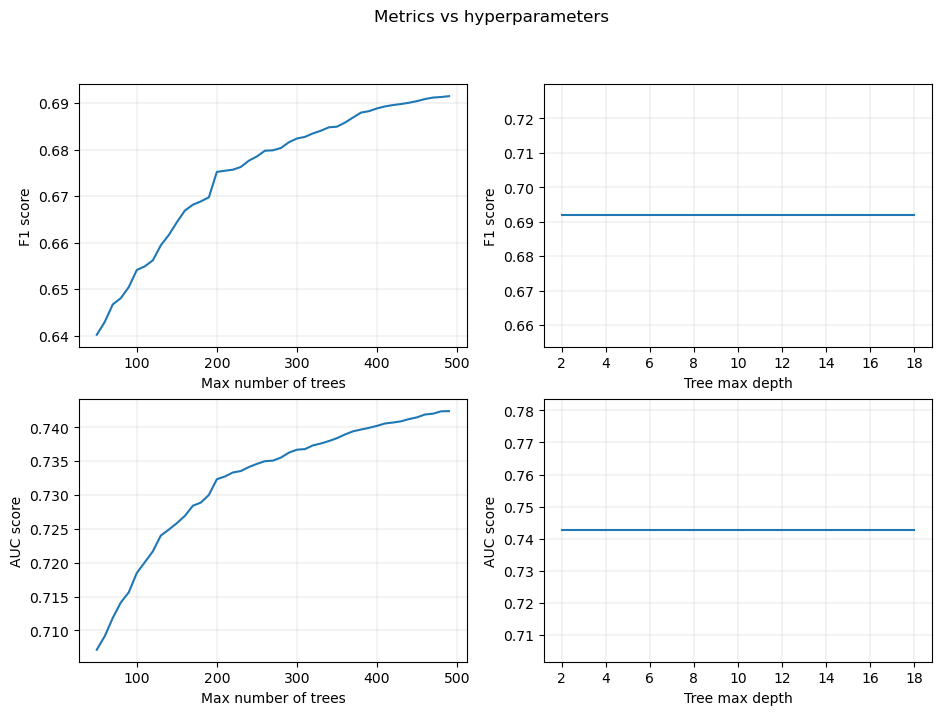

In [102]:
max_depth = range(2,20,2)
max_number_of_trees = range(50,500,10)

fig, ax = plt.subplots(2,2, figsize = (11,7.5))
fig.suptitle("Metrics vs hyperparameters")

ax[0,0].grid(lw = 0.2)
ax[1,0].grid(lw = 0.2)
ax[0,1].grid(lw = 0.2)
ax[1,1].grid(lw = 0.2)

ax[0,0].set_xlabel("Max number of trees")
ax[0,0].set_ylabel("F1 score")
ax[0,0].plot(max_number_of_trees, f1_max_number_of_trees)
ax[1,0].set_xlabel("Max number of trees")
ax[1,0].set_ylabel("AUC score")
ax[1,0].plot(max_number_of_trees, auc_max_number_of_trees)

ax[0,1].set_xlabel("Tree max depth")
ax[0,1].set_ylabel("F1 score")
ax[0,1].plot(max_depth, f1_max_depth)
ax[1,1].set_xlabel("Tree max depth")
ax[1,1].set_ylabel("AUC score")
ax[1,1].plot(max_depth, auc_max_depth)

In [94]:
# time used vs auc 
from datetime import datetime

time_complexity = list()
auc_metrics = list()

for max_number_of_trees in range(50,1000,50):
    start = datetime.now()
    
    bdt = set_parameters(50, max_number_of_trees) # max depth set to default 6
    
    time_complexity.append((datetime.now()- start).total_seconds())
    
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    auc_metrics.append(AUC_score(y_val,y_score))

for max_number_of_trees in range(1500,3000,500):
    start = datetime.now()
    
    bdt = set_parameters(50, max_number_of_trees) # max depth set to 50
    
    time_complexity.append((datetime.now()- start).total_seconds())
    
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    auc_metrics.append(AUC_score(y_val,y_score))

0:	test: 0.7143010	best: 0.7143010 (0)	total: 10.1ms	remaining: 495ms
1:	test: 0.7302111	best: 0.7302111 (1)	total: 21.8ms	remaining: 522ms
2:	test: 0.7315868	best: 0.7315868 (2)	total: 32.2ms	remaining: 504ms
3:	test: 0.7327755	best: 0.7327755 (3)	total: 42.3ms	remaining: 487ms
4:	test: 0.7335410	best: 0.7335410 (4)	total: 52.1ms	remaining: 469ms
5:	test: 0.7332337	best: 0.7335410 (4)	total: 62.4ms	remaining: 458ms
6:	test: 0.7332487	best: 0.7335410 (4)	total: 72.8ms	remaining: 447ms
7:	test: 0.7342049	best: 0.7342049 (7)	total: 82.7ms	remaining: 434ms
8:	test: 0.7343889	best: 0.7343889 (8)	total: 92.5ms	remaining: 421ms
9:	test: 0.7345753	best: 0.7345753 (9)	total: 103ms	remaining: 412ms
10:	test: 0.7342293	best: 0.7345753 (9)	total: 113ms	remaining: 400ms
11:	test: 0.7341703	best: 0.7345753 (9)	total: 123ms	remaining: 390ms
12:	test: 0.7347887	best: 0.7347887 (12)	total: 134ms	remaining: 382ms
13:	test: 0.7346363	best: 0.7347887 (12)	total: 145ms	remaining: 372ms
14:	test: 0.7349703

76:	test: 0.7448935	best: 0.7448935 (76)	total: 841ms	remaining: 251ms
77:	test: 0.7451315	best: 0.7451315 (77)	total: 860ms	remaining: 243ms
78:	test: 0.7452233	best: 0.7452233 (78)	total: 871ms	remaining: 232ms
79:	test: 0.7453455	best: 0.7453455 (79)	total: 883ms	remaining: 221ms
80:	test: 0.7456893	best: 0.7456893 (80)	total: 893ms	remaining: 209ms
81:	test: 0.7459253	best: 0.7459253 (81)	total: 903ms	remaining: 198ms
82:	test: 0.7460738	best: 0.7460738 (82)	total: 914ms	remaining: 187ms
83:	test: 0.7462510	best: 0.7462510 (83)	total: 923ms	remaining: 176ms
84:	test: 0.7463096	best: 0.7463096 (84)	total: 936ms	remaining: 165ms
85:	test: 0.7464669	best: 0.7464669 (85)	total: 946ms	remaining: 154ms
86:	test: 0.7465271	best: 0.7465271 (86)	total: 957ms	remaining: 143ms
87:	test: 0.7467168	best: 0.7467168 (87)	total: 967ms	remaining: 132ms
88:	test: 0.7468253	best: 0.7468253 (88)	total: 978ms	remaining: 121ms
89:	test: 0.7471762	best: 0.7471762 (89)	total: 988ms	remaining: 110ms
90:	te

99:	test: 0.7494965	best: 0.7494965 (99)	total: 1.07s	remaining: 537ms
100:	test: 0.7495901	best: 0.7495901 (100)	total: 1.08s	remaining: 526ms
101:	test: 0.7497399	best: 0.7497399 (101)	total: 1.09s	remaining: 515ms
102:	test: 0.7500494	best: 0.7500494 (102)	total: 1.1s	remaining: 504ms
103:	test: 0.7501100	best: 0.7501100 (103)	total: 1.11s	remaining: 494ms
104:	test: 0.7503421	best: 0.7503421 (104)	total: 1.13s	remaining: 483ms
105:	test: 0.7505561	best: 0.7505561 (105)	total: 1.14s	remaining: 472ms
106:	test: 0.7507069	best: 0.7507069 (106)	total: 1.15s	remaining: 463ms
107:	test: 0.7509013	best: 0.7509013 (107)	total: 1.16s	remaining: 452ms
108:	test: 0.7510068	best: 0.7510068 (108)	total: 1.17s	remaining: 441ms
109:	test: 0.7512595	best: 0.7512595 (109)	total: 1.18s	remaining: 430ms
110:	test: 0.7514949	best: 0.7514949 (110)	total: 1.21s	remaining: 425ms
111:	test: 0.7517662	best: 0.7517662 (111)	total: 1.23s	remaining: 416ms
112:	test: 0.7519568	best: 0.7519568 (112)	total: 1.28

70:	test: 0.7456423	best: 0.7456423 (70)	total: 1.32s	remaining: 2.39s
71:	test: 0.7459353	best: 0.7459353 (71)	total: 1.34s	remaining: 2.38s
72:	test: 0.7460823	best: 0.7460823 (72)	total: 1.36s	remaining: 2.36s
73:	test: 0.7465720	best: 0.7465720 (73)	total: 1.38s	remaining: 2.34s
74:	test: 0.7467015	best: 0.7467015 (74)	total: 1.4s	remaining: 2.33s
75:	test: 0.7469073	best: 0.7469073 (75)	total: 1.41s	remaining: 2.31s
76:	test: 0.7470560	best: 0.7470560 (76)	total: 1.43s	remaining: 2.28s
77:	test: 0.7472589	best: 0.7472589 (77)	total: 1.5s	remaining: 2.34s
78:	test: 0.7474136	best: 0.7474136 (78)	total: 1.52s	remaining: 2.32s
79:	test: 0.7476570	best: 0.7476570 (79)	total: 1.54s	remaining: 2.3s
80:	test: 0.7479584	best: 0.7479584 (80)	total: 1.55s	remaining: 2.28s
81:	test: 0.7482084	best: 0.7482084 (81)	total: 1.57s	remaining: 2.26s
82:	test: 0.7483129	best: 0.7483129 (82)	total: 1.59s	remaining: 2.24s
83:	test: 0.7485288	best: 0.7485288 (83)	total: 1.61s	remaining: 2.22s
84:	test:

190:	test: 0.7664599	best: 0.7664599 (190)	total: 3.63s	remaining: 171ms
191:	test: 0.7665645	best: 0.7665645 (191)	total: 3.65s	remaining: 152ms
192:	test: 0.7666491	best: 0.7666491 (192)	total: 3.66s	remaining: 133ms
193:	test: 0.7667776	best: 0.7667776 (193)	total: 3.69s	remaining: 114ms
194:	test: 0.7668988	best: 0.7668988 (194)	total: 3.7s	remaining: 95ms
195:	test: 0.7670150	best: 0.7670150 (195)	total: 3.72s	remaining: 76ms
196:	test: 0.7671622	best: 0.7671622 (196)	total: 3.74s	remaining: 57ms
197:	test: 0.7673099	best: 0.7673099 (197)	total: 3.76s	remaining: 38ms
198:	test: 0.7674214	best: 0.7674214 (198)	total: 3.78s	remaining: 19ms
199:	test: 0.7675170	best: 0.7675170 (199)	total: 3.8s	remaining: 0us

bestTest = 0.7675169667
bestIteration = 199

0:	test: 0.7142780	best: 0.7142780 (0)	total: 18ms	remaining: 4.47s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 39.4ms	remaining: 4.88s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 63.3ms	remaining: 5.21s
3:	test: 0.7324057	best: 

109:	test: 0.7538349	best: 0.7538349 (109)	total: 2.11s	remaining: 2.68s
110:	test: 0.7539252	best: 0.7539252 (110)	total: 2.12s	remaining: 2.66s
111:	test: 0.7541523	best: 0.7541523 (111)	total: 2.14s	remaining: 2.64s
112:	test: 0.7543534	best: 0.7543534 (112)	total: 2.16s	remaining: 2.62s
113:	test: 0.7544493	best: 0.7544493 (113)	total: 2.18s	remaining: 2.6s
114:	test: 0.7547346	best: 0.7547346 (114)	total: 2.2s	remaining: 2.58s
115:	test: 0.7548299	best: 0.7548299 (115)	total: 2.22s	remaining: 2.56s
116:	test: 0.7550235	best: 0.7550235 (116)	total: 2.23s	remaining: 2.54s
117:	test: 0.7551764	best: 0.7551764 (117)	total: 2.25s	remaining: 2.52s
118:	test: 0.7553914	best: 0.7553914 (118)	total: 2.27s	remaining: 2.5s
119:	test: 0.7555430	best: 0.7555430 (119)	total: 2.28s	remaining: 2.47s
120:	test: 0.7557150	best: 0.7557150 (120)	total: 2.3s	remaining: 2.45s
121:	test: 0.7558479	best: 0.7558479 (121)	total: 2.32s	remaining: 2.43s
122:	test: 0.7560479	best: 0.7560479 (122)	total: 2.34s

223:	test: 0.7697208	best: 0.7697208 (223)	total: 4.24s	remaining: 492ms
224:	test: 0.7698130	best: 0.7698130 (224)	total: 4.25s	remaining: 473ms
225:	test: 0.7699298	best: 0.7699298 (225)	total: 4.28s	remaining: 455ms
226:	test: 0.7700202	best: 0.7700202 (226)	total: 4.3s	remaining: 436ms
227:	test: 0.7700979	best: 0.7700979 (227)	total: 4.32s	remaining: 417ms
228:	test: 0.7701417	best: 0.7701417 (228)	total: 4.35s	remaining: 399ms
229:	test: 0.7702219	best: 0.7702219 (229)	total: 4.37s	remaining: 380ms
230:	test: 0.7703177	best: 0.7703177 (230)	total: 4.38s	remaining: 361ms
231:	test: 0.7703945	best: 0.7703945 (231)	total: 4.4s	remaining: 341ms
232:	test: 0.7704536	best: 0.7704536 (232)	total: 4.42s	remaining: 322ms
233:	test: 0.7704971	best: 0.7704971 (233)	total: 4.44s	remaining: 303ms
234:	test: 0.7705905	best: 0.7705905 (234)	total: 4.46s	remaining: 285ms
235:	test: 0.7706977	best: 0.7706977 (235)	total: 4.48s	remaining: 266ms
236:	test: 0.7707909	best: 0.7707909 (236)	total: 4.5

95:	test: 0.7510718	best: 0.7510718 (95)	total: 1.68s	remaining: 3.56s
96:	test: 0.7513650	best: 0.7513650 (96)	total: 1.7s	remaining: 3.55s
97:	test: 0.7515531	best: 0.7515531 (97)	total: 1.71s	remaining: 3.53s
98:	test: 0.7517755	best: 0.7517755 (98)	total: 1.73s	remaining: 3.51s
99:	test: 0.7519232	best: 0.7519232 (99)	total: 1.75s	remaining: 3.5s
100:	test: 0.7521951	best: 0.7521951 (100)	total: 1.76s	remaining: 3.48s
101:	test: 0.7523420	best: 0.7523420 (101)	total: 1.78s	remaining: 3.46s
102:	test: 0.7524723	best: 0.7524723 (102)	total: 1.8s	remaining: 3.44s
103:	test: 0.7525836	best: 0.7525836 (103)	total: 1.81s	remaining: 3.42s
104:	test: 0.7527808	best: 0.7527808 (104)	total: 1.83s	remaining: 3.4s
105:	test: 0.7530270	best: 0.7530270 (105)	total: 1.85s	remaining: 3.39s
106:	test: 0.7532277	best: 0.7532277 (106)	total: 1.87s	remaining: 3.37s
107:	test: 0.7534405	best: 0.7534405 (107)	total: 1.89s	remaining: 3.35s
108:	test: 0.7536650	best: 0.7536650 (108)	total: 1.9s	remaining:

215:	test: 0.7690641	best: 0.7690641 (215)	total: 3.75s	remaining: 1.46s
216:	test: 0.7691185	best: 0.7691185 (216)	total: 3.77s	remaining: 1.44s
217:	test: 0.7692114	best: 0.7692114 (217)	total: 3.79s	remaining: 1.43s
218:	test: 0.7693052	best: 0.7693052 (218)	total: 3.81s	remaining: 1.41s
219:	test: 0.7694079	best: 0.7694079 (219)	total: 3.83s	remaining: 1.39s
220:	test: 0.7694989	best: 0.7694989 (220)	total: 3.84s	remaining: 1.37s
221:	test: 0.7696093	best: 0.7696093 (221)	total: 3.86s	remaining: 1.36s
222:	test: 0.7696583	best: 0.7696583 (222)	total: 3.88s	remaining: 1.34s
223:	test: 0.7697208	best: 0.7697208 (223)	total: 3.9s	remaining: 1.32s
224:	test: 0.7698130	best: 0.7698130 (224)	total: 3.91s	remaining: 1.3s
225:	test: 0.7699298	best: 0.7699298 (225)	total: 3.93s	remaining: 1.29s
226:	test: 0.7700202	best: 0.7700202 (226)	total: 3.95s	remaining: 1.27s
227:	test: 0.7700979	best: 0.7700979 (227)	total: 3.96s	remaining: 1.25s
228:	test: 0.7701417	best: 0.7701417 (228)	total: 3.9

29:	test: 0.7382250	best: 0.7382250 (29)	total: 520ms	remaining: 5.55s
30:	test: 0.7382137	best: 0.7382250 (29)	total: 538ms	remaining: 5.54s
31:	test: 0.7384112	best: 0.7384112 (31)	total: 555ms	remaining: 5.51s
32:	test: 0.7389893	best: 0.7389893 (32)	total: 571ms	remaining: 5.49s
33:	test: 0.7391905	best: 0.7391905 (33)	total: 586ms	remaining: 5.45s
34:	test: 0.7394959	best: 0.7394959 (34)	total: 602ms	remaining: 5.42s
35:	test: 0.7396591	best: 0.7396591 (35)	total: 620ms	remaining: 5.41s
36:	test: 0.7398795	best: 0.7398795 (36)	total: 636ms	remaining: 5.38s
37:	test: 0.7401372	best: 0.7401372 (37)	total: 653ms	remaining: 5.36s
38:	test: 0.7406319	best: 0.7406319 (38)	total: 669ms	remaining: 5.34s
39:	test: 0.7405320	best: 0.7406319 (38)	total: 687ms	remaining: 5.33s
40:	test: 0.7406171	best: 0.7406319 (38)	total: 703ms	remaining: 5.3s
41:	test: 0.7407843	best: 0.7407843 (41)	total: 721ms	remaining: 5.29s
42:	test: 0.7409864	best: 0.7409864 (42)	total: 740ms	remaining: 5.28s
43:	tes

149:	test: 0.7608651	best: 0.7608651 (149)	total: 2.57s	remaining: 3.43s
150:	test: 0.7610500	best: 0.7610500 (150)	total: 2.59s	remaining: 3.41s
151:	test: 0.7611967	best: 0.7611967 (151)	total: 2.6s	remaining: 3.39s
152:	test: 0.7613018	best: 0.7613018 (152)	total: 2.62s	remaining: 3.38s
153:	test: 0.7614163	best: 0.7614163 (153)	total: 2.64s	remaining: 3.36s
154:	test: 0.7615147	best: 0.7615147 (154)	total: 2.65s	remaining: 3.34s
155:	test: 0.7617660	best: 0.7617660 (155)	total: 2.67s	remaining: 3.32s
156:	test: 0.7619246	best: 0.7619246 (156)	total: 2.69s	remaining: 3.31s
157:	test: 0.7621635	best: 0.7621635 (157)	total: 2.71s	remaining: 3.29s
158:	test: 0.7621990	best: 0.7621990 (158)	total: 2.72s	remaining: 3.27s
159:	test: 0.7623956	best: 0.7623956 (159)	total: 2.74s	remaining: 3.25s
160:	test: 0.7624879	best: 0.7624879 (160)	total: 2.76s	remaining: 3.24s
161:	test: 0.7625699	best: 0.7625699 (161)	total: 2.77s	remaining: 3.22s
162:	test: 0.7627798	best: 0.7627798 (162)	total: 2.

270:	test: 0.7736098	best: 0.7736098 (270)	total: 4.64s	remaining: 1.35s
271:	test: 0.7736760	best: 0.7736760 (271)	total: 4.66s	remaining: 1.34s
272:	test: 0.7737402	best: 0.7737402 (272)	total: 4.68s	remaining: 1.32s
273:	test: 0.7737912	best: 0.7737912 (273)	total: 4.7s	remaining: 1.3s
274:	test: 0.7738845	best: 0.7738845 (274)	total: 4.71s	remaining: 1.28s
275:	test: 0.7739486	best: 0.7739486 (275)	total: 4.73s	remaining: 1.27s
276:	test: 0.7740639	best: 0.7740639 (276)	total: 4.75s	remaining: 1.25s
277:	test: 0.7741651	best: 0.7741651 (277)	total: 4.77s	remaining: 1.23s
278:	test: 0.7742526	best: 0.7742526 (278)	total: 4.78s	remaining: 1.22s
279:	test: 0.7743906	best: 0.7743906 (279)	total: 4.8s	remaining: 1.2s
280:	test: 0.7744600	best: 0.7744600 (280)	total: 4.82s	remaining: 1.18s
281:	test: 0.7745648	best: 0.7745648 (281)	total: 4.83s	remaining: 1.16s
282:	test: 0.7746839	best: 0.7746839 (282)	total: 4.84s	remaining: 1.15s
283:	test: 0.7747495	best: 0.7747495 (283)	total: 4.86s

36:	test: 0.7398795	best: 0.7398795 (36)	total: 635ms	remaining: 6.23s
37:	test: 0.7401372	best: 0.7401372 (37)	total: 653ms	remaining: 6.22s
38:	test: 0.7406319	best: 0.7406319 (38)	total: 670ms	remaining: 6.2s
39:	test: 0.7405320	best: 0.7406319 (38)	total: 689ms	remaining: 6.2s
40:	test: 0.7406171	best: 0.7406319 (38)	total: 705ms	remaining: 6.17s
41:	test: 0.7407843	best: 0.7407843 (41)	total: 723ms	remaining: 6.16s
42:	test: 0.7409864	best: 0.7409864 (42)	total: 740ms	remaining: 6.14s
43:	test: 0.7412113	best: 0.7412113 (43)	total: 756ms	remaining: 6.11s
44:	test: 0.7414061	best: 0.7414061 (44)	total: 773ms	remaining: 6.1s
45:	test: 0.7417045	best: 0.7417045 (45)	total: 789ms	remaining: 6.07s
46:	test: 0.7419092	best: 0.7419092 (46)	total: 807ms	remaining: 6.06s
47:	test: 0.7420679	best: 0.7420679 (47)	total: 824ms	remaining: 6.04s
48:	test: 0.7421295	best: 0.7421295 (48)	total: 842ms	remaining: 6.03s
49:	test: 0.7421235	best: 0.7421295 (48)	total: 860ms	remaining: 6.02s
50:	test:

157:	test: 0.7621635	best: 0.7621635 (157)	total: 2.72s	remaining: 4.16s
158:	test: 0.7621990	best: 0.7621990 (158)	total: 2.74s	remaining: 4.15s
159:	test: 0.7623956	best: 0.7623956 (159)	total: 2.75s	remaining: 4.13s
160:	test: 0.7624879	best: 0.7624879 (160)	total: 2.77s	remaining: 4.12s
161:	test: 0.7625699	best: 0.7625699 (161)	total: 2.79s	remaining: 4.09s
162:	test: 0.7627798	best: 0.7627798 (162)	total: 2.81s	remaining: 4.08s
163:	test: 0.7629406	best: 0.7629406 (163)	total: 2.82s	remaining: 4.06s
164:	test: 0.7630829	best: 0.7630829 (164)	total: 2.84s	remaining: 4.04s
165:	test: 0.7632039	best: 0.7632039 (165)	total: 2.86s	remaining: 4.03s
166:	test: 0.7633156	best: 0.7633156 (166)	total: 2.87s	remaining: 4.01s
167:	test: 0.7634854	best: 0.7634854 (167)	total: 2.89s	remaining: 3.99s
168:	test: 0.7636657	best: 0.7636657 (168)	total: 2.91s	remaining: 3.98s
169:	test: 0.7637559	best: 0.7637559 (169)	total: 2.93s	remaining: 3.96s
170:	test: 0.7638509	best: 0.7638509 (170)	total: 2

277:	test: 0.7741651	best: 0.7741651 (277)	total: 4.77s	remaining: 2.09s
278:	test: 0.7742526	best: 0.7742526 (278)	total: 4.8s	remaining: 2.08s
279:	test: 0.7743906	best: 0.7743906 (279)	total: 4.81s	remaining: 2.06s
280:	test: 0.7744600	best: 0.7744600 (280)	total: 4.83s	remaining: 2.04s
281:	test: 0.7745648	best: 0.7745648 (281)	total: 4.84s	remaining: 2.03s
282:	test: 0.7746839	best: 0.7746839 (282)	total: 4.86s	remaining: 2.01s
283:	test: 0.7747495	best: 0.7747495 (283)	total: 4.87s	remaining: 1.99s
284:	test: 0.7747916	best: 0.7747916 (284)	total: 4.89s	remaining: 1.97s
285:	test: 0.7748240	best: 0.7748240 (285)	total: 4.91s	remaining: 1.96s
286:	test: 0.7749112	best: 0.7749112 (286)	total: 4.92s	remaining: 1.94s
287:	test: 0.7749613	best: 0.7749613 (287)	total: 4.94s	remaining: 1.92s
288:	test: 0.7750062	best: 0.7750062 (288)	total: 4.96s	remaining: 1.9s
289:	test: 0.7750771	best: 0.7750771 (289)	total: 4.97s	remaining: 1.89s
290:	test: 0.7751460	best: 0.7751460 (290)	total: 4.9

399:	test: 0.7819509	best: 0.7819509 (399)	total: 6.84s	remaining: 0us

bestTest = 0.7819509485
bestIteration = 399

0:	test: 0.7142780	best: 0.7142780 (0)	total: 17.2ms	remaining: 7.73s
1:	test: 0.7225660	best: 0.7225660 (1)	total: 34.3ms	remaining: 7.67s
2:	test: 0.7302040	best: 0.7302040 (2)	total: 52.1ms	remaining: 7.77s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 70.1ms	remaining: 7.82s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 87.2ms	remaining: 7.76s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 105ms	remaining: 7.77s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 122ms	remaining: 7.73s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 141ms	remaining: 7.78s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 156ms	remaining: 7.65s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 173ms	remaining: 7.63s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 188ms	remaining: 7.52s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 206ms	remaining: 7.5s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 

125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.17s	remaining: 5.58s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.19s	remaining: 5.57s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.21s	remaining: 5.55s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.22s	remaining: 5.53s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.24s	remaining: 5.51s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.26s	remaining: 5.5s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.28s	remaining: 5.49s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.29s	remaining: 5.47s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.31s	remaining: 5.45s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.33s	remaining: 5.43s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.34s	remaining: 5.41s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.36s	remaining: 5.39s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.38s	remaining: 5.38s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.

245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.22s	remaining: 3.5s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.24s	remaining: 3.48s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.26s	remaining: 3.47s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.28s	remaining: 3.46s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.3s	remaining: 3.44s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.31s	remaining: 3.42s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.33s	remaining: 3.4s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.35s	remaining: 3.38s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.37s	remaining: 3.37s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.38s	remaining: 3.35s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.4s	remaining: 3.33s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.42s	remaining: 3.31s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.43s	remaining: 3.3s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.45s	

367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.29s	remaining: 1.4s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.31s	remaining: 1.39s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.33s	remaining: 1.37s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.35s	remaining: 1.35s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.37s	remaining: 1.33s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.38s	remaining: 1.32s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.4s	remaining: 1.3s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.42s	remaining: 1.28s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.43s	remaining: 1.26s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.45s	remaining: 1.25s
377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.46s	remaining: 1.23s
378:	test: 0.7808904	best: 0.7808904 (378)	total: 6.48s	remaining: 1.21s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 6.5s	remaining: 1.2s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 6.52s	

36:	test: 0.7398795	best: 0.7398795 (36)	total: 633ms	remaining: 7.92s
37:	test: 0.7401372	best: 0.7401372 (37)	total: 651ms	remaining: 7.92s
38:	test: 0.7406319	best: 0.7406319 (38)	total: 668ms	remaining: 7.89s
39:	test: 0.7405320	best: 0.7406319 (38)	total: 685ms	remaining: 7.88s
40:	test: 0.7406171	best: 0.7406319 (38)	total: 700ms	remaining: 7.84s
41:	test: 0.7407843	best: 0.7407843 (41)	total: 718ms	remaining: 7.83s
42:	test: 0.7409864	best: 0.7409864 (42)	total: 735ms	remaining: 7.82s
43:	test: 0.7412113	best: 0.7412113 (43)	total: 751ms	remaining: 7.78s
44:	test: 0.7414061	best: 0.7414061 (44)	total: 769ms	remaining: 7.78s
45:	test: 0.7417045	best: 0.7417045 (45)	total: 786ms	remaining: 7.76s
46:	test: 0.7419092	best: 0.7419092 (46)	total: 804ms	remaining: 7.75s
47:	test: 0.7420679	best: 0.7420679 (47)	total: 821ms	remaining: 7.73s
48:	test: 0.7421295	best: 0.7421295 (48)	total: 839ms	remaining: 7.72s
49:	test: 0.7421235	best: 0.7421295 (48)	total: 857ms	remaining: 7.71s
50:	te

155:	test: 0.7617660	best: 0.7617660 (155)	total: 2.69s	remaining: 5.94s
156:	test: 0.7619246	best: 0.7619246 (156)	total: 2.71s	remaining: 5.92s
157:	test: 0.7621635	best: 0.7621635 (157)	total: 2.73s	remaining: 5.9s
158:	test: 0.7621990	best: 0.7621990 (158)	total: 2.74s	remaining: 5.89s
159:	test: 0.7623956	best: 0.7623956 (159)	total: 2.76s	remaining: 5.87s
160:	test: 0.7624879	best: 0.7624879 (160)	total: 2.78s	remaining: 5.85s
161:	test: 0.7625699	best: 0.7625699 (161)	total: 2.79s	remaining: 5.83s
162:	test: 0.7627798	best: 0.7627798 (162)	total: 2.81s	remaining: 5.81s
163:	test: 0.7629406	best: 0.7629406 (163)	total: 2.83s	remaining: 5.8s
164:	test: 0.7630829	best: 0.7630829 (164)	total: 2.85s	remaining: 5.78s
165:	test: 0.7632039	best: 0.7632039 (165)	total: 2.86s	remaining: 5.76s
166:	test: 0.7633156	best: 0.7633156 (166)	total: 2.88s	remaining: 5.74s
167:	test: 0.7634854	best: 0.7634854 (167)	total: 2.9s	remaining: 5.73s
168:	test: 0.7636657	best: 0.7636657 (168)	total: 2.92

277:	test: 0.7741651	best: 0.7741651 (277)	total: 4.78s	remaining: 3.81s
278:	test: 0.7742526	best: 0.7742526 (278)	total: 4.79s	remaining: 3.8s
279:	test: 0.7743906	best: 0.7743906 (279)	total: 4.81s	remaining: 3.78s
280:	test: 0.7744600	best: 0.7744600 (280)	total: 4.83s	remaining: 3.76s
281:	test: 0.7745648	best: 0.7745648 (281)	total: 4.84s	remaining: 3.74s
282:	test: 0.7746839	best: 0.7746839 (282)	total: 4.86s	remaining: 3.72s
283:	test: 0.7747495	best: 0.7747495 (283)	total: 4.88s	remaining: 3.71s
284:	test: 0.7747916	best: 0.7747916 (284)	total: 4.89s	remaining: 3.69s
285:	test: 0.7748240	best: 0.7748240 (285)	total: 4.91s	remaining: 3.67s
286:	test: 0.7749112	best: 0.7749112 (286)	total: 4.93s	remaining: 3.66s
287:	test: 0.7749613	best: 0.7749613 (287)	total: 4.94s	remaining: 3.64s
288:	test: 0.7750062	best: 0.7750062 (288)	total: 4.96s	remaining: 3.62s
289:	test: 0.7750771	best: 0.7750771 (289)	total: 4.98s	remaining: 3.6s
290:	test: 0.7751460	best: 0.7751460 (290)	total: 4.9

398:	test: 0.7818945	best: 0.7818945 (398)	total: 6.83s	remaining: 1.73s
399:	test: 0.7819509	best: 0.7819509 (399)	total: 6.84s	remaining: 1.71s
400:	test: 0.7819992	best: 0.7819992 (400)	total: 6.86s	remaining: 1.69s
401:	test: 0.7820275	best: 0.7820275 (401)	total: 6.87s	remaining: 1.68s
402:	test: 0.7820869	best: 0.7820869 (402)	total: 6.89s	remaining: 1.66s
403:	test: 0.7821340	best: 0.7821340 (403)	total: 6.91s	remaining: 1.64s
404:	test: 0.7821611	best: 0.7821611 (404)	total: 6.93s	remaining: 1.62s
405:	test: 0.7822069	best: 0.7822069 (405)	total: 6.94s	remaining: 1.61s
406:	test: 0.7822731	best: 0.7822731 (406)	total: 6.96s	remaining: 1.59s
407:	test: 0.7823268	best: 0.7823268 (407)	total: 6.98s	remaining: 1.57s
408:	test: 0.7823956	best: 0.7823956 (408)	total: 6.99s	remaining: 1.56s
409:	test: 0.7824331	best: 0.7824331 (409)	total: 7.01s	remaining: 1.54s
410:	test: 0.7824612	best: 0.7824612 (410)	total: 7.03s	remaining: 1.52s
411:	test: 0.7825132	best: 0.7825132 (411)	total: 7

12:	test: 0.7339981	best: 0.7340239 (11)	total: 223ms	remaining: 9.2s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 242ms	remaining: 9.27s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 259ms	remaining: 9.25s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 277ms	remaining: 9.23s
16:	test: 0.7350611	best: 0.7350611 (16)	total: 294ms	remaining: 9.21s
17:	test: 0.7350501	best: 0.7350611 (16)	total: 312ms	remaining: 9.21s
18:	test: 0.7355308	best: 0.7355308 (18)	total: 330ms	remaining: 9.21s
19:	test: 0.7354756	best: 0.7355308 (18)	total: 347ms	remaining: 9.21s
20:	test: 0.7355500	best: 0.7355500 (20)	total: 365ms	remaining: 9.2s
21:	test: 0.7355411	best: 0.7355500 (20)	total: 383ms	remaining: 9.2s
22:	test: 0.7360057	best: 0.7360057 (22)	total: 400ms	remaining: 9.16s
23:	test: 0.7360651	best: 0.7360651 (23)	total: 417ms	remaining: 9.14s
24:	test: 0.7365030	best: 0.7365030 (24)	total: 435ms	remaining: 9.14s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 450ms	remaining: 9.08s
26:	test:

134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.32s	remaining: 7.14s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.34s	remaining: 7.12s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.36s	remaining: 7.11s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.37s	remaining: 7.09s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.39s	remaining: 7.07s
139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.41s	remaining: 7.06s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.42s	remaining: 7.04s
141:	test: 0.7594369	best: 0.7594369 (141)	total: 2.44s	remaining: 7.02s
142:	test: 0.7597523	best: 0.7597523 (142)	total: 2.46s	remaining: 7s
143:	test: 0.7598904	best: 0.7598904 (143)	total: 2.47s	remaining: 6.98s
144:	test: 0.7600731	best: 0.7600731 (144)	total: 2.49s	remaining: 6.96s
145:	test: 0.7602662	best: 0.7602662 (145)	total: 2.51s	remaining: 6.94s
146:	test: 0.7604087	best: 0.7604087 (146)	total: 2.53s	remaining: 6.93s
147:	test: 0.7605092	best: 0.7605092 (147)	total: 2.54

254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.36s	remaining: 5.05s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.38s	remaining: 5.03s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.4s	remaining: 5.01s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.42s	remaining: 5s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.43s	remaining: 4.98s
259:	test: 0.7727878	best: 0.7727878 (259)	total: 4.45s	remaining: 4.96s
260:	test: 0.7728606	best: 0.7728606 (260)	total: 4.47s	remaining: 4.95s
261:	test: 0.7729671	best: 0.7729671 (261)	total: 4.48s	remaining: 4.93s
262:	test: 0.7730381	best: 0.7730381 (262)	total: 4.5s	remaining: 4.91s
263:	test: 0.7730883	best: 0.7730883 (263)	total: 4.52s	remaining: 4.89s
264:	test: 0.7731836	best: 0.7731836 (264)	total: 4.54s	remaining: 4.88s
265:	test: 0.7732620	best: 0.7732620 (265)	total: 4.55s	remaining: 4.86s
266:	test: 0.7733431	best: 0.7733431 (266)	total: 4.57s	remaining: 4.84s
267:	test: 0.7734359	best: 0.7734359 (267)	total: 4.59s	

372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.41s	remaining: 3.04s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.45s	remaining: 3.03s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.49s	remaining: 3.03s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.52s	remaining: 3.02s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.54s	remaining: 3s
377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.55s	remaining: 2.98s
378:	test: 0.7808904	best: 0.7808904 (378)	total: 6.57s	remaining: 2.96s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 6.59s	remaining: 2.95s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 6.61s	remaining: 2.93s
381:	test: 0.7810217	best: 0.7810217 (381)	total: 6.62s	remaining: 2.91s
382:	test: 0.7810595	best: 0.7810595 (382)	total: 6.64s	remaining: 2.9s
383:	test: 0.7811199	best: 0.7811199 (383)	total: 6.66s	remaining: 2.88s
384:	test: 0.7811573	best: 0.7811573 (384)	total: 6.67s	remaining: 2.86s
385:	test: 0.7812054	best: 0.7812054 (385)	total: 6.69s

491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.48s	remaining: 1s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.5s	remaining: 983ms
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.52s	remaining: 966ms
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.54s	remaining: 948ms
495:	test: 0.7859758	best: 0.7859758 (495)	total: 8.55s	remaining: 931ms
496:	test: 0.7860105	best: 0.7860105 (496)	total: 8.57s	remaining: 914ms
497:	test: 0.7860507	best: 0.7860507 (497)	total: 8.58s	remaining: 896ms
498:	test: 0.7860827	best: 0.7860827 (498)	total: 8.6s	remaining: 879ms
499:	test: 0.7861138	best: 0.7861138 (499)	total: 8.62s	remaining: 862ms
500:	test: 0.7861552	best: 0.7861552 (500)	total: 8.64s	remaining: 845ms
501:	test: 0.7861847	best: 0.7861847 (501)	total: 8.65s	remaining: 827ms
502:	test: 0.7862243	best: 0.7862243 (502)	total: 8.67s	remaining: 810ms
503:	test: 0.7862505	best: 0.7862505 (503)	total: 8.69s	remaining: 793ms
504:	test: 0.7862825	best: 0.7862825 (504)	total: 8.71s	

61:	test: 0.7436268	best: 0.7436268 (61)	total: 1.06s	remaining: 9.18s
62:	test: 0.7438574	best: 0.7438574 (62)	total: 1.08s	remaining: 9.18s
63:	test: 0.7440165	best: 0.7440165 (63)	total: 1.09s	remaining: 9.17s
64:	test: 0.7443227	best: 0.7443227 (64)	total: 1.11s	remaining: 9.15s
65:	test: 0.7443144	best: 0.7443227 (64)	total: 1.13s	remaining: 9.14s
66:	test: 0.7449053	best: 0.7449053 (66)	total: 1.15s	remaining: 9.12s
67:	test: 0.7449992	best: 0.7449992 (67)	total: 1.16s	remaining: 9.11s
68:	test: 0.7450829	best: 0.7450829 (68)	total: 1.18s	remaining: 9.09s
69:	test: 0.7455374	best: 0.7455374 (69)	total: 1.2s	remaining: 9.06s
70:	test: 0.7456423	best: 0.7456423 (70)	total: 1.21s	remaining: 9.05s
71:	test: 0.7459353	best: 0.7459353 (71)	total: 1.23s	remaining: 9.04s
72:	test: 0.7460823	best: 0.7460823 (72)	total: 1.25s	remaining: 9.03s
73:	test: 0.7465720	best: 0.7465720 (73)	total: 1.27s	remaining: 9.02s
74:	test: 0.7467015	best: 0.7467015 (74)	total: 1.29s	remaining: 9.02s
75:	tes

181:	test: 0.7653582	best: 0.7653582 (181)	total: 3.12s	remaining: 7.16s
182:	test: 0.7654590	best: 0.7654590 (182)	total: 3.14s	remaining: 7.15s
183:	test: 0.7656183	best: 0.7656183 (183)	total: 3.15s	remaining: 7.13s
184:	test: 0.7657539	best: 0.7657539 (184)	total: 3.17s	remaining: 7.11s
185:	test: 0.7658740	best: 0.7658740 (185)	total: 3.18s	remaining: 7.09s
186:	test: 0.7659372	best: 0.7659372 (186)	total: 3.2s	remaining: 7.07s
187:	test: 0.7661004	best: 0.7661004 (187)	total: 3.21s	remaining: 7.05s
188:	test: 0.7661905	best: 0.7661905 (188)	total: 3.23s	remaining: 7.03s
189:	test: 0.7663031	best: 0.7663031 (189)	total: 3.25s	remaining: 7.01s
190:	test: 0.7664599	best: 0.7664599 (190)	total: 3.27s	remaining: 6.99s
191:	test: 0.7665645	best: 0.7665645 (191)	total: 3.28s	remaining: 6.98s
192:	test: 0.7666491	best: 0.7666491 (192)	total: 3.3s	remaining: 6.96s
193:	test: 0.7667776	best: 0.7667776 (193)	total: 3.32s	remaining: 6.95s
194:	test: 0.7668988	best: 0.7668988 (194)	total: 3.3

302:	test: 0.7759707	best: 0.7759707 (302)	total: 5.17s	remaining: 5.07s
303:	test: 0.7760230	best: 0.7760230 (303)	total: 5.19s	remaining: 5.05s
304:	test: 0.7760808	best: 0.7760808 (304)	total: 5.2s	remaining: 5.03s
305:	test: 0.7761668	best: 0.7761668 (305)	total: 5.22s	remaining: 5.02s
306:	test: 0.7762178	best: 0.7762178 (306)	total: 5.24s	remaining: 5s
307:	test: 0.7763148	best: 0.7763148 (307)	total: 5.25s	remaining: 4.98s
308:	test: 0.7763709	best: 0.7763709 (308)	total: 5.27s	remaining: 4.96s
309:	test: 0.7764535	best: 0.7764535 (309)	total: 5.29s	remaining: 4.95s
310:	test: 0.7765300	best: 0.7765300 (310)	total: 5.3s	remaining: 4.93s
311:	test: 0.7765853	best: 0.7765853 (311)	total: 5.32s	remaining: 4.91s
312:	test: 0.7766460	best: 0.7766460 (312)	total: 5.34s	remaining: 4.9s
313:	test: 0.7766861	best: 0.7766861 (313)	total: 5.36s	remaining: 4.88s
314:	test: 0.7767399	best: 0.7767399 (314)	total: 5.37s	remaining: 4.86s
315:	test: 0.7768170	best: 0.7768170 (315)	total: 5.39s	r

423:	test: 0.7830521	best: 0.7830521 (423)	total: 7.24s	remaining: 3.01s
424:	test: 0.7831286	best: 0.7831286 (424)	total: 7.26s	remaining: 2.99s
425:	test: 0.7831484	best: 0.7831484 (425)	total: 7.28s	remaining: 2.97s
426:	test: 0.7831916	best: 0.7831916 (426)	total: 7.29s	remaining: 2.96s
427:	test: 0.7832428	best: 0.7832428 (427)	total: 7.31s	remaining: 2.94s
428:	test: 0.7832676	best: 0.7832676 (428)	total: 7.33s	remaining: 2.92s
429:	test: 0.7833160	best: 0.7833160 (429)	total: 7.34s	remaining: 2.9s
430:	test: 0.7833531	best: 0.7833531 (430)	total: 7.36s	remaining: 2.88s
431:	test: 0.7834015	best: 0.7834015 (431)	total: 7.38s	remaining: 2.87s
432:	test: 0.7834407	best: 0.7834407 (432)	total: 7.4s	remaining: 2.85s
433:	test: 0.7835133	best: 0.7835133 (433)	total: 7.41s	remaining: 2.83s
434:	test: 0.7835565	best: 0.7835565 (434)	total: 7.43s	remaining: 2.82s
435:	test: 0.7836171	best: 0.7836171 (435)	total: 7.45s	remaining: 2.8s
436:	test: 0.7836591	best: 0.7836591 (436)	total: 7.47

544:	test: 0.7877331	best: 0.7877331 (544)	total: 9.3s	remaining: 939ms
545:	test: 0.7877744	best: 0.7877744 (545)	total: 9.32s	remaining: 922ms
546:	test: 0.7878072	best: 0.7878072 (546)	total: 9.34s	remaining: 905ms
547:	test: 0.7878344	best: 0.7878344 (547)	total: 9.35s	remaining: 887ms
548:	test: 0.7878598	best: 0.7878598 (548)	total: 9.37s	remaining: 870ms
549:	test: 0.7878966	best: 0.7878966 (549)	total: 9.38s	remaining: 853ms
550:	test: 0.7879188	best: 0.7879188 (550)	total: 9.4s	remaining: 836ms
551:	test: 0.7879385	best: 0.7879385 (551)	total: 9.42s	remaining: 819ms
552:	test: 0.7879431	best: 0.7879431 (552)	total: 9.44s	remaining: 802ms
553:	test: 0.7879774	best: 0.7879774 (553)	total: 9.45s	remaining: 785ms
554:	test: 0.7880086	best: 0.7880086 (554)	total: 9.47s	remaining: 768ms
555:	test: 0.7880403	best: 0.7880403 (555)	total: 9.49s	remaining: 751ms
556:	test: 0.7880649	best: 0.7880649 (556)	total: 9.5s	remaining: 734ms
557:	test: 0.7880964	best: 0.7880964 (557)	total: 9.52

60:	test: 0.7434547	best: 0.7434547 (60)	total: 1.04s	remaining: 10.1s
61:	test: 0.7436268	best: 0.7436268 (61)	total: 1.06s	remaining: 10.1s
62:	test: 0.7438574	best: 0.7438574 (62)	total: 1.08s	remaining: 10.1s
63:	test: 0.7440165	best: 0.7440165 (63)	total: 1.1s	remaining: 10s
64:	test: 0.7443227	best: 0.7443227 (64)	total: 1.11s	remaining: 10s
65:	test: 0.7443144	best: 0.7443227 (64)	total: 1.13s	remaining: 10s
66:	test: 0.7449053	best: 0.7449053 (66)	total: 1.15s	remaining: 9.98s
67:	test: 0.7449992	best: 0.7449992 (67)	total: 1.17s	remaining: 9.97s
68:	test: 0.7450829	best: 0.7450829 (68)	total: 1.18s	remaining: 9.95s
69:	test: 0.7455374	best: 0.7455374 (69)	total: 1.2s	remaining: 9.93s
70:	test: 0.7456423	best: 0.7456423 (70)	total: 1.22s	remaining: 9.91s
71:	test: 0.7459353	best: 0.7459353 (71)	total: 1.23s	remaining: 9.9s
72:	test: 0.7460823	best: 0.7460823 (72)	total: 1.25s	remaining: 9.88s
73:	test: 0.7465720	best: 0.7465720 (73)	total: 1.27s	remaining: 9.87s
74:	test: 0.746

182:	test: 0.7654590	best: 0.7654590 (182)	total: 3.15s	remaining: 8.04s
183:	test: 0.7656183	best: 0.7656183 (183)	total: 3.17s	remaining: 8.02s
184:	test: 0.7657539	best: 0.7657539 (184)	total: 3.18s	remaining: 8s
185:	test: 0.7658740	best: 0.7658740 (185)	total: 3.2s	remaining: 7.98s
186:	test: 0.7659372	best: 0.7659372 (186)	total: 3.21s	remaining: 7.95s
187:	test: 0.7661004	best: 0.7661004 (187)	total: 3.23s	remaining: 7.94s
188:	test: 0.7661905	best: 0.7661905 (188)	total: 3.25s	remaining: 7.92s
189:	test: 0.7663031	best: 0.7663031 (189)	total: 3.27s	remaining: 7.91s
190:	test: 0.7664599	best: 0.7664599 (190)	total: 3.28s	remaining: 7.89s
191:	test: 0.7665645	best: 0.7665645 (191)	total: 3.3s	remaining: 7.87s
192:	test: 0.7666491	best: 0.7666491 (192)	total: 3.32s	remaining: 7.85s
193:	test: 0.7667776	best: 0.7667776 (193)	total: 3.33s	remaining: 7.84s
194:	test: 0.7668988	best: 0.7668988 (194)	total: 3.35s	remaining: 7.82s
195:	test: 0.7670150	best: 0.7670150 (195)	total: 3.37s	

302:	test: 0.7759707	best: 0.7759707 (302)	total: 5.23s	remaining: 5.99s
303:	test: 0.7760230	best: 0.7760230 (303)	total: 5.25s	remaining: 5.98s
304:	test: 0.7760808	best: 0.7760808 (304)	total: 5.27s	remaining: 5.96s
305:	test: 0.7761668	best: 0.7761668 (305)	total: 5.28s	remaining: 5.94s
306:	test: 0.7762178	best: 0.7762178 (306)	total: 5.3s	remaining: 5.92s
307:	test: 0.7763148	best: 0.7763148 (307)	total: 5.32s	remaining: 5.91s
308:	test: 0.7763709	best: 0.7763709 (308)	total: 5.33s	remaining: 5.89s
309:	test: 0.7764535	best: 0.7764535 (309)	total: 5.35s	remaining: 5.87s
310:	test: 0.7765300	best: 0.7765300 (310)	total: 5.37s	remaining: 5.85s
311:	test: 0.7765853	best: 0.7765853 (311)	total: 5.38s	remaining: 5.83s
312:	test: 0.7766460	best: 0.7766460 (312)	total: 5.4s	remaining: 5.81s
313:	test: 0.7766861	best: 0.7766861 (313)	total: 5.42s	remaining: 5.79s
314:	test: 0.7767399	best: 0.7767399 (314)	total: 5.43s	remaining: 5.78s
315:	test: 0.7768170	best: 0.7768170 (315)	total: 5.4

425:	test: 0.7831484	best: 0.7831484 (425)	total: 7.3s	remaining: 3.84s
426:	test: 0.7831916	best: 0.7831916 (426)	total: 7.32s	remaining: 3.82s
427:	test: 0.7832428	best: 0.7832428 (427)	total: 7.34s	remaining: 3.81s
428:	test: 0.7832676	best: 0.7832676 (428)	total: 7.35s	remaining: 3.79s
429:	test: 0.7833160	best: 0.7833160 (429)	total: 7.37s	remaining: 3.77s
430:	test: 0.7833531	best: 0.7833531 (430)	total: 7.38s	remaining: 3.75s
431:	test: 0.7834015	best: 0.7834015 (431)	total: 7.41s	remaining: 3.74s
432:	test: 0.7834407	best: 0.7834407 (432)	total: 7.42s	remaining: 3.72s
433:	test: 0.7835133	best: 0.7835133 (433)	total: 7.44s	remaining: 3.7s
434:	test: 0.7835565	best: 0.7835565 (434)	total: 7.46s	remaining: 3.69s
435:	test: 0.7836171	best: 0.7836171 (435)	total: 7.48s	remaining: 3.67s
436:	test: 0.7836591	best: 0.7836591 (436)	total: 7.49s	remaining: 3.65s
437:	test: 0.7836864	best: 0.7836864 (437)	total: 7.51s	remaining: 3.63s
438:	test: 0.7837425	best: 0.7837425 (438)	total: 7.5

547:	test: 0.7878344	best: 0.7878344 (547)	total: 9.36s	remaining: 1.74s
548:	test: 0.7878598	best: 0.7878598 (548)	total: 9.38s	remaining: 1.73s
549:	test: 0.7878966	best: 0.7878966 (549)	total: 9.4s	remaining: 1.71s
550:	test: 0.7879188	best: 0.7879188 (550)	total: 9.41s	remaining: 1.69s
551:	test: 0.7879385	best: 0.7879385 (551)	total: 9.43s	remaining: 1.67s
552:	test: 0.7879431	best: 0.7879431 (552)	total: 9.45s	remaining: 1.66s
553:	test: 0.7879774	best: 0.7879774 (553)	total: 9.46s	remaining: 1.64s
554:	test: 0.7880086	best: 0.7880086 (554)	total: 9.48s	remaining: 1.62s
555:	test: 0.7880403	best: 0.7880403 (555)	total: 9.51s	remaining: 1.61s
556:	test: 0.7880649	best: 0.7880649 (556)	total: 9.53s	remaining: 1.59s
557:	test: 0.7880964	best: 0.7880964 (557)	total: 9.54s	remaining: 1.57s
558:	test: 0.7881287	best: 0.7881287 (558)	total: 9.56s	remaining: 1.56s
559:	test: 0.7881727	best: 0.7881727 (559)	total: 9.58s	remaining: 1.54s
560:	test: 0.7882203	best: 0.7882203 (560)	total: 9.

12:	test: 0.7339981	best: 0.7340239 (11)	total: 222ms	remaining: 11.7s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 240ms	remaining: 11.8s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 258ms	remaining: 11.8s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 275ms	remaining: 11.8s
16:	test: 0.7350611	best: 0.7350611 (16)	total: 292ms	remaining: 11.7s
17:	test: 0.7350501	best: 0.7350611 (16)	total: 311ms	remaining: 11.8s
18:	test: 0.7355308	best: 0.7355308 (18)	total: 329ms	remaining: 11.8s
19:	test: 0.7354756	best: 0.7355308 (18)	total: 346ms	remaining: 11.8s
20:	test: 0.7355500	best: 0.7355500 (20)	total: 364ms	remaining: 11.8s
21:	test: 0.7355411	best: 0.7355500 (20)	total: 381ms	remaining: 11.8s
22:	test: 0.7360057	best: 0.7360057 (22)	total: 398ms	remaining: 11.7s
23:	test: 0.7360651	best: 0.7360651 (23)	total: 414ms	remaining: 11.7s
24:	test: 0.7365030	best: 0.7365030 (24)	total: 434ms	remaining: 11.7s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 451ms	remaining: 11.7s
26:	te

128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.31s	remaining: 10.2s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.33s	remaining: 10.2s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.35s	remaining: 10.2s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.37s	remaining: 10.2s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.39s	remaining: 10.2s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.4s	remaining: 10.2s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.42s	remaining: 10.2s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.44s	remaining: 10.1s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.46s	remaining: 10.1s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.48s	remaining: 10.1s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.5s	remaining: 10.1s
139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.51s	remaining: 10.1s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.53s	remaining: 10s
141:	test: 0.7594369	best: 0.7594369 (141)	total: 2.55s

245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.39s	remaining: 8.11s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.41s	remaining: 8.09s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.43s	remaining: 8.08s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.45s	remaining: 8.06s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.47s	remaining: 8.05s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.49s	remaining: 8.03s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.5s	remaining: 8.01s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.52s	remaining: 7.99s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.54s	remaining: 7.97s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.56s	remaining: 7.95s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.57s	remaining: 7.93s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.59s	remaining: 7.91s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.61s	remaining: 7.89s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.

362:	test: 0.7799845	best: 0.7799845 (362)	total: 6.5s	remaining: 6.03s
363:	test: 0.7800413	best: 0.7800413 (363)	total: 6.52s	remaining: 6.02s
364:	test: 0.7800897	best: 0.7800897 (364)	total: 6.54s	remaining: 6s
365:	test: 0.7801572	best: 0.7801572 (365)	total: 6.55s	remaining: 5.98s
366:	test: 0.7802246	best: 0.7802246 (366)	total: 6.57s	remaining: 5.96s
367:	test: 0.7802588	best: 0.7802588 (367)	total: 6.58s	remaining: 5.94s
368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.6s	remaining: 5.92s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.62s	remaining: 5.91s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.64s	remaining: 5.89s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.65s	remaining: 5.87s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.67s	remaining: 5.85s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.69s	remaining: 5.83s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.71s	remaining: 5.82s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.73s	

481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.6s	remaining: 3.89s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.61s	remaining: 3.87s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.63s	remaining: 3.85s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.65s	remaining: 3.83s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.67s	remaining: 3.81s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.69s	remaining: 3.8s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.7s	remaining: 3.78s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.72s	remaining: 3.76s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.74s	remaining: 3.74s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.75s	remaining: 3.73s
491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.77s	remaining: 3.71s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.79s	remaining: 3.69s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.81s	remaining: 3.67s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.82

600:	test: 0.7894439	best: 0.7894439 (600)	total: 10.7s	remaining: 1.76s
601:	test: 0.7894721	best: 0.7894721 (601)	total: 10.7s	remaining: 1.74s
602:	test: 0.7895080	best: 0.7895080 (602)	total: 10.7s	remaining: 1.72s
603:	test: 0.7895452	best: 0.7895452 (603)	total: 10.7s	remaining: 1.71s
604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.8s	remaining: 1.69s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.8s	remaining: 1.67s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 10.8s	remaining: 1.65s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 10.8s	remaining: 1.64s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.8s	remaining: 1.62s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.8s	remaining: 1.6s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.9s	remaining: 1.58s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 10.9s	remaining: 1.56s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 10.9s	remaining: 1.55s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 10

13:	test: 0.7343722	best: 0.7343722 (13)	total: 246ms	remaining: 12.9s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 265ms	remaining: 13s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 282ms	remaining: 12.9s
16:	test: 0.7350611	best: 0.7350611 (16)	total: 299ms	remaining: 12.9s
17:	test: 0.7350501	best: 0.7350611 (16)	total: 317ms	remaining: 12.9s
18:	test: 0.7355308	best: 0.7355308 (18)	total: 339ms	remaining: 13s
19:	test: 0.7354756	best: 0.7355308 (18)	total: 358ms	remaining: 13.1s
20:	test: 0.7355500	best: 0.7355500 (20)	total: 377ms	remaining: 13.1s
21:	test: 0.7355411	best: 0.7355500 (20)	total: 396ms	remaining: 13.1s
22:	test: 0.7360057	best: 0.7360057 (22)	total: 413ms	remaining: 13s
23:	test: 0.7360651	best: 0.7360651 (23)	total: 431ms	remaining: 13s
24:	test: 0.7365030	best: 0.7365030 (24)	total: 449ms	remaining: 13s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 466ms	remaining: 13s
26:	test: 0.7367853	best: 0.7367853 (26)	total: 485ms	remaining: 13s
27:	test: 0.7375016	

139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.54s	remaining: 11.1s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.56s	remaining: 11.1s
141:	test: 0.7594369	best: 0.7594369 (141)	total: 2.58s	remaining: 11.1s
142:	test: 0.7597523	best: 0.7597523 (142)	total: 2.6s	remaining: 11s
143:	test: 0.7598904	best: 0.7598904 (143)	total: 2.62s	remaining: 11s
144:	test: 0.7600731	best: 0.7600731 (144)	total: 2.63s	remaining: 11s
145:	test: 0.7602662	best: 0.7602662 (145)	total: 2.65s	remaining: 11s
146:	test: 0.7604087	best: 0.7604087 (146)	total: 2.67s	remaining: 11s
147:	test: 0.7605092	best: 0.7605092 (147)	total: 2.69s	remaining: 10.9s
148:	test: 0.7606715	best: 0.7606715 (148)	total: 2.71s	remaining: 10.9s
149:	test: 0.7608651	best: 0.7608651 (149)	total: 2.73s	remaining: 10.9s
150:	test: 0.7610500	best: 0.7610500 (150)	total: 2.74s	remaining: 10.9s
151:	test: 0.7611967	best: 0.7611967 (151)	total: 2.76s	remaining: 10.9s
152:	test: 0.7613018	best: 0.7613018 (152)	total: 2.78s	remain

252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.6s	remaining: 9.04s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.62s	remaining: 9.02s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.64s	remaining: 9s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.66s	remaining: 8.98s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.67s	remaining: 8.96s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.69s	remaining: 8.94s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.71s	remaining: 8.93s
259:	test: 0.7727878	best: 0.7727878 (259)	total: 4.72s	remaining: 8.91s
260:	test: 0.7728606	best: 0.7728606 (260)	total: 4.74s	remaining: 8.89s
261:	test: 0.7729671	best: 0.7729671 (261)	total: 4.76s	remaining: 8.87s
262:	test: 0.7730381	best: 0.7730381 (262)	total: 4.78s	remaining: 8.86s
263:	test: 0.7730883	best: 0.7730883 (263)	total: 4.8s	remaining: 8.84s
264:	test: 0.7731836	best: 0.7731836 (264)	total: 4.82s	remaining: 8.83s
265:	test: 0.7732620	best: 0.7732620 (265)	total: 4.84s	

370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.68s	remaining: 6.83s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.7s	remaining: 6.81s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.72s	remaining: 6.79s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.73s	remaining: 6.77s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.75s	remaining: 6.75s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.78s	remaining: 6.74s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.8s	remaining: 6.72s
377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.81s	remaining: 6.71s
378:	test: 0.7808904	best: 0.7808904 (378)	total: 6.83s	remaining: 6.69s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 6.85s	remaining: 6.67s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 6.87s	remaining: 6.65s
381:	test: 0.7810217	best: 0.7810217 (381)	total: 6.89s	remaining: 6.63s
382:	test: 0.7810595	best: 0.7810595 (382)	total: 6.9s	remaining: 6.61s
383:	test: 0.7811199	best: 0.7811199 (383)	total: 6.92

488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.72s	remaining: 4.66s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.74s	remaining: 4.64s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.76s	remaining: 4.62s
491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.77s	remaining: 4.6s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.79s	remaining: 4.58s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.81s	remaining: 4.57s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.83s	remaining: 4.55s
495:	test: 0.7859758	best: 0.7859758 (495)	total: 8.85s	remaining: 4.53s
496:	test: 0.7860105	best: 0.7860105 (496)	total: 8.86s	remaining: 4.51s
497:	test: 0.7860507	best: 0.7860507 (497)	total: 8.88s	remaining: 4.49s
498:	test: 0.7860827	best: 0.7860827 (498)	total: 8.9s	remaining: 4.48s
499:	test: 0.7861138	best: 0.7861138 (499)	total: 8.91s	remaining: 4.46s
500:	test: 0.7861552	best: 0.7861552 (500)	total: 8.93s	remaining: 4.44s
501:	test: 0.7861847	best: 0.7861847 (501)	total: 8.9

608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.8s	remaining: 2.5s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.8s	remaining: 2.48s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.8s	remaining: 2.47s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 10.9s	remaining: 2.45s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 10.9s	remaining: 2.43s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 10.9s	remaining: 2.41s
614:	test: 0.7898811	best: 0.7898811 (614)	total: 10.9s	remaining: 2.4s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 10.9s	remaining: 2.38s
616:	test: 0.7899600	best: 0.7899600 (616)	total: 10.9s	remaining: 2.36s
617:	test: 0.7899905	best: 0.7899905 (617)	total: 11s	remaining: 2.34s
618:	test: 0.7900090	best: 0.7900090 (618)	total: 11s	remaining: 2.32s
619:	test: 0.7900435	best: 0.7900435 (619)	total: 11s	remaining: 2.31s
620:	test: 0.7900678	best: 0.7900678 (620)	total: 11s	remaining: 2.29s
621:	test: 0.7901050	best: 0.7901050 (621)	total: 11s	remaini

729:	test: 0.7926798	best: 0.7926798 (729)	total: 12.9s	remaining: 353ms
730:	test: 0.7926964	best: 0.7926964 (730)	total: 12.9s	remaining: 335ms
731:	test: 0.7927267	best: 0.7927267 (731)	total: 12.9s	remaining: 318ms
732:	test: 0.7927491	best: 0.7927491 (732)	total: 12.9s	remaining: 300ms
733:	test: 0.7927738	best: 0.7927738 (733)	total: 12.9s	remaining: 282ms
734:	test: 0.7927862	best: 0.7927862 (734)	total: 13s	remaining: 265ms
735:	test: 0.7928033	best: 0.7928033 (735)	total: 13s	remaining: 247ms
736:	test: 0.7928143	best: 0.7928143 (736)	total: 13s	remaining: 230ms
737:	test: 0.7928417	best: 0.7928417 (737)	total: 13s	remaining: 212ms
738:	test: 0.7928662	best: 0.7928662 (738)	total: 13.1s	remaining: 194ms
739:	test: 0.7928870	best: 0.7928870 (739)	total: 13.1s	remaining: 177ms
740:	test: 0.7929064	best: 0.7929064 (740)	total: 13.1s	remaining: 159ms
741:	test: 0.7929231	best: 0.7929231 (741)	total: 13.1s	remaining: 141ms
742:	test: 0.7929598	best: 0.7929598 (742)	total: 13.1s	rem

96:	test: 0.7513650	best: 0.7513650 (96)	total: 1.67s	remaining: 12.1s
97:	test: 0.7515531	best: 0.7515531 (97)	total: 1.69s	remaining: 12.1s
98:	test: 0.7517755	best: 0.7517755 (98)	total: 1.71s	remaining: 12.1s
99:	test: 0.7519232	best: 0.7519232 (99)	total: 1.72s	remaining: 12.1s
100:	test: 0.7521951	best: 0.7521951 (100)	total: 1.74s	remaining: 12.1s
101:	test: 0.7523420	best: 0.7523420 (101)	total: 1.76s	remaining: 12s
102:	test: 0.7524723	best: 0.7524723 (102)	total: 1.78s	remaining: 12s
103:	test: 0.7525836	best: 0.7525836 (103)	total: 1.79s	remaining: 12s
104:	test: 0.7527808	best: 0.7527808 (104)	total: 1.81s	remaining: 12s
105:	test: 0.7530270	best: 0.7530270 (105)	total: 1.83s	remaining: 12s
106:	test: 0.7532277	best: 0.7532277 (106)	total: 1.85s	remaining: 12s
107:	test: 0.7534405	best: 0.7534405 (107)	total: 1.86s	remaining: 12s
108:	test: 0.7536650	best: 0.7536650 (108)	total: 1.88s	remaining: 11.9s
109:	test: 0.7538349	best: 0.7538349 (109)	total: 1.9s	remaining: 11.9s
1

214:	test: 0.7689616	best: 0.7689616 (214)	total: 3.75s	remaining: 10.2s
215:	test: 0.7690641	best: 0.7690641 (215)	total: 3.77s	remaining: 10.2s
216:	test: 0.7691185	best: 0.7691185 (216)	total: 3.79s	remaining: 10.2s
217:	test: 0.7692114	best: 0.7692114 (217)	total: 3.81s	remaining: 10.2s
218:	test: 0.7693052	best: 0.7693052 (218)	total: 3.82s	remaining: 10.1s
219:	test: 0.7694079	best: 0.7694079 (219)	total: 3.84s	remaining: 10.1s
220:	test: 0.7694989	best: 0.7694989 (220)	total: 3.86s	remaining: 10.1s
221:	test: 0.7696093	best: 0.7696093 (221)	total: 3.88s	remaining: 10.1s
222:	test: 0.7696583	best: 0.7696583 (222)	total: 3.89s	remaining: 10.1s
223:	test: 0.7697208	best: 0.7697208 (223)	total: 3.91s	remaining: 10.1s
224:	test: 0.7698130	best: 0.7698130 (224)	total: 3.93s	remaining: 10s
225:	test: 0.7699298	best: 0.7699298 (225)	total: 3.95s	remaining: 10s
226:	test: 0.7700202	best: 0.7700202 (226)	total: 3.96s	remaining: 10s
227:	test: 0.7700979	best: 0.7700979 (227)	total: 3.98s	r

331:	test: 0.7779483	best: 0.7779483 (331)	total: 5.84s	remaining: 8.23s
332:	test: 0.7780149	best: 0.7780149 (332)	total: 5.86s	remaining: 8.21s
333:	test: 0.7780844	best: 0.7780844 (333)	total: 5.87s	remaining: 8.19s
334:	test: 0.7781238	best: 0.7781238 (334)	total: 5.89s	remaining: 8.17s
335:	test: 0.7782203	best: 0.7782203 (335)	total: 5.91s	remaining: 8.16s
336:	test: 0.7782695	best: 0.7782695 (336)	total: 5.92s	remaining: 8.14s
337:	test: 0.7783738	best: 0.7783738 (337)	total: 5.94s	remaining: 8.12s
338:	test: 0.7784211	best: 0.7784211 (338)	total: 5.96s	remaining: 8.1s
339:	test: 0.7784772	best: 0.7784772 (339)	total: 5.97s	remaining: 8.08s
340:	test: 0.7785544	best: 0.7785544 (340)	total: 5.99s	remaining: 8.06s
341:	test: 0.7786455	best: 0.7786455 (341)	total: 6.01s	remaining: 8.04s
342:	test: 0.7787007	best: 0.7787007 (342)	total: 6.02s	remaining: 8.03s
343:	test: 0.7787618	best: 0.7787618 (343)	total: 6.04s	remaining: 8.01s
344:	test: 0.7787975	best: 0.7787975 (344)	total: 6.

454:	test: 0.7843821	best: 0.7843821 (454)	total: 7.91s	remaining: 6s
455:	test: 0.7844128	best: 0.7844128 (455)	total: 7.93s	remaining: 5.98s
456:	test: 0.7844393	best: 0.7844393 (456)	total: 7.95s	remaining: 5.96s
457:	test: 0.7844492	best: 0.7844492 (457)	total: 7.96s	remaining: 5.95s
458:	test: 0.7844979	best: 0.7844979 (458)	total: 7.98s	remaining: 5.93s
459:	test: 0.7845376	best: 0.7845376 (459)	total: 8s	remaining: 5.91s
460:	test: 0.7845876	best: 0.7845876 (460)	total: 8.02s	remaining: 5.89s
461:	test: 0.7846430	best: 0.7846430 (461)	total: 8.03s	remaining: 5.88s
462:	test: 0.7846876	best: 0.7846876 (462)	total: 8.05s	remaining: 5.86s
463:	test: 0.7847078	best: 0.7847078 (463)	total: 8.07s	remaining: 5.84s
464:	test: 0.7847386	best: 0.7847386 (464)	total: 8.09s	remaining: 5.83s
465:	test: 0.7847875	best: 0.7847875 (465)	total: 8.1s	remaining: 5.81s
466:	test: 0.7848347	best: 0.7848347 (466)	total: 8.12s	remaining: 5.79s
467:	test: 0.7848775	best: 0.7848775 (467)	total: 8.14s	re

569:	test: 0.7885203	best: 0.7885203 (569)	total: 9.97s	remaining: 4.02s
570:	test: 0.7885414	best: 0.7885414 (570)	total: 9.99s	remaining: 4s
571:	test: 0.7885870	best: 0.7885870 (571)	total: 10s	remaining: 3.99s
572:	test: 0.7886289	best: 0.7886289 (572)	total: 10s	remaining: 3.97s
573:	test: 0.7886562	best: 0.7886562 (573)	total: 10s	remaining: 3.95s
574:	test: 0.7887021	best: 0.7887021 (574)	total: 10.1s	remaining: 3.94s
575:	test: 0.7887432	best: 0.7887432 (575)	total: 10.1s	remaining: 3.92s
576:	test: 0.7887627	best: 0.7887627 (576)	total: 10.1s	remaining: 3.9s
577:	test: 0.7887937	best: 0.7887937 (577)	total: 10.1s	remaining: 3.88s
578:	test: 0.7888264	best: 0.7888264 (578)	total: 10.1s	remaining: 3.86s
579:	test: 0.7888545	best: 0.7888545 (579)	total: 10.1s	remaining: 3.85s
580:	test: 0.7888833	best: 0.7888833 (580)	total: 10.2s	remaining: 3.83s
581:	test: 0.7889291	best: 0.7889291 (581)	total: 10.2s	remaining: 3.81s
582:	test: 0.7889493	best: 0.7889493 (582)	total: 10.2s	remai

689:	test: 0.7918482	best: 0.7918482 (689)	total: 12s	remaining: 1.92s
690:	test: 0.7918734	best: 0.7918734 (690)	total: 12s	remaining: 1.9s
691:	test: 0.7918975	best: 0.7918975 (691)	total: 12.1s	remaining: 1.88s
692:	test: 0.7919235	best: 0.7919235 (692)	total: 12.1s	remaining: 1.86s
693:	test: 0.7919522	best: 0.7919522 (693)	total: 12.1s	remaining: 1.85s
694:	test: 0.7919664	best: 0.7919664 (694)	total: 12.1s	remaining: 1.83s
695:	test: 0.7919727	best: 0.7919727 (695)	total: 12.1s	remaining: 1.81s
696:	test: 0.7919842	best: 0.7919842 (696)	total: 12.1s	remaining: 1.79s
697:	test: 0.7920085	best: 0.7920085 (697)	total: 12.2s	remaining: 1.78s
698:	test: 0.7920323	best: 0.7920323 (698)	total: 12.2s	remaining: 1.76s
699:	test: 0.7920556	best: 0.7920556 (699)	total: 12.2s	remaining: 1.74s
700:	test: 0.7920708	best: 0.7920708 (700)	total: 12.2s	remaining: 1.73s
701:	test: 0.7920938	best: 0.7920938 (701)	total: 12.2s	remaining: 1.71s
702:	test: 0.7921150	best: 0.7921150 (702)	total: 12.3s	

12:	test: 0.7339981	best: 0.7340239 (11)	total: 221ms	remaining: 14.2s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 240ms	remaining: 14.3s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 257ms	remaining: 14.3s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 274ms	remaining: 14.3s
16:	test: 0.7350611	best: 0.7350611 (16)	total: 292ms	remaining: 14.3s
17:	test: 0.7350501	best: 0.7350611 (16)	total: 310ms	remaining: 14.3s
18:	test: 0.7355308	best: 0.7355308 (18)	total: 327ms	remaining: 14.3s
19:	test: 0.7354756	best: 0.7355308 (18)	total: 344ms	remaining: 14.3s
20:	test: 0.7355500	best: 0.7355500 (20)	total: 362ms	remaining: 14.3s
21:	test: 0.7355411	best: 0.7355500 (20)	total: 379ms	remaining: 14.3s
22:	test: 0.7360057	best: 0.7360057 (22)	total: 395ms	remaining: 14.2s
23:	test: 0.7360651	best: 0.7360651 (23)	total: 411ms	remaining: 14.2s
24:	test: 0.7365030	best: 0.7365030 (24)	total: 429ms	remaining: 14.2s
25:	test: 0.7366318	best: 0.7366318 (25)	total: 445ms	remaining: 14.1s
26:	te

134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.28s	remaining: 12.1s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.3s	remaining: 12.1s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.32s	remaining: 12.1s
137:	test: 0.7587868	best: 0.7587868 (137)	total: 2.34s	remaining: 12.1s
138:	test: 0.7589318	best: 0.7589318 (138)	total: 2.35s	remaining: 12s
139:	test: 0.7591181	best: 0.7591181 (139)	total: 2.37s	remaining: 12s
140:	test: 0.7593174	best: 0.7593174 (140)	total: 2.39s	remaining: 12s
141:	test: 0.7594369	best: 0.7594369 (141)	total: 2.4s	remaining: 12s
142:	test: 0.7597523	best: 0.7597523 (142)	total: 2.42s	remaining: 12s
143:	test: 0.7598904	best: 0.7598904 (143)	total: 2.44s	remaining: 11.9s
144:	test: 0.7600731	best: 0.7600731 (144)	total: 2.45s	remaining: 11.9s
145:	test: 0.7602662	best: 0.7602662 (145)	total: 2.47s	remaining: 11.9s
146:	test: 0.7604087	best: 0.7604087 (146)	total: 2.49s	remaining: 11.9s
147:	test: 0.7605092	best: 0.7605092 (147)	total: 2.51s	remaini

255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.35s	remaining: 10.1s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.37s	remaining: 10.1s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.39s	remaining: 10.1s
258:	test: 0.7727004	best: 0.7727004 (258)	total: 4.4s	remaining: 10.1s
259:	test: 0.7727878	best: 0.7727878 (259)	total: 4.42s	remaining: 10s
260:	test: 0.7728606	best: 0.7728606 (260)	total: 4.44s	remaining: 10s
261:	test: 0.7729671	best: 0.7729671 (261)	total: 4.46s	remaining: 10s
262:	test: 0.7730381	best: 0.7730381 (262)	total: 4.47s	remaining: 9.98s
263:	test: 0.7730883	best: 0.7730883 (263)	total: 4.49s	remaining: 9.97s
264:	test: 0.7731836	best: 0.7731836 (264)	total: 4.51s	remaining: 9.95s
265:	test: 0.7732620	best: 0.7732620 (265)	total: 4.52s	remaining: 9.93s
266:	test: 0.7733431	best: 0.7733431 (266)	total: 4.54s	remaining: 9.91s
267:	test: 0.7734359	best: 0.7734359 (267)	total: 4.56s	remaining: 9.9s
268:	test: 0.7734742	best: 0.7734742 (268)	total: 4.57s	rem

378:	test: 0.7808904	best: 0.7808904 (378)	total: 6.42s	remaining: 7.98s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 6.44s	remaining: 7.97s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 6.46s	remaining: 7.95s
381:	test: 0.7810217	best: 0.7810217 (381)	total: 6.47s	remaining: 7.93s
382:	test: 0.7810595	best: 0.7810595 (382)	total: 6.49s	remaining: 7.91s
383:	test: 0.7811199	best: 0.7811199 (383)	total: 6.51s	remaining: 7.9s
384:	test: 0.7811573	best: 0.7811573 (384)	total: 6.52s	remaining: 7.88s
385:	test: 0.7812054	best: 0.7812054 (385)	total: 6.54s	remaining: 7.86s
386:	test: 0.7812619	best: 0.7812619 (386)	total: 6.55s	remaining: 7.84s
387:	test: 0.7813103	best: 0.7813103 (387)	total: 6.57s	remaining: 7.83s
388:	test: 0.7813558	best: 0.7813558 (388)	total: 6.59s	remaining: 7.81s
389:	test: 0.7814235	best: 0.7814235 (389)	total: 6.61s	remaining: 7.79s
390:	test: 0.7814791	best: 0.7814791 (390)	total: 6.62s	remaining: 7.77s
391:	test: 0.7815187	best: 0.7815187 (391)	total: 6.

492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.33s	remaining: 6.03s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.34s	remaining: 6.01s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.36s	remaining: 6s
495:	test: 0.7859758	best: 0.7859758 (495)	total: 8.38s	remaining: 5.98s
496:	test: 0.7860105	best: 0.7860105 (496)	total: 8.4s	remaining: 5.96s
497:	test: 0.7860507	best: 0.7860507 (497)	total: 8.41s	remaining: 5.95s
498:	test: 0.7860827	best: 0.7860827 (498)	total: 8.43s	remaining: 5.93s
499:	test: 0.7861138	best: 0.7861138 (499)	total: 8.44s	remaining: 5.91s
500:	test: 0.7861552	best: 0.7861552 (500)	total: 8.46s	remaining: 5.89s
501:	test: 0.7861847	best: 0.7861847 (501)	total: 8.48s	remaining: 5.88s
502:	test: 0.7862243	best: 0.7862243 (502)	total: 8.49s	remaining: 5.86s
503:	test: 0.7862505	best: 0.7862505 (503)	total: 8.51s	remaining: 5.84s
504:	test: 0.7862825	best: 0.7862825 (504)	total: 8.53s	remaining: 5.83s
505:	test: 0.7863209	best: 0.7863209 (505)	total: 8.55s

614:	test: 0.7898811	best: 0.7898811 (614)	total: 10.4s	remaining: 3.96s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 10.4s	remaining: 3.95s
616:	test: 0.7899600	best: 0.7899600 (616)	total: 10.4s	remaining: 3.93s
617:	test: 0.7899905	best: 0.7899905 (617)	total: 10.4s	remaining: 3.92s
618:	test: 0.7900090	best: 0.7900090 (618)	total: 10.4s	remaining: 3.9s
619:	test: 0.7900435	best: 0.7900435 (619)	total: 10.5s	remaining: 3.88s
620:	test: 0.7900678	best: 0.7900678 (620)	total: 10.5s	remaining: 3.86s
621:	test: 0.7901050	best: 0.7901050 (621)	total: 10.5s	remaining: 3.85s
622:	test: 0.7901263	best: 0.7901263 (622)	total: 10.5s	remaining: 3.83s
623:	test: 0.7901525	best: 0.7901525 (623)	total: 10.5s	remaining: 3.81s
624:	test: 0.7901857	best: 0.7901857 (624)	total: 10.5s	remaining: 3.8s
625:	test: 0.7902063	best: 0.7902063 (625)	total: 10.6s	remaining: 3.78s
626:	test: 0.7902438	best: 0.7902438 (626)	total: 10.6s	remaining: 3.76s
627:	test: 0.7902676	best: 0.7902676 (627)	total: 10.

736:	test: 0.7928143	best: 0.7928143 (736)	total: 12.4s	remaining: 1.91s
737:	test: 0.7928417	best: 0.7928417 (737)	total: 12.5s	remaining: 1.89s
738:	test: 0.7928662	best: 0.7928662 (738)	total: 12.5s	remaining: 1.87s
739:	test: 0.7928870	best: 0.7928870 (739)	total: 12.5s	remaining: 1.86s
740:	test: 0.7929064	best: 0.7929064 (740)	total: 12.5s	remaining: 1.84s
741:	test: 0.7929231	best: 0.7929231 (741)	total: 12.5s	remaining: 1.82s
742:	test: 0.7929598	best: 0.7929598 (742)	total: 12.5s	remaining: 1.8s
743:	test: 0.7929892	best: 0.7929892 (743)	total: 12.6s	remaining: 1.79s
744:	test: 0.7930246	best: 0.7930246 (744)	total: 12.6s	remaining: 1.77s
745:	test: 0.7930401	best: 0.7930401 (745)	total: 12.6s	remaining: 1.75s
746:	test: 0.7930586	best: 0.7930586 (746)	total: 12.6s	remaining: 1.74s
747:	test: 0.7930703	best: 0.7930703 (747)	total: 12.6s	remaining: 1.72s
748:	test: 0.7930982	best: 0.7930982 (748)	total: 12.6s	remaining: 1.7s
749:	test: 0.7931095	best: 0.7931095 (749)	total: 12.

2:	test: 0.7302040	best: 0.7302040 (2)	total: 52.4ms	remaining: 15.7s
3:	test: 0.7324057	best: 0.7324057 (3)	total: 70ms	remaining: 15.7s
4:	test: 0.7319588	best: 0.7324057 (3)	total: 87.1ms	remaining: 15.6s
5:	test: 0.7335665	best: 0.7335665 (5)	total: 104ms	remaining: 15.5s
6:	test: 0.7333710	best: 0.7335665 (5)	total: 121ms	remaining: 15.4s
7:	test: 0.7339973	best: 0.7339973 (7)	total: 138ms	remaining: 15.4s
8:	test: 0.7335687	best: 0.7339973 (7)	total: 153ms	remaining: 15.2s
9:	test: 0.7337912	best: 0.7339973 (7)	total: 171ms	remaining: 15.2s
10:	test: 0.7336417	best: 0.7339973 (7)	total: 185ms	remaining: 14.9s
11:	test: 0.7340239	best: 0.7340239 (11)	total: 202ms	remaining: 14.9s
12:	test: 0.7339981	best: 0.7340239 (11)	total: 219ms	remaining: 14.9s
13:	test: 0.7343722	best: 0.7343722 (13)	total: 236ms	remaining: 14.9s
14:	test: 0.7346298	best: 0.7346298 (14)	total: 253ms	remaining: 14.9s
15:	test: 0.7347868	best: 0.7347868 (15)	total: 272ms	remaining: 15s
16:	test: 0.7350611	best

123:	test: 0.7562712	best: 0.7562712 (123)	total: 2.11s	remaining: 13.2s
124:	test: 0.7565281	best: 0.7565281 (124)	total: 2.13s	remaining: 13.2s
125:	test: 0.7567663	best: 0.7567663 (125)	total: 2.15s	remaining: 13.2s
126:	test: 0.7569350	best: 0.7569350 (126)	total: 2.16s	remaining: 13.2s
127:	test: 0.7570452	best: 0.7570452 (127)	total: 2.18s	remaining: 13.1s
128:	test: 0.7571696	best: 0.7571696 (128)	total: 2.19s	remaining: 13.1s
129:	test: 0.7573991	best: 0.7573991 (129)	total: 2.21s	remaining: 13.1s
130:	test: 0.7574578	best: 0.7574578 (130)	total: 2.23s	remaining: 13.1s
131:	test: 0.7576019	best: 0.7576019 (131)	total: 2.25s	remaining: 13.1s
132:	test: 0.7577977	best: 0.7577977 (132)	total: 2.26s	remaining: 13.1s
133:	test: 0.7580377	best: 0.7580377 (133)	total: 2.28s	remaining: 13s
134:	test: 0.7582073	best: 0.7582073 (134)	total: 2.3s	remaining: 13s
135:	test: 0.7584298	best: 0.7584298 (135)	total: 2.31s	remaining: 13s
136:	test: 0.7586533	best: 0.7586533 (136)	total: 2.33s	re

244:	test: 0.7715410	best: 0.7715410 (244)	total: 4.16s	remaining: 11.1s
245:	test: 0.7716495	best: 0.7716495 (245)	total: 4.18s	remaining: 11.1s
246:	test: 0.7717166	best: 0.7717166 (246)	total: 4.2s	remaining: 11.1s
247:	test: 0.7717650	best: 0.7717650 (247)	total: 4.22s	remaining: 11.1s
248:	test: 0.7718417	best: 0.7718417 (248)	total: 4.23s	remaining: 11.1s
249:	test: 0.7719285	best: 0.7719285 (249)	total: 4.25s	remaining: 11s
250:	test: 0.7720208	best: 0.7720208 (250)	total: 4.27s	remaining: 11s
251:	test: 0.7721226	best: 0.7721226 (251)	total: 4.28s	remaining: 11s
252:	test: 0.7721696	best: 0.7721696 (252)	total: 4.3s	remaining: 11s
253:	test: 0.7722554	best: 0.7722554 (253)	total: 4.32s	remaining: 11s
254:	test: 0.7723418	best: 0.7723418 (254)	total: 4.33s	remaining: 11s
255:	test: 0.7723985	best: 0.7723985 (255)	total: 4.35s	remaining: 10.9s
256:	test: 0.7724964	best: 0.7724964 (256)	total: 4.37s	remaining: 10.9s
257:	test: 0.7726158	best: 0.7726158 (257)	total: 4.39s	remaining

368:	test: 0.7803367	best: 0.7803367 (368)	total: 6.25s	remaining: 8.99s
369:	test: 0.7804069	best: 0.7804069 (369)	total: 6.27s	remaining: 8.97s
370:	test: 0.7804321	best: 0.7804321 (370)	total: 6.28s	remaining: 8.96s
371:	test: 0.7804868	best: 0.7804868 (371)	total: 6.3s	remaining: 8.94s
372:	test: 0.7805450	best: 0.7805450 (372)	total: 6.32s	remaining: 8.92s
373:	test: 0.7806050	best: 0.7806050 (373)	total: 6.33s	remaining: 8.9s
374:	test: 0.7806486	best: 0.7806486 (374)	total: 6.35s	remaining: 8.89s
375:	test: 0.7807401	best: 0.7807401 (375)	total: 6.37s	remaining: 8.87s
376:	test: 0.7807701	best: 0.7807701 (376)	total: 6.38s	remaining: 8.86s
377:	test: 0.7808484	best: 0.7808484 (377)	total: 6.4s	remaining: 8.84s
378:	test: 0.7808904	best: 0.7808904 (378)	total: 6.42s	remaining: 8.82s
379:	test: 0.7809075	best: 0.7809075 (379)	total: 6.43s	remaining: 8.8s
380:	test: 0.7809516	best: 0.7809516 (380)	total: 6.45s	remaining: 8.79s
381:	test: 0.7810217	best: 0.7810217 (381)	total: 6.47s

481:	test: 0.7854248	best: 0.7854248 (481)	total: 8.13s	remaining: 7.05s
482:	test: 0.7854604	best: 0.7854604 (482)	total: 8.15s	remaining: 7.04s
483:	test: 0.7855172	best: 0.7855172 (483)	total: 8.17s	remaining: 7.02s
484:	test: 0.7855455	best: 0.7855455 (484)	total: 8.19s	remaining: 7s
485:	test: 0.7856040	best: 0.7856040 (485)	total: 8.2s	remaining: 6.99s
486:	test: 0.7856526	best: 0.7856526 (486)	total: 8.22s	remaining: 6.97s
487:	test: 0.7856923	best: 0.7856923 (487)	total: 8.23s	remaining: 6.95s
488:	test: 0.7857365	best: 0.7857365 (488)	total: 8.25s	remaining: 6.93s
489:	test: 0.7857802	best: 0.7857802 (489)	total: 8.27s	remaining: 6.92s
490:	test: 0.7858006	best: 0.7858006 (490)	total: 8.28s	remaining: 6.9s
491:	test: 0.7858368	best: 0.7858368 (491)	total: 8.3s	remaining: 6.88s
492:	test: 0.7858684	best: 0.7858684 (492)	total: 8.32s	remaining: 6.87s
493:	test: 0.7858951	best: 0.7858951 (493)	total: 8.34s	remaining: 6.85s
494:	test: 0.7859333	best: 0.7859333 (494)	total: 8.35s	r

604:	test: 0.7895847	best: 0.7895847 (604)	total: 10.2s	remaining: 4.98s
605:	test: 0.7896207	best: 0.7896207 (605)	total: 10.2s	remaining: 4.96s
606:	test: 0.7896516	best: 0.7896516 (606)	total: 10.2s	remaining: 4.94s
607:	test: 0.7896708	best: 0.7896708 (607)	total: 10.3s	remaining: 4.93s
608:	test: 0.7896959	best: 0.7896959 (608)	total: 10.3s	remaining: 4.91s
609:	test: 0.7897263	best: 0.7897263 (609)	total: 10.3s	remaining: 4.89s
610:	test: 0.7897628	best: 0.7897628 (610)	total: 10.3s	remaining: 4.88s
611:	test: 0.7897735	best: 0.7897735 (611)	total: 10.3s	remaining: 4.86s
612:	test: 0.7898176	best: 0.7898176 (612)	total: 10.3s	remaining: 4.84s
613:	test: 0.7898453	best: 0.7898453 (613)	total: 10.4s	remaining: 4.83s
614:	test: 0.7898811	best: 0.7898811 (614)	total: 10.4s	remaining: 4.81s
615:	test: 0.7899101	best: 0.7899101 (615)	total: 10.4s	remaining: 4.79s
616:	test: 0.7899600	best: 0.7899600 (616)	total: 10.4s	remaining: 4.77s
617:	test: 0.7899905	best: 0.7899905 (617)	total: 1

726:	test: 0.7926175	best: 0.7926175 (726)	total: 12.3s	remaining: 2.92s
727:	test: 0.7926527	best: 0.7926527 (727)	total: 12.3s	remaining: 2.9s
728:	test: 0.7926613	best: 0.7926613 (728)	total: 12.3s	remaining: 2.88s
729:	test: 0.7926798	best: 0.7926798 (729)	total: 12.3s	remaining: 2.87s
730:	test: 0.7926964	best: 0.7926964 (730)	total: 12.3s	remaining: 2.85s
731:	test: 0.7927267	best: 0.7927267 (731)	total: 12.4s	remaining: 2.83s
732:	test: 0.7927491	best: 0.7927491 (732)	total: 12.4s	remaining: 2.82s
733:	test: 0.7927738	best: 0.7927738 (733)	total: 12.4s	remaining: 2.8s
734:	test: 0.7927862	best: 0.7927862 (734)	total: 12.4s	remaining: 2.78s
735:	test: 0.7928033	best: 0.7928033 (735)	total: 12.4s	remaining: 2.77s
736:	test: 0.7928143	best: 0.7928143 (736)	total: 12.4s	remaining: 2.75s
737:	test: 0.7928417	best: 0.7928417 (737)	total: 12.5s	remaining: 2.73s
738:	test: 0.7928662	best: 0.7928662 (738)	total: 12.5s	remaining: 2.72s
739:	test: 0.7928870	best: 0.7928870 (739)	total: 12.

848:	test: 0.7949272	best: 0.7949272 (848)	total: 14.3s	remaining: 861ms
849:	test: 0.7949424	best: 0.7949424 (849)	total: 14.3s	remaining: 844ms
850:	test: 0.7949633	best: 0.7949633 (850)	total: 14.4s	remaining: 827ms
851:	test: 0.7949836	best: 0.7949836 (851)	total: 14.4s	remaining: 810ms
852:	test: 0.7950194	best: 0.7950194 (852)	total: 14.4s	remaining: 793ms
853:	test: 0.7950287	best: 0.7950287 (853)	total: 14.4s	remaining: 776ms
854:	test: 0.7950455	best: 0.7950455 (854)	total: 14.4s	remaining: 759ms
855:	test: 0.7950585	best: 0.7950585 (855)	total: 14.4s	remaining: 743ms
856:	test: 0.7950800	best: 0.7950800 (856)	total: 14.5s	remaining: 726ms
857:	test: 0.7950931	best: 0.7950931 (857)	total: 14.5s	remaining: 709ms
858:	test: 0.7951211	best: 0.7951211 (858)	total: 14.5s	remaining: 692ms
859:	test: 0.7951406	best: 0.7951406 (859)	total: 14.5s	remaining: 675ms
860:	test: 0.7951696	best: 0.7951696 (860)	total: 14.5s	remaining: 658ms
861:	test: 0.7951876	best: 0.7951876 (861)	total: 1

62:	test: 0.7438574	best: 0.7438574 (62)	total: 1.07s	remaining: 15s
63:	test: 0.7440165	best: 0.7440165 (63)	total: 1.09s	remaining: 15.1s
64:	test: 0.7443227	best: 0.7443227 (64)	total: 1.1s	remaining: 15s
65:	test: 0.7443144	best: 0.7443227 (64)	total: 1.12s	remaining: 15s
66:	test: 0.7449053	best: 0.7449053 (66)	total: 1.14s	remaining: 15s
67:	test: 0.7449992	best: 0.7449992 (67)	total: 1.16s	remaining: 15s
68:	test: 0.7450829	best: 0.7450829 (68)	total: 1.17s	remaining: 15s
69:	test: 0.7455374	best: 0.7455374 (69)	total: 1.19s	remaining: 14.9s
70:	test: 0.7456423	best: 0.7456423 (70)	total: 1.21s	remaining: 14.9s
71:	test: 0.7459353	best: 0.7459353 (71)	total: 1.22s	remaining: 14.9s
72:	test: 0.7460823	best: 0.7460823 (72)	total: 1.24s	remaining: 14.9s
73:	test: 0.7465720	best: 0.7465720 (73)	total: 1.26s	remaining: 14.9s
74:	test: 0.7467015	best: 0.7467015 (74)	total: 1.28s	remaining: 14.9s
75:	test: 0.7469073	best: 0.7469073 (75)	total: 1.3s	remaining: 14.9s
76:	test: 0.7470560	

184:	test: 0.7657539	best: 0.7657539 (184)	total: 3.13s	remaining: 13s
185:	test: 0.7658740	best: 0.7658740 (185)	total: 3.15s	remaining: 12.9s
186:	test: 0.7659372	best: 0.7659372 (186)	total: 3.16s	remaining: 12.9s
187:	test: 0.7661004	best: 0.7661004 (187)	total: 3.18s	remaining: 12.9s
188:	test: 0.7661905	best: 0.7661905 (188)	total: 3.2s	remaining: 12.9s
189:	test: 0.7663031	best: 0.7663031 (189)	total: 3.21s	remaining: 12.9s
190:	test: 0.7664599	best: 0.7664599 (190)	total: 3.23s	remaining: 12.8s
191:	test: 0.7665645	best: 0.7665645 (191)	total: 3.25s	remaining: 12.8s
192:	test: 0.7666491	best: 0.7666491 (192)	total: 3.27s	remaining: 12.8s
193:	test: 0.7667776	best: 0.7667776 (193)	total: 3.28s	remaining: 12.8s
194:	test: 0.7668988	best: 0.7668988 (194)	total: 3.3s	remaining: 12.8s
195:	test: 0.7670150	best: 0.7670150 (195)	total: 3.32s	remaining: 12.8s
196:	test: 0.7671622	best: 0.7671622 (196)	total: 3.33s	remaining: 12.7s
197:	test: 0.7673099	best: 0.7673099 (197)	total: 3.35s

305:	test: 0.7761668	best: 0.7761668 (305)	total: 5.19s	remaining: 10.9s
306:	test: 0.7762178	best: 0.7762178 (306)	total: 5.21s	remaining: 10.9s
307:	test: 0.7763148	best: 0.7763148 (307)	total: 5.23s	remaining: 10.9s
308:	test: 0.7763709	best: 0.7763709 (308)	total: 5.24s	remaining: 10.9s
309:	test: 0.7764535	best: 0.7764535 (309)	total: 5.26s	remaining: 10.9s
310:	test: 0.7765300	best: 0.7765300 (310)	total: 5.28s	remaining: 10.8s
311:	test: 0.7765853	best: 0.7765853 (311)	total: 5.29s	remaining: 10.8s
312:	test: 0.7766460	best: 0.7766460 (312)	total: 5.31s	remaining: 10.8s
313:	test: 0.7766861	best: 0.7766861 (313)	total: 5.33s	remaining: 10.8s
314:	test: 0.7767399	best: 0.7767399 (314)	total: 5.34s	remaining: 10.8s
315:	test: 0.7768170	best: 0.7768170 (315)	total: 5.36s	remaining: 10.8s
316:	test: 0.7769040	best: 0.7769040 (316)	total: 5.37s	remaining: 10.7s
317:	test: 0.7769688	best: 0.7769688 (317)	total: 5.39s	remaining: 10.7s
318:	test: 0.7770589	best: 0.7770589 (318)	total: 5

421:	test: 0.7829501	best: 0.7829501 (421)	total: 7.12s	remaining: 8.91s
422:	test: 0.7830049	best: 0.7830049 (422)	total: 7.14s	remaining: 8.9s
423:	test: 0.7830521	best: 0.7830521 (423)	total: 7.16s	remaining: 8.88s
424:	test: 0.7831286	best: 0.7831286 (424)	total: 7.18s	remaining: 8.86s
425:	test: 0.7831484	best: 0.7831484 (425)	total: 7.19s	remaining: 8.85s
426:	test: 0.7831916	best: 0.7831916 (426)	total: 7.21s	remaining: 8.83s
427:	test: 0.7832428	best: 0.7832428 (427)	total: 7.22s	remaining: 8.81s
428:	test: 0.7832676	best: 0.7832676 (428)	total: 7.24s	remaining: 8.79s
429:	test: 0.7833160	best: 0.7833160 (429)	total: 7.26s	remaining: 8.78s
430:	test: 0.7833531	best: 0.7833531 (430)	total: 7.28s	remaining: 8.76s
431:	test: 0.7834015	best: 0.7834015 (431)	total: 7.29s	remaining: 8.74s
432:	test: 0.7834407	best: 0.7834407 (432)	total: 7.31s	remaining: 8.73s
433:	test: 0.7835133	best: 0.7835133 (433)	total: 7.32s	remaining: 8.71s
434:	test: 0.7835565	best: 0.7835565 (434)	total: 7.

544:	test: 0.7877331	best: 0.7877331 (544)	total: 9.18s	remaining: 6.82s
545:	test: 0.7877744	best: 0.7877744 (545)	total: 9.2s	remaining: 6.8s
546:	test: 0.7878072	best: 0.7878072 (546)	total: 9.21s	remaining: 6.79s
547:	test: 0.7878344	best: 0.7878344 (547)	total: 9.23s	remaining: 6.77s
548:	test: 0.7878598	best: 0.7878598 (548)	total: 9.24s	remaining: 6.75s
549:	test: 0.7878966	best: 0.7878966 (549)	total: 9.26s	remaining: 6.74s
550:	test: 0.7879188	best: 0.7879188 (550)	total: 9.28s	remaining: 6.72s
551:	test: 0.7879385	best: 0.7879385 (551)	total: 9.3s	remaining: 6.7s
552:	test: 0.7879431	best: 0.7879431 (552)	total: 9.31s	remaining: 6.68s
553:	test: 0.7879774	best: 0.7879774 (553)	total: 9.33s	remaining: 6.67s
554:	test: 0.7880086	best: 0.7880086 (554)	total: 9.34s	remaining: 6.65s
555:	test: 0.7880403	best: 0.7880403 (555)	total: 9.36s	remaining: 6.63s
556:	test: 0.7880649	best: 0.7880649 (556)	total: 9.38s	remaining: 6.62s
557:	test: 0.7880964	best: 0.7880964 (557)	total: 9.39s

666:	test: 0.7913137	best: 0.7913137 (666)	total: 11.2s	remaining: 4.77s
667:	test: 0.7913447	best: 0.7913447 (667)	total: 11.3s	remaining: 4.75s
668:	test: 0.7913620	best: 0.7913620 (668)	total: 11.3s	remaining: 4.74s
669:	test: 0.7913814	best: 0.7913814 (669)	total: 11.3s	remaining: 4.72s
670:	test: 0.7914243	best: 0.7914243 (670)	total: 11.3s	remaining: 4.71s
671:	test: 0.7914403	best: 0.7914403 (671)	total: 11.3s	remaining: 4.69s
672:	test: 0.7914536	best: 0.7914536 (672)	total: 11.4s	remaining: 4.67s
673:	test: 0.7914713	best: 0.7914713 (673)	total: 11.4s	remaining: 4.65s
674:	test: 0.7914946	best: 0.7914946 (674)	total: 11.4s	remaining: 4.64s
675:	test: 0.7915058	best: 0.7915058 (675)	total: 11.4s	remaining: 4.62s
676:	test: 0.7915435	best: 0.7915435 (676)	total: 11.4s	remaining: 4.6s
677:	test: 0.7915853	best: 0.7915853 (677)	total: 11.4s	remaining: 4.59s
678:	test: 0.7916136	best: 0.7916136 (678)	total: 11.4s	remaining: 4.57s
679:	test: 0.7916388	best: 0.7916388 (679)	total: 11

788:	test: 0.7938680	best: 0.7938680 (788)	total: 13.3s	remaining: 2.72s
789:	test: 0.7938772	best: 0.7938772 (789)	total: 13.3s	remaining: 2.7s
790:	test: 0.7938979	best: 0.7938979 (790)	total: 13.4s	remaining: 2.68s
791:	test: 0.7939185	best: 0.7939185 (791)	total: 13.4s	remaining: 2.67s
792:	test: 0.7939378	best: 0.7939378 (792)	total: 13.4s	remaining: 2.65s
793:	test: 0.7939675	best: 0.7939675 (793)	total: 13.4s	remaining: 2.63s
794:	test: 0.7939970	best: 0.7939970 (794)	total: 13.4s	remaining: 2.62s
795:	test: 0.7940167	best: 0.7940167 (795)	total: 13.4s	remaining: 2.6s
796:	test: 0.7940386	best: 0.7940386 (796)	total: 13.5s	remaining: 2.58s
797:	test: 0.7940598	best: 0.7940598 (797)	total: 13.5s	remaining: 2.57s
798:	test: 0.7940811	best: 0.7940811 (798)	total: 13.5s	remaining: 2.55s
799:	test: 0.7941080	best: 0.7941080 (799)	total: 13.5s	remaining: 2.53s
800:	test: 0.7941194	best: 0.7941194 (800)	total: 13.5s	remaining: 2.52s
801:	test: 0.7941239	best: 0.7941239 (801)	total: 13.

908:	test: 0.7959822	best: 0.7959822 (908)	total: 15.3s	remaining: 692ms
909:	test: 0.7960066	best: 0.7960066 (909)	total: 15.4s	remaining: 675ms
910:	test: 0.7960220	best: 0.7960220 (910)	total: 15.4s	remaining: 658ms
911:	test: 0.7960380	best: 0.7960380 (911)	total: 15.4s	remaining: 642ms
912:	test: 0.7960492	best: 0.7960492 (912)	total: 15.4s	remaining: 625ms
913:	test: 0.7960650	best: 0.7960650 (913)	total: 15.4s	remaining: 608ms
914:	test: 0.7960892	best: 0.7960892 (914)	total: 15.4s	remaining: 591ms
915:	test: 0.7960953	best: 0.7960953 (915)	total: 15.5s	remaining: 574ms
916:	test: 0.7961087	best: 0.7961087 (916)	total: 15.5s	remaining: 557ms
917:	test: 0.7961184	best: 0.7961184 (917)	total: 15.5s	remaining: 540ms
918:	test: 0.7961314	best: 0.7961314 (918)	total: 15.5s	remaining: 523ms
919:	test: 0.7961532	best: 0.7961532 (919)	total: 15.5s	remaining: 507ms
920:	test: 0.7961708	best: 0.7961708 (920)	total: 15.5s	remaining: 490ms
921:	test: 0.7961894	best: 0.7961894 (921)	total: 1

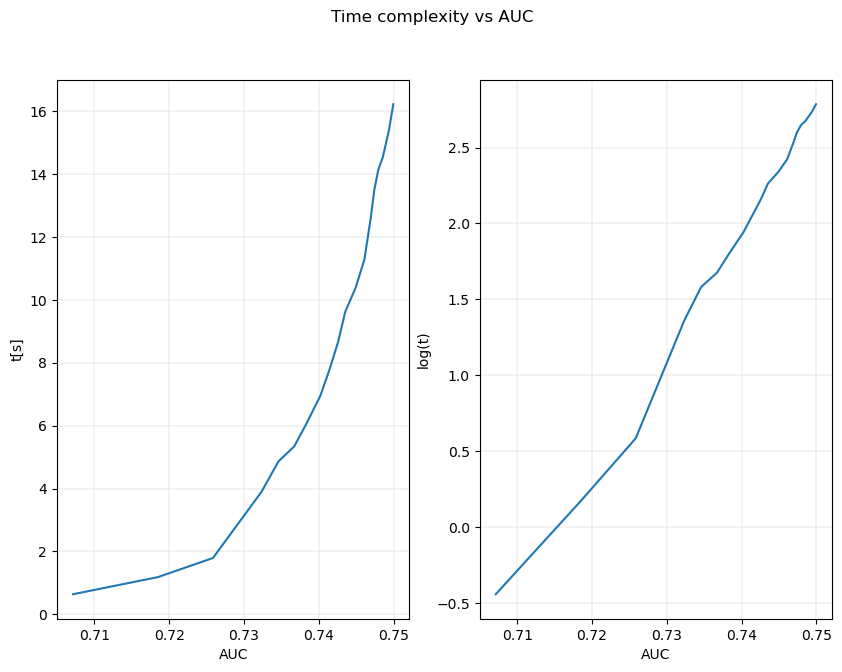

In [114]:
fig, ax = plt.subplots(1,2, figsize = (10,7))
fig.suptitle("Time complexity vs AUC")

ax[0].grid(lw = 0.2)
ax[1].grid(lw = 0.2)

ax[0].set_xlabel("AUC")
ax[0].set_ylabel("t[s]")
ax[0].plot(auc_metrics, time_complexity)

log_time = np.log(time_complexity)
ax[1].set_xlabel("AUC")
ax[1].set_ylabel("log(t)")
ax[1].plot(auc_metrics, log_time)

## Impact of input parameters
vsako dimenzijo bom postavil na nič in pogledal kakšna je razlika pri loss funkciji = AUC

In [137]:
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))
x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())
bdt =set_parameters(10, 100)# random default values
y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
auc_default = AUC_score(y_val,y_score)

auc_differences = dict()

for col in x_train:
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    x_train.drop(col, axis=1, inplace = True)
    x_test.drop(col, axis=1, inplace = True)
    # ready the data for Catboost
    data_names = list(data_fnames)
    data_names.remove(col)
    pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_names)
    pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_names)
    bdt = set_parameters(10, 100)# random default values
    y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
    auc_differences[col] = auc_default- AUC_score(y_val,y_score)

Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']
0:	test: 0.7133874	best: 0.7133874 (0)	total: 8.49ms	remaining: 841ms
1:	test: 0.7264490	best: 0.7264490 (1)	total: 18.5ms	remaining: 906ms
2:	test: 0.7287567	best: 0.7287567 (2)	total: 27.9ms	remaining: 901ms
3:	test: 0.7304055	best: 0.7304055 (3)	total: 37.2ms	remaining: 893ms
4:	test: 0.7304186	best: 0.7304186 (4)	total: 46.4ms	remaining: 882ms
5:	test: 0.7302890	best: 0.7304186 (4)	total: 56.3ms	remaining: 882ms
6:	test: 0.7305969	best: 0.7305969 (6)	total: 65.6ms	remaining: 872ms
7:	test: 0.7308614	best: 0.7308614 (7)	total: 75.6ms	remaining: 870ms
8:	test: 0.7309642	best: 0.7309642 (8)	total: 86ms	remaining: 870ms
9:	test: 0.7313960	best: 0.7313960 (9)	total: 95.8ms	remaining: 862ms
10:	test: 0.7314873	best: 0.7314873 (10)	total: 106ms	remaining: 856ms
11:	

21:	test: 0.7321740	best: 0.7322191 (20)	total: 210ms	remaining: 746ms
22:	test: 0.7323946	best: 0.7323946 (22)	total: 220ms	remaining: 738ms
23:	test: 0.7323412	best: 0.7323946 (22)	total: 231ms	remaining: 731ms
24:	test: 0.7324856	best: 0.7324856 (24)	total: 241ms	remaining: 723ms
25:	test: 0.7325500	best: 0.7325500 (25)	total: 250ms	remaining: 712ms
26:	test: 0.7327680	best: 0.7327680 (26)	total: 260ms	remaining: 702ms
27:	test: 0.7330414	best: 0.7330414 (27)	total: 269ms	remaining: 692ms
28:	test: 0.7334617	best: 0.7334617 (28)	total: 279ms	remaining: 684ms
29:	test: 0.7335229	best: 0.7335229 (29)	total: 289ms	remaining: 675ms
30:	test: 0.7334812	best: 0.7335229 (29)	total: 299ms	remaining: 666ms
31:	test: 0.7340716	best: 0.7340716 (31)	total: 309ms	remaining: 656ms
32:	test: 0.7341490	best: 0.7341490 (32)	total: 319ms	remaining: 647ms
33:	test: 0.7341832	best: 0.7341832 (33)	total: 328ms	remaining: 637ms
34:	test: 0.7344017	best: 0.7344017 (34)	total: 339ms	remaining: 629ms
35:	te

41:	test: 0.7361591	best: 0.7361591 (41)	total: 416ms	remaining: 575ms
42:	test: 0.7365510	best: 0.7365510 (42)	total: 435ms	remaining: 576ms
43:	test: 0.7367485	best: 0.7367485 (43)	total: 447ms	remaining: 569ms
44:	test: 0.7367858	best: 0.7367858 (44)	total: 457ms	remaining: 559ms
45:	test: 0.7371423	best: 0.7371423 (45)	total: 466ms	remaining: 547ms
46:	test: 0.7374014	best: 0.7374014 (46)	total: 477ms	remaining: 537ms
47:	test: 0.7374403	best: 0.7374403 (47)	total: 489ms	remaining: 530ms
48:	test: 0.7374566	best: 0.7374566 (48)	total: 500ms	remaining: 521ms
49:	test: 0.7376329	best: 0.7376329 (49)	total: 511ms	remaining: 511ms
50:	test: 0.7378211	best: 0.7378211 (50)	total: 522ms	remaining: 501ms
51:	test: 0.7380040	best: 0.7380040 (51)	total: 533ms	remaining: 492ms
52:	test: 0.7381667	best: 0.7381667 (52)	total: 543ms	remaining: 482ms
53:	test: 0.7381610	best: 0.7381667 (52)	total: 554ms	remaining: 472ms
54:	test: 0.7383732	best: 0.7383732 (54)	total: 566ms	remaining: 463ms
55:	te

68:	test: 0.7462323	best: 0.7462323 (68)	total: 692ms	remaining: 311ms
69:	test: 0.7468007	best: 0.7468007 (69)	total: 703ms	remaining: 301ms
70:	test: 0.7470857	best: 0.7470857 (70)	total: 712ms	remaining: 291ms
71:	test: 0.7471086	best: 0.7471086 (71)	total: 722ms	remaining: 281ms
72:	test: 0.7472671	best: 0.7472671 (72)	total: 732ms	remaining: 271ms
73:	test: 0.7474172	best: 0.7474172 (73)	total: 742ms	remaining: 261ms
74:	test: 0.7475924	best: 0.7475924 (74)	total: 752ms	remaining: 251ms
75:	test: 0.7477515	best: 0.7477515 (75)	total: 762ms	remaining: 240ms
76:	test: 0.7478088	best: 0.7478088 (76)	total: 772ms	remaining: 230ms
77:	test: 0.7482097	best: 0.7482097 (77)	total: 781ms	remaining: 220ms
78:	test: 0.7483576	best: 0.7483576 (78)	total: 791ms	remaining: 210ms
79:	test: 0.7485940	best: 0.7485940 (79)	total: 801ms	remaining: 200ms
80:	test: 0.7487696	best: 0.7487696 (80)	total: 811ms	remaining: 190ms
81:	test: 0.7489695	best: 0.7489695 (81)	total: 821ms	remaining: 180ms
82:	te

0:	test: 0.7137672	best: 0.7137672 (0)	total: 8.84ms	remaining: 875ms
1:	test: 0.7243267	best: 0.7243267 (1)	total: 20ms	remaining: 979ms
2:	test: 0.7258441	best: 0.7258441 (2)	total: 29.5ms	remaining: 953ms
3:	test: 0.7269024	best: 0.7269024 (3)	total: 39.4ms	remaining: 945ms
4:	test: 0.7289169	best: 0.7289169 (4)	total: 48.8ms	remaining: 928ms
5:	test: 0.7294222	best: 0.7294222 (5)	total: 58.5ms	remaining: 916ms
6:	test: 0.7299494	best: 0.7299494 (6)	total: 67.9ms	remaining: 902ms
7:	test: 0.7301133	best: 0.7301133 (7)	total: 77.4ms	remaining: 890ms
8:	test: 0.7307830	best: 0.7307830 (8)	total: 86.6ms	remaining: 876ms
9:	test: 0.7304235	best: 0.7307830 (8)	total: 96.1ms	remaining: 865ms
10:	test: 0.7302379	best: 0.7307830 (8)	total: 106ms	remaining: 855ms
11:	test: 0.7303436	best: 0.7307830 (8)	total: 115ms	remaining: 845ms
12:	test: 0.7306546	best: 0.7307830 (8)	total: 125ms	remaining: 839ms
13:	test: 0.7307179	best: 0.7307830 (8)	total: 135ms	remaining: 830ms
14:	test: 0.7309503	be

20:	test: 0.7320402	best: 0.7320952 (19)	total: 211ms	remaining: 794ms
21:	test: 0.7318675	best: 0.7320952 (19)	total: 223ms	remaining: 790ms
22:	test: 0.7320036	best: 0.7320952 (19)	total: 235ms	remaining: 786ms
23:	test: 0.7321091	best: 0.7321091 (23)	total: 246ms	remaining: 778ms
24:	test: 0.7321163	best: 0.7321163 (24)	total: 257ms	remaining: 771ms
25:	test: 0.7320891	best: 0.7321163 (24)	total: 267ms	remaining: 759ms
26:	test: 0.7324271	best: 0.7324271 (26)	total: 277ms	remaining: 748ms
27:	test: 0.7326135	best: 0.7326135 (27)	total: 287ms	remaining: 737ms
28:	test: 0.7331132	best: 0.7331132 (28)	total: 297ms	remaining: 727ms
29:	test: 0.7331065	best: 0.7331132 (28)	total: 307ms	remaining: 716ms
30:	test: 0.7333426	best: 0.7333426 (30)	total: 317ms	remaining: 706ms
31:	test: 0.7334145	best: 0.7334145 (31)	total: 327ms	remaining: 695ms
32:	test: 0.7337688	best: 0.7337688 (32)	total: 337ms	remaining: 684ms
33:	test: 0.7338090	best: 0.7338090 (33)	total: 347ms	remaining: 674ms
34:	te

45:	test: 0.7372822	best: 0.7372822 (45)	total: 481ms	remaining: 565ms
46:	test: 0.7375015	best: 0.7375015 (46)	total: 492ms	remaining: 554ms
47:	test: 0.7378469	best: 0.7378469 (47)	total: 502ms	remaining: 544ms
48:	test: 0.7379611	best: 0.7379611 (48)	total: 513ms	remaining: 534ms
49:	test: 0.7381128	best: 0.7381128 (49)	total: 523ms	remaining: 523ms
50:	test: 0.7381895	best: 0.7381895 (50)	total: 535ms	remaining: 514ms
51:	test: 0.7384973	best: 0.7384973 (51)	total: 546ms	remaining: 504ms
52:	test: 0.7386098	best: 0.7386098 (52)	total: 557ms	remaining: 494ms
53:	test: 0.7387429	best: 0.7387429 (53)	total: 567ms	remaining: 483ms
54:	test: 0.7389303	best: 0.7389303 (54)	total: 577ms	remaining: 472ms
55:	test: 0.7390249	best: 0.7390249 (55)	total: 586ms	remaining: 460ms
56:	test: 0.7389441	best: 0.7390249 (55)	total: 595ms	remaining: 449ms
57:	test: 0.7392495	best: 0.7392495 (57)	total: 605ms	remaining: 438ms
58:	test: 0.7392773	best: 0.7392773 (58)	total: 615ms	remaining: 427ms
59:	te

76:	test: 0.7427101	best: 0.7427101 (76)	total: 838ms	remaining: 250ms
77:	test: 0.7430601	best: 0.7430601 (77)	total: 849ms	remaining: 239ms
78:	test: 0.7432918	best: 0.7432918 (78)	total: 858ms	remaining: 228ms
79:	test: 0.7435161	best: 0.7435161 (79)	total: 868ms	remaining: 217ms
80:	test: 0.7436534	best: 0.7436534 (80)	total: 878ms	remaining: 206ms
81:	test: 0.7438913	best: 0.7438913 (81)	total: 887ms	remaining: 195ms
82:	test: 0.7441643	best: 0.7441643 (82)	total: 895ms	remaining: 183ms
83:	test: 0.7445125	best: 0.7445125 (83)	total: 905ms	remaining: 172ms
84:	test: 0.7447373	best: 0.7447373 (84)	total: 915ms	remaining: 162ms
85:	test: 0.7448123	best: 0.7448123 (85)	total: 926ms	remaining: 151ms
86:	test: 0.7448956	best: 0.7448956 (86)	total: 935ms	remaining: 140ms
87:	test: 0.7452159	best: 0.7452159 (87)	total: 945ms	remaining: 129ms
88:	test: 0.7453601	best: 0.7453601 (88)	total: 955ms	remaining: 118ms
89:	test: 0.7457447	best: 0.7457447 (89)	total: 964ms	remaining: 107ms
90:	te

0:	test: 0.7107098	best: 0.7107098 (0)	total: 9.57ms	remaining: 947ms
1:	test: 0.7165293	best: 0.7165293 (1)	total: 18.8ms	remaining: 923ms
2:	test: 0.7202295	best: 0.7202295 (2)	total: 28.5ms	remaining: 920ms
3:	test: 0.7200717	best: 0.7202295 (2)	total: 39ms	remaining: 936ms
4:	test: 0.7262652	best: 0.7262652 (4)	total: 48.5ms	remaining: 922ms
5:	test: 0.7258376	best: 0.7262652 (4)	total: 58.1ms	remaining: 910ms
6:	test: 0.7262575	best: 0.7262652 (4)	total: 68.1ms	remaining: 905ms
7:	test: 0.7256643	best: 0.7262652 (4)	total: 77.5ms	remaining: 891ms
8:	test: 0.7281558	best: 0.7281558 (8)	total: 87ms	remaining: 880ms
9:	test: 0.7287371	best: 0.7287371 (9)	total: 101ms	remaining: 905ms
10:	test: 0.7289982	best: 0.7289982 (10)	total: 111ms	remaining: 897ms
11:	test: 0.7292422	best: 0.7292422 (11)	total: 120ms	remaining: 881ms
12:	test: 0.7303529	best: 0.7303529 (12)	total: 129ms	remaining: 865ms
13:	test: 0.7307051	best: 0.7307051 (13)	total: 139ms	remaining: 855ms
14:	test: 0.7308940	b

21:	test: 0.7321202	best: 0.7321202 (21)	total: 212ms	remaining: 751ms
22:	test: 0.7326168	best: 0.7326168 (22)	total: 223ms	remaining: 747ms
23:	test: 0.7329710	best: 0.7329710 (23)	total: 233ms	remaining: 736ms
24:	test: 0.7331736	best: 0.7331736 (24)	total: 242ms	remaining: 727ms
25:	test: 0.7330746	best: 0.7331736 (24)	total: 252ms	remaining: 717ms
26:	test: 0.7331823	best: 0.7331823 (26)	total: 262ms	remaining: 709ms
27:	test: 0.7333352	best: 0.7333352 (27)	total: 272ms	remaining: 700ms
28:	test: 0.7339004	best: 0.7339004 (28)	total: 282ms	remaining: 689ms
29:	test: 0.7339565	best: 0.7339565 (29)	total: 291ms	remaining: 680ms
30:	test: 0.7340201	best: 0.7340201 (30)	total: 301ms	remaining: 670ms
31:	test: 0.7342263	best: 0.7342263 (31)	total: 310ms	remaining: 659ms
32:	test: 0.7347070	best: 0.7347070 (32)	total: 320ms	remaining: 650ms
33:	test: 0.7347666	best: 0.7347666 (33)	total: 330ms	remaining: 641ms
34:	test: 0.7348794	best: 0.7348794 (34)	total: 340ms	remaining: 631ms
35:	te

42:	test: 0.7383870	best: 0.7383870 (42)	total: 410ms	remaining: 544ms
43:	test: 0.7387174	best: 0.7387174 (43)	total: 420ms	remaining: 535ms
44:	test: 0.7388030	best: 0.7388030 (44)	total: 430ms	remaining: 526ms
45:	test: 0.7393019	best: 0.7393019 (45)	total: 439ms	remaining: 516ms
46:	test: 0.7392966	best: 0.7393019 (45)	total: 448ms	remaining: 506ms
47:	test: 0.7397155	best: 0.7397155 (47)	total: 458ms	remaining: 496ms
48:	test: 0.7397664	best: 0.7397664 (48)	total: 467ms	remaining: 486ms
49:	test: 0.7398210	best: 0.7398210 (49)	total: 477ms	remaining: 477ms
50:	test: 0.7400594	best: 0.7400594 (50)	total: 487ms	remaining: 468ms
51:	test: 0.7402945	best: 0.7402945 (51)	total: 497ms	remaining: 459ms
52:	test: 0.7403775	best: 0.7403775 (52)	total: 506ms	remaining: 449ms
53:	test: 0.7404608	best: 0.7404608 (53)	total: 516ms	remaining: 440ms
54:	test: 0.7405439	best: 0.7405439 (54)	total: 528ms	remaining: 432ms
55:	test: 0.7407223	best: 0.7407223 (55)	total: 537ms	remaining: 422ms
56:	te

57:	test: 0.7311547	best: 0.7311547 (57)	total: 607ms	remaining: 439ms
58:	test: 0.7315995	best: 0.7315995 (58)	total: 617ms	remaining: 429ms
59:	test: 0.7317196	best: 0.7317196 (59)	total: 629ms	remaining: 420ms
60:	test: 0.7318901	best: 0.7318901 (60)	total: 641ms	remaining: 410ms
61:	test: 0.7321436	best: 0.7321436 (61)	total: 651ms	remaining: 399ms
62:	test: 0.7325334	best: 0.7325334 (62)	total: 661ms	remaining: 388ms
63:	test: 0.7326917	best: 0.7326917 (63)	total: 670ms	remaining: 377ms
64:	test: 0.7327791	best: 0.7327791 (64)	total: 680ms	remaining: 366ms
65:	test: 0.7328939	best: 0.7328939 (65)	total: 691ms	remaining: 356ms
66:	test: 0.7330958	best: 0.7330958 (66)	total: 702ms	remaining: 346ms
67:	test: 0.7333052	best: 0.7333052 (67)	total: 712ms	remaining: 335ms
68:	test: 0.7336030	best: 0.7336030 (68)	total: 722ms	remaining: 325ms
69:	test: 0.7339439	best: 0.7339439 (69)	total: 732ms	remaining: 314ms
70:	test: 0.7341586	best: 0.7341586 (70)	total: 741ms	remaining: 303ms
71:	te

83:	test: 0.7464387	best: 0.7464387 (83)	total: 873ms	remaining: 166ms
84:	test: 0.7466916	best: 0.7466916 (84)	total: 883ms	remaining: 156ms
85:	test: 0.7468634	best: 0.7468634 (85)	total: 892ms	remaining: 145ms
86:	test: 0.7469740	best: 0.7469740 (86)	total: 904ms	remaining: 135ms
87:	test: 0.7470213	best: 0.7470213 (87)	total: 914ms	remaining: 125ms
88:	test: 0.7471193	best: 0.7471193 (88)	total: 924ms	remaining: 114ms
89:	test: 0.7473977	best: 0.7473977 (89)	total: 934ms	remaining: 104ms
90:	test: 0.7475858	best: 0.7475858 (90)	total: 944ms	remaining: 93.4ms
91:	test: 0.7476782	best: 0.7476782 (91)	total: 954ms	remaining: 82.9ms
92:	test: 0.7477799	best: 0.7477799 (92)	total: 965ms	remaining: 72.6ms
93:	test: 0.7478491	best: 0.7478491 (93)	total: 975ms	remaining: 62.2ms
94:	test: 0.7481670	best: 0.7481670 (94)	total: 987ms	remaining: 52ms
95:	test: 0.7483111	best: 0.7483111 (95)	total: 998ms	remaining: 41.6ms
96:	test: 0.7485808	best: 0.7485808 (96)	total: 1.01s	remaining: 31.2ms
9

0:	test: 0.6844215	best: 0.6844215 (0)	total: 10.3ms	remaining: 1.02s
1:	test: 0.6924660	best: 0.6924660 (1)	total: 20.3ms	remaining: 993ms
2:	test: 0.6928729	best: 0.6928729 (2)	total: 29.5ms	remaining: 955ms
3:	test: 0.6933535	best: 0.6933535 (3)	total: 39.5ms	remaining: 948ms
4:	test: 0.6930071	best: 0.6933535 (3)	total: 51.1ms	remaining: 970ms
5:	test: 0.6943906	best: 0.6943906 (5)	total: 61.3ms	remaining: 961ms
6:	test: 0.6945206	best: 0.6945206 (6)	total: 72.2ms	remaining: 959ms
7:	test: 0.6945415	best: 0.6945415 (7)	total: 84.2ms	remaining: 969ms
8:	test: 0.6949142	best: 0.6949142 (8)	total: 99.2ms	remaining: 1s
9:	test: 0.6947555	best: 0.6949142 (8)	total: 109ms	remaining: 985ms
10:	test: 0.6947234	best: 0.6949142 (8)	total: 120ms	remaining: 972ms
11:	test: 0.6962914	best: 0.6962914 (11)	total: 130ms	remaining: 952ms
12:	test: 0.6964139	best: 0.6964139 (12)	total: 139ms	remaining: 930ms
13:	test: 0.6969439	best: 0.6969439 (13)	total: 148ms	remaining: 909ms
14:	test: 0.6968268	b

19:	test: 0.7263711	best: 0.7263711 (19)	total: 210ms	remaining: 838ms
20:	test: 0.7266510	best: 0.7266510 (20)	total: 219ms	remaining: 824ms
21:	test: 0.7267874	best: 0.7267874 (21)	total: 229ms	remaining: 813ms
22:	test: 0.7267416	best: 0.7267874 (21)	total: 239ms	remaining: 799ms
23:	test: 0.7267544	best: 0.7267874 (21)	total: 248ms	remaining: 786ms
24:	test: 0.7268328	best: 0.7268328 (24)	total: 258ms	remaining: 774ms
25:	test: 0.7269602	best: 0.7269602 (25)	total: 269ms	remaining: 764ms
26:	test: 0.7270025	best: 0.7270025 (26)	total: 279ms	remaining: 754ms
27:	test: 0.7271658	best: 0.7271658 (27)	total: 289ms	remaining: 744ms
28:	test: 0.7271789	best: 0.7271789 (28)	total: 299ms	remaining: 732ms
29:	test: 0.7272271	best: 0.7272271 (29)	total: 310ms	remaining: 724ms
30:	test: 0.7274070	best: 0.7274070 (30)	total: 320ms	remaining: 712ms
31:	test: 0.7274769	best: 0.7274769 (31)	total: 329ms	remaining: 700ms
32:	test: 0.7275044	best: 0.7275044 (32)	total: 339ms	remaining: 689ms
33:	te

39:	test: 0.7218899	best: 0.7218899 (39)	total: 422ms	remaining: 633ms
40:	test: 0.7219643	best: 0.7219643 (40)	total: 434ms	remaining: 624ms
41:	test: 0.7219817	best: 0.7219817 (41)	total: 444ms	remaining: 613ms
42:	test: 0.7220271	best: 0.7220271 (42)	total: 454ms	remaining: 602ms
43:	test: 0.7219908	best: 0.7220271 (42)	total: 464ms	remaining: 591ms
44:	test: 0.7221712	best: 0.7221712 (44)	total: 473ms	remaining: 578ms
45:	test: 0.7225285	best: 0.7225285 (45)	total: 483ms	remaining: 566ms
46:	test: 0.7225803	best: 0.7225803 (46)	total: 492ms	remaining: 555ms
47:	test: 0.7227185	best: 0.7227185 (47)	total: 502ms	remaining: 544ms
48:	test: 0.7229922	best: 0.7229922 (48)	total: 517ms	remaining: 538ms
49:	test: 0.7234195	best: 0.7234195 (49)	total: 527ms	remaining: 527ms
50:	test: 0.7235208	best: 0.7235208 (50)	total: 537ms	remaining: 516ms
51:	test: 0.7236632	best: 0.7236632 (51)	total: 549ms	remaining: 507ms
52:	test: 0.7239947	best: 0.7239947 (52)	total: 564ms	remaining: 500ms
53:	te

Text(0, 0.5, '$\\Delta$AUC')

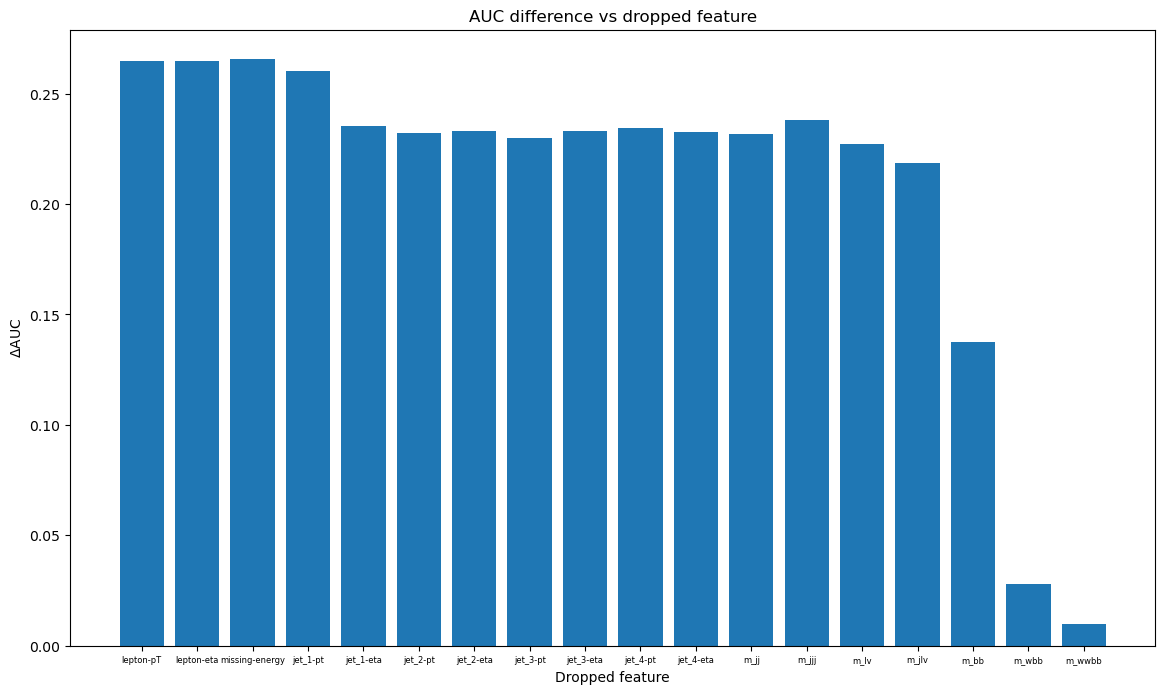

In [190]:
%matplotlib inline
plt.figure(figsize=(14, 8))
plt.title("AUC difference vs dropped feature")
plt.bar(auc_differences.keys(), auc_differences.values())
plt.rc('xtick', labelsize=6)
plt.xlabel("Dropped feature")
plt.ylabel("$\Delta$AUC")

In [252]:
# how many input dimensions do we need?
from sklearn.decomposition import PCA, KernelPCA

def PCA_linear(train, test,x_val, N):# only transform input
    pca = PCA(n_components=N)
    pca.fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    x_val = pca.transform(x_val)
    return train, test, x_val

def PCA_rbf(train, test):
    pca = KernelPCA(n_components=20, kernel="rbf")
    pca.fit(train)
    train = pca.transform(train)
    test = pca.transform(test)
    return train, test

In [259]:
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())
bdt =set_parameters(10, 100)# random default values
y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
auc_default = AUC_score(y_val,y_score)

auc_differences = dict()

for i in range(1, x_train.shape[1]):
    x_val,y_val=split_xy(hdata['valid'])
    x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
    
    x_train, x_test, x_val = PCA_linear(x_train, x_test, x_val, i)# at least one dimension
    
    # ready the data for Catboost
    pool_train = Pool(data=x_train, label = y_train.to_numpy())
    pool_test = Pool(data=x_test, label=y_test.to_numpy())
    bdt = set_parameters(10, 100) # random default values
    y_score=bdt.predict_proba(x_val)[:,1]
    auc_differences[i] = auc_default- AUC_score(y_val,y_score)

0:	test: 0.7170755	best: 0.7170755 (0)	total: 7.95ms	remaining: 787ms
1:	test: 0.7267174	best: 0.7267174 (1)	total: 16.2ms	remaining: 794ms
2:	test: 0.7271224	best: 0.7271224 (2)	total: 25.6ms	remaining: 827ms
3:	test: 0.7292786	best: 0.7292786 (3)	total: 34.8ms	remaining: 836ms
4:	test: 0.7296973	best: 0.7296973 (4)	total: 44.9ms	remaining: 853ms
5:	test: 0.7301458	best: 0.7301458 (5)	total: 55.5ms	remaining: 869ms
6:	test: 0.7299797	best: 0.7301458 (5)	total: 65.3ms	remaining: 868ms
7:	test: 0.7304051	best: 0.7304051 (7)	total: 75.2ms	remaining: 865ms
8:	test: 0.7303928	best: 0.7304051 (7)	total: 84.6ms	remaining: 855ms
9:	test: 0.7303445	best: 0.7304051 (7)	total: 94ms	remaining: 846ms
10:	test: 0.7301242	best: 0.7304051 (7)	total: 104ms	remaining: 842ms
11:	test: 0.7306354	best: 0.7306354 (11)	total: 114ms	remaining: 834ms
12:	test: 0.7310944	best: 0.7310944 (12)	total: 124ms	remaining: 828ms
13:	test: 0.7308891	best: 0.7310944 (12)	total: 134ms	remaining: 824ms
14:	test: 0.7313321

0:	test: 0.5295278	best: 0.5295278 (0)	total: 23.7ms	remaining: 2.35s
1:	test: 0.5304443	best: 0.5304443 (1)	total: 56.1ms	remaining: 2.75s
2:	test: 0.5315477	best: 0.5315477 (2)	total: 68.8ms	remaining: 2.22s
3:	test: 0.5317379	best: 0.5317379 (3)	total: 77.4ms	remaining: 1.86s
4:	test: 0.5318543	best: 0.5318543 (4)	total: 87.7ms	remaining: 1.67s
5:	test: 0.5317876	best: 0.5318543 (4)	total: 97.1ms	remaining: 1.52s
6:	test: 0.5326114	best: 0.5326114 (6)	total: 108ms	remaining: 1.43s
7:	test: 0.5328646	best: 0.5328646 (7)	total: 115ms	remaining: 1.32s
8:	test: 0.5324363	best: 0.5328646 (7)	total: 125ms	remaining: 1.27s
9:	test: 0.5323447	best: 0.5328646 (7)	total: 138ms	remaining: 1.24s
10:	test: 0.5333450	best: 0.5333450 (10)	total: 148ms	remaining: 1.19s
11:	test: 0.5331631	best: 0.5333450 (10)	total: 157ms	remaining: 1.15s
12:	test: 0.5332909	best: 0.5333450 (10)	total: 165ms	remaining: 1.1s
13:	test: 0.5329624	best: 0.5333450 (10)	total: 174ms	remaining: 1.07s
14:	test: 0.5331393	b

50:	test: 0.5564032	best: 0.5564204 (46)	total: 438ms	remaining: 420ms
51:	test: 0.5564227	best: 0.5564227 (51)	total: 447ms	remaining: 413ms
52:	test: 0.5564274	best: 0.5564274 (52)	total: 455ms	remaining: 404ms
53:	test: 0.5564107	best: 0.5564274 (52)	total: 464ms	remaining: 395ms
54:	test: 0.5564655	best: 0.5564655 (54)	total: 472ms	remaining: 386ms
55:	test: 0.5564774	best: 0.5564774 (55)	total: 480ms	remaining: 377ms
56:	test: 0.5564695	best: 0.5564774 (55)	total: 488ms	remaining: 368ms
57:	test: 0.5564183	best: 0.5564774 (55)	total: 497ms	remaining: 360ms
58:	test: 0.5564498	best: 0.5564774 (55)	total: 505ms	remaining: 351ms
59:	test: 0.5564768	best: 0.5564774 (55)	total: 513ms	remaining: 342ms
60:	test: 0.5564767	best: 0.5564774 (55)	total: 521ms	remaining: 333ms
61:	test: 0.5564988	best: 0.5564988 (61)	total: 529ms	remaining: 324ms
62:	test: 0.5565422	best: 0.5565422 (62)	total: 537ms	remaining: 315ms
63:	test: 0.5565336	best: 0.5565422 (62)	total: 545ms	remaining: 307ms
64:	te

71:	test: 0.5604018	best: 0.5604018 (71)	total: 626ms	remaining: 243ms
72:	test: 0.5603790	best: 0.5604018 (71)	total: 634ms	remaining: 235ms
73:	test: 0.5603809	best: 0.5604018 (71)	total: 643ms	remaining: 226ms
74:	test: 0.5603761	best: 0.5604018 (71)	total: 651ms	remaining: 217ms
75:	test: 0.5603863	best: 0.5604018 (71)	total: 659ms	remaining: 208ms
76:	test: 0.5603685	best: 0.5604018 (71)	total: 668ms	remaining: 200ms
77:	test: 0.5603665	best: 0.5604018 (71)	total: 676ms	remaining: 191ms
78:	test: 0.5604047	best: 0.5604047 (78)	total: 687ms	remaining: 183ms
79:	test: 0.5604102	best: 0.5604102 (79)	total: 696ms	remaining: 174ms
80:	test: 0.5604132	best: 0.5604132 (80)	total: 704ms	remaining: 165ms
81:	test: 0.5605118	best: 0.5605118 (81)	total: 713ms	remaining: 156ms
82:	test: 0.5605602	best: 0.5605602 (82)	total: 721ms	remaining: 148ms
83:	test: 0.5605848	best: 0.5605848 (83)	total: 729ms	remaining: 139ms
84:	test: 0.5606515	best: 0.5606515 (84)	total: 736ms	remaining: 130ms
85:	te

70:	test: 0.5958212	best: 0.5958212 (70)	total: 632ms	remaining: 258ms
71:	test: 0.5959239	best: 0.5959239 (71)	total: 641ms	remaining: 249ms
72:	test: 0.5959083	best: 0.5959239 (71)	total: 650ms	remaining: 240ms
73:	test: 0.5960639	best: 0.5960639 (73)	total: 658ms	remaining: 231ms
74:	test: 0.5961916	best: 0.5961916 (74)	total: 666ms	remaining: 222ms
75:	test: 0.5963354	best: 0.5963354 (75)	total: 674ms	remaining: 213ms
76:	test: 0.5963305	best: 0.5963354 (75)	total: 682ms	remaining: 204ms
77:	test: 0.5963670	best: 0.5963670 (77)	total: 691ms	remaining: 195ms
78:	test: 0.5964436	best: 0.5964436 (78)	total: 700ms	remaining: 186ms
79:	test: 0.5964969	best: 0.5964969 (79)	total: 708ms	remaining: 177ms
80:	test: 0.5965540	best: 0.5965540 (80)	total: 715ms	remaining: 168ms
81:	test: 0.5965556	best: 0.5965556 (81)	total: 724ms	remaining: 159ms
82:	test: 0.5965624	best: 0.5965624 (82)	total: 734ms	remaining: 150ms
83:	test: 0.5966348	best: 0.5966348 (83)	total: 743ms	remaining: 142ms
84:	te

87:	test: 0.6054494	best: 0.6054697 (86)	total: 824ms	remaining: 112ms
88:	test: 0.6056284	best: 0.6056284 (88)	total: 833ms	remaining: 103ms
89:	test: 0.6056710	best: 0.6056710 (89)	total: 842ms	remaining: 93.6ms
90:	test: 0.6059606	best: 0.6059606 (90)	total: 851ms	remaining: 84.2ms
91:	test: 0.6059664	best: 0.6059664 (91)	total: 860ms	remaining: 74.8ms
92:	test: 0.6059994	best: 0.6059994 (92)	total: 868ms	remaining: 65.4ms
93:	test: 0.6061153	best: 0.6061153 (93)	total: 878ms	remaining: 56ms
94:	test: 0.6062737	best: 0.6062737 (94)	total: 886ms	remaining: 46.6ms
95:	test: 0.6063213	best: 0.6063213 (95)	total: 894ms	remaining: 37.3ms
96:	test: 0.6064512	best: 0.6064512 (96)	total: 902ms	remaining: 27.9ms
97:	test: 0.6064487	best: 0.6064512 (96)	total: 911ms	remaining: 18.6ms
98:	test: 0.6065193	best: 0.6065193 (98)	total: 918ms	remaining: 9.27ms
99:	test: 0.6065604	best: 0.6065604 (99)	total: 927ms	remaining: 0us

bestTest = 0.6065604315
bestIteration = 99

0:	test: 0.5908081	best: 0

21:	test: 0.6047946	best: 0.6047946 (21)	total: 220ms	remaining: 779ms
22:	test: 0.6049197	best: 0.6049197 (22)	total: 229ms	remaining: 768ms
23:	test: 0.6050897	best: 0.6050897 (23)	total: 239ms	remaining: 758ms
24:	test: 0.6051150	best: 0.6051150 (24)	total: 249ms	remaining: 747ms
25:	test: 0.6053188	best: 0.6053188 (25)	total: 257ms	remaining: 733ms
26:	test: 0.6053593	best: 0.6053593 (26)	total: 267ms	remaining: 721ms
27:	test: 0.6055366	best: 0.6055366 (27)	total: 276ms	remaining: 710ms
28:	test: 0.6058530	best: 0.6058530 (28)	total: 292ms	remaining: 714ms
29:	test: 0.6058975	best: 0.6058975 (29)	total: 301ms	remaining: 703ms
30:	test: 0.6059668	best: 0.6059668 (30)	total: 311ms	remaining: 691ms
31:	test: 0.6064138	best: 0.6064138 (31)	total: 319ms	remaining: 678ms
32:	test: 0.6066495	best: 0.6066495 (32)	total: 328ms	remaining: 665ms
33:	test: 0.6067791	best: 0.6067791 (33)	total: 336ms	remaining: 652ms
34:	test: 0.6067604	best: 0.6067791 (33)	total: 344ms	remaining: 640ms
35:	te

45:	test: 0.6191228	best: 0.6191228 (45)	total: 417ms	remaining: 490ms
46:	test: 0.6195578	best: 0.6195578 (46)	total: 427ms	remaining: 482ms
47:	test: 0.6196709	best: 0.6196709 (47)	total: 437ms	remaining: 474ms
48:	test: 0.6197900	best: 0.6197900 (48)	total: 446ms	remaining: 464ms
49:	test: 0.6198404	best: 0.6198404 (49)	total: 455ms	remaining: 455ms
50:	test: 0.6197957	best: 0.6198404 (49)	total: 464ms	remaining: 446ms
51:	test: 0.6199058	best: 0.6199058 (51)	total: 473ms	remaining: 436ms
52:	test: 0.6202695	best: 0.6202695 (52)	total: 481ms	remaining: 427ms
53:	test: 0.6204230	best: 0.6204230 (53)	total: 491ms	remaining: 418ms
54:	test: 0.6204277	best: 0.6204277 (54)	total: 500ms	remaining: 409ms
55:	test: 0.6205516	best: 0.6205516 (55)	total: 509ms	remaining: 400ms
56:	test: 0.6207972	best: 0.6207972 (56)	total: 517ms	remaining: 390ms
57:	test: 0.6209042	best: 0.6209042 (57)	total: 527ms	remaining: 381ms
58:	test: 0.6208699	best: 0.6209042 (57)	total: 535ms	remaining: 372ms
59:	te

66:	test: 0.6294388	best: 0.6294388 (66)	total: 613ms	remaining: 302ms
67:	test: 0.6297739	best: 0.6297739 (67)	total: 624ms	remaining: 294ms
68:	test: 0.6301469	best: 0.6301469 (68)	total: 633ms	remaining: 284ms
69:	test: 0.6303571	best: 0.6303571 (69)	total: 642ms	remaining: 275ms
70:	test: 0.6303633	best: 0.6303633 (70)	total: 651ms	remaining: 266ms
71:	test: 0.6304017	best: 0.6304017 (71)	total: 659ms	remaining: 256ms
72:	test: 0.6303820	best: 0.6304017 (71)	total: 668ms	remaining: 247ms
73:	test: 0.6305715	best: 0.6305715 (73)	total: 677ms	remaining: 238ms
74:	test: 0.6306582	best: 0.6306582 (74)	total: 686ms	remaining: 229ms
75:	test: 0.6309145	best: 0.6309145 (75)	total: 695ms	remaining: 219ms
76:	test: 0.6311593	best: 0.6311593 (76)	total: 705ms	remaining: 211ms
77:	test: 0.6311660	best: 0.6311660 (77)	total: 714ms	remaining: 202ms
78:	test: 0.6313922	best: 0.6313922 (78)	total: 727ms	remaining: 193ms
79:	test: 0.6313458	best: 0.6313922 (78)	total: 737ms	remaining: 184ms
80:	te

88:	test: 0.6511657	best: 0.6511657 (88)	total: 822ms	remaining: 102ms
89:	test: 0.6513065	best: 0.6513065 (89)	total: 831ms	remaining: 92.4ms
90:	test: 0.6515405	best: 0.6515405 (90)	total: 840ms	remaining: 83.1ms
91:	test: 0.6516957	best: 0.6516957 (91)	total: 850ms	remaining: 73.9ms
92:	test: 0.6517728	best: 0.6517728 (92)	total: 858ms	remaining: 64.6ms
93:	test: 0.6519801	best: 0.6519801 (93)	total: 867ms	remaining: 55.4ms
94:	test: 0.6520641	best: 0.6520641 (94)	total: 876ms	remaining: 46.1ms
95:	test: 0.6522004	best: 0.6522004 (95)	total: 885ms	remaining: 36.9ms
96:	test: 0.6523444	best: 0.6523444 (96)	total: 894ms	remaining: 27.6ms
97:	test: 0.6524837	best: 0.6524837 (97)	total: 903ms	remaining: 18.4ms
98:	test: 0.6526410	best: 0.6526410 (98)	total: 913ms	remaining: 9.22ms
99:	test: 0.6527841	best: 0.6527841 (99)	total: 922ms	remaining: 0us

bestTest = 0.6527840729
bestIteration = 99

0:	test: 0.6138763	best: 0.6138763 (0)	total: 10.8ms	remaining: 1.07s
1:	test: 0.6264497	best: 

21:	test: 0.6729091	best: 0.6729091 (21)	total: 218ms	remaining: 774ms
22:	test: 0.6737956	best: 0.6737956 (22)	total: 228ms	remaining: 764ms
23:	test: 0.6740481	best: 0.6740481 (23)	total: 237ms	remaining: 752ms
24:	test: 0.6740827	best: 0.6740827 (24)	total: 247ms	remaining: 741ms
25:	test: 0.6742527	best: 0.6742527 (25)	total: 256ms	remaining: 729ms
26:	test: 0.6745532	best: 0.6745532 (26)	total: 265ms	remaining: 717ms
27:	test: 0.6747811	best: 0.6747811 (27)	total: 275ms	remaining: 708ms
28:	test: 0.6749681	best: 0.6749681 (28)	total: 285ms	remaining: 697ms
29:	test: 0.6749582	best: 0.6749681 (28)	total: 294ms	remaining: 685ms
30:	test: 0.6748598	best: 0.6749681 (28)	total: 303ms	remaining: 675ms
31:	test: 0.6750094	best: 0.6750094 (31)	total: 314ms	remaining: 667ms
32:	test: 0.6751714	best: 0.6751714 (32)	total: 324ms	remaining: 657ms
33:	test: 0.6754239	best: 0.6754239 (33)	total: 334ms	remaining: 649ms
34:	test: 0.6753493	best: 0.6754239 (33)	total: 344ms	remaining: 638ms
35:	te

42:	test: 0.6862670	best: 0.6862670 (42)	total: 411ms	remaining: 545ms
43:	test: 0.6863229	best: 0.6863229 (43)	total: 422ms	remaining: 537ms
44:	test: 0.6864325	best: 0.6864325 (44)	total: 433ms	remaining: 530ms
45:	test: 0.6864325	best: 0.6864325 (44)	total: 443ms	remaining: 521ms
46:	test: 0.6864378	best: 0.6864378 (46)	total: 453ms	remaining: 511ms
47:	test: 0.6864128	best: 0.6864378 (46)	total: 462ms	remaining: 500ms
48:	test: 0.6866548	best: 0.6866548 (48)	total: 471ms	remaining: 490ms
49:	test: 0.6869471	best: 0.6869471 (49)	total: 480ms	remaining: 480ms
50:	test: 0.6870968	best: 0.6870968 (50)	total: 490ms	remaining: 471ms
51:	test: 0.6871861	best: 0.6871861 (51)	total: 500ms	remaining: 461ms
52:	test: 0.6873634	best: 0.6873634 (52)	total: 510ms	remaining: 452ms
53:	test: 0.6877673	best: 0.6877673 (53)	total: 520ms	remaining: 443ms
54:	test: 0.6878079	best: 0.6878079 (54)	total: 529ms	remaining: 433ms
55:	test: 0.6880899	best: 0.6880899 (55)	total: 538ms	remaining: 423ms
56:	te

62:	test: 0.6955265	best: 0.6955265 (62)	total: 611ms	remaining: 359ms
63:	test: 0.6957539	best: 0.6957539 (63)	total: 619ms	remaining: 348ms
64:	test: 0.6959886	best: 0.6959886 (64)	total: 629ms	remaining: 338ms
65:	test: 0.6961497	best: 0.6961497 (65)	total: 638ms	remaining: 329ms
66:	test: 0.6963121	best: 0.6963121 (66)	total: 649ms	remaining: 320ms
67:	test: 0.6964028	best: 0.6964028 (67)	total: 661ms	remaining: 311ms
68:	test: 0.6966304	best: 0.6966304 (68)	total: 670ms	remaining: 301ms
69:	test: 0.6966291	best: 0.6966304 (68)	total: 679ms	remaining: 291ms
70:	test: 0.6969034	best: 0.6969034 (70)	total: 689ms	remaining: 281ms
71:	test: 0.6968751	best: 0.6969034 (70)	total: 698ms	remaining: 271ms
72:	test: 0.6969909	best: 0.6969909 (72)	total: 708ms	remaining: 262ms
73:	test: 0.6971784	best: 0.6971784 (73)	total: 717ms	remaining: 252ms
74:	test: 0.6973571	best: 0.6973571 (74)	total: 726ms	remaining: 242ms
75:	test: 0.6975742	best: 0.6975742 (75)	total: 736ms	remaining: 232ms
76:	te

83:	test: 0.7059594	best: 0.7059594 (83)	total: 824ms	remaining: 157ms
84:	test: 0.7061252	best: 0.7061252 (84)	total: 835ms	remaining: 147ms
85:	test: 0.7062306	best: 0.7062306 (85)	total: 845ms	remaining: 137ms
86:	test: 0.7062596	best: 0.7062596 (86)	total: 854ms	remaining: 128ms
87:	test: 0.7062935	best: 0.7062935 (87)	total: 863ms	remaining: 118ms
88:	test: 0.7063960	best: 0.7063960 (88)	total: 874ms	remaining: 108ms
89:	test: 0.7064293	best: 0.7064293 (89)	total: 883ms	remaining: 98.2ms
90:	test: 0.7065091	best: 0.7065091 (90)	total: 894ms	remaining: 88.4ms
91:	test: 0.7065813	best: 0.7065813 (91)	total: 903ms	remaining: 78.5ms
92:	test: 0.7068592	best: 0.7068592 (92)	total: 913ms	remaining: 68.7ms
93:	test: 0.7069713	best: 0.7069713 (93)	total: 923ms	remaining: 58.9ms
94:	test: 0.7071337	best: 0.7071337 (94)	total: 932ms	remaining: 49ms
95:	test: 0.7072839	best: 0.7072839 (95)	total: 942ms	remaining: 39.3ms
96:	test: 0.7073682	best: 0.7073682 (96)	total: 952ms	remaining: 29.4ms


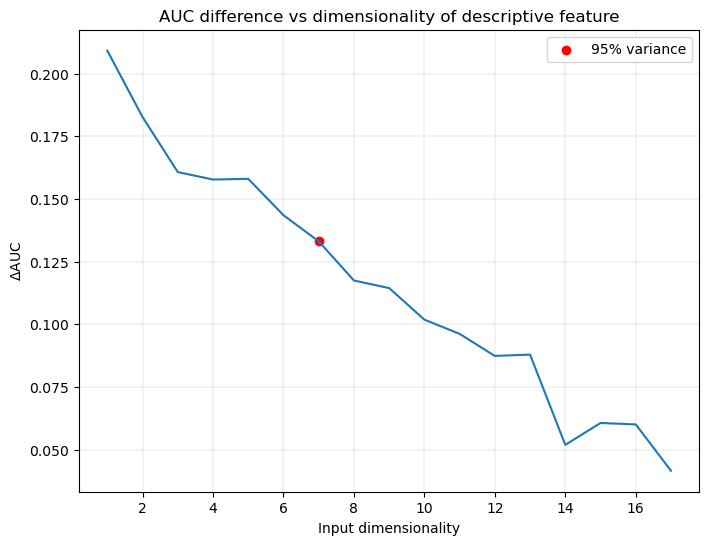

In [365]:
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.title("AUC difference vs dimensionality of descriptive feature")
plt.xlabel("Input dimensionality")
plt.ylabel("$\Delta$AUC")
plt.grid(lw = 0.2)
plt.scatter(7, auc_differences[7], color = "red", label = '95% variance')
plt.legend()
plt.plot(auc_differences.keys(), auc_differences.values())

In [260]:
# obtain 95% variance

def PCA_95(train):
    pca = PCA(n_components=0.95)
    return len(pca.fit(train).components_)

0:	test: 0.7146804	best: 0.7146804 (0)	total: 21.7ms	remaining: 2.15s
1:	test: 0.7295719	best: 0.7295719 (1)	total: 33.4ms	remaining: 1.64s
2:	test: 0.7296584	best: 0.7296584 (2)	total: 43.4ms	remaining: 1.4s
3:	test: 0.7303550	best: 0.7303550 (3)	total: 53.1ms	remaining: 1.27s
4:	test: 0.7304639	best: 0.7304639 (4)	total: 63.2ms	remaining: 1.2s
5:	test: 0.7307720	best: 0.7307720 (5)	total: 73ms	remaining: 1.14s
6:	test: 0.7302754	best: 0.7307720 (5)	total: 82.8ms	remaining: 1.1s
7:	test: 0.7317012	best: 0.7317012 (7)	total: 93.4ms	remaining: 1.07s
8:	test: 0.7313555	best: 0.7317012 (7)	total: 103ms	remaining: 1.04s
9:	test: 0.7319798	best: 0.7319798 (9)	total: 113ms	remaining: 1.02s
10:	test: 0.7322425	best: 0.7322425 (10)	total: 125ms	remaining: 1.01s
11:	test: 0.7321916	best: 0.7322425 (10)	total: 134ms	remaining: 985ms
12:	test: 0.7322883	best: 0.7322883 (12)	total: 146ms	remaining: 977ms
13:	test: 0.7321045	best: 0.7322883 (12)	total: 156ms	remaining: 960ms
14:	test: 0.7320794	bes

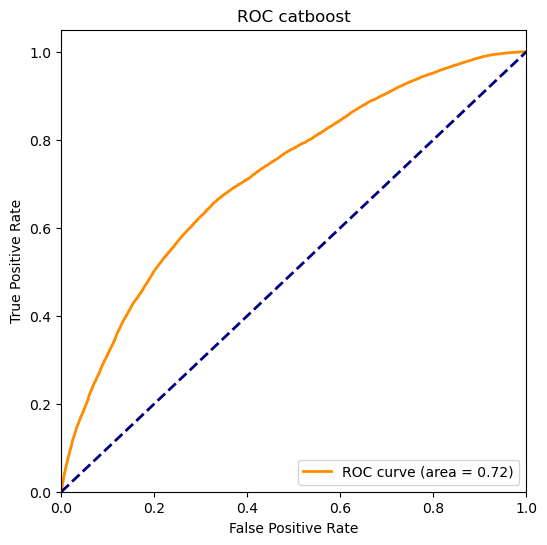

In [363]:
# ROC 
data_fnames=hdata['feature_names'].to_numpy()[1:] #labels not needed
n_dims=data_fnames.shape[0]
x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample
pool_train = Pool(data=x_train.to_numpy(),label=y_train.to_numpy(),feature_names=data_fnames.tolist())
pool_test = Pool(data=x_test.to_numpy(),label=y_test.to_numpy(),feature_names=data_fnames.tolist())
bdt =set_parameters(10, 100)# random default values
y_score=bdt.predict_proba(x_val.to_numpy())[:,1]
fake, true, _ = roc_curve(y_val,y_score)
roc_auc = auc(fake,true)
plt.figure(figsize=[6, 6])
lw=2

plt.plot(fake, true, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC catboost")
plt.legend(loc="lower right")
plt.show()

# DNN

In [276]:
# get data
hdata=dh.load_data()
data_fnames=hdata['feature_names'].to_numpy()[1:] #drop labels
n_dims=data_fnames.shape[0]
print ("Entries read {} with feature names {}".format(n_dims,data_fnames))

x_trn,y_trn=split_xy(hdata['train']) # training sample, should split a fraction for testing
x_train, x_test,y_train, y_test = train_test_split(x_trn,y_trn,test_size=0.1) # 10% split
x_val,y_val=split_xy(hdata['valid']) # independent cross-valid sample


# ready the data for TF
ds_train = tf.data.Dataset.from_tensor_slices((x_train.to_numpy(),y_train.to_numpy()))
ds_train = ds_train.repeat()
ds_train = ds_train.batch(BATCH_SIZE,drop_remainder=True)

ds_test = tf.data.Dataset.from_tensor_slices((x_test.to_numpy(),y_test.to_numpy()))
ds_test = ds_test.repeat()
ds_test = ds_test.batch(BATCH_SIZE,drop_remainder=True)

train_steps=int(x_train.shape[0]/BATCH_SIZE)
test_steps=int(x_test.shape[0]/BATCH_SIZE)

Loading /Users/tijanprijon/Code/mfpr/data/higgs-parsed/higgs-parsed.h5...
Loaded.
Entries read 18 with feature names ['lepton-pT' 'lepton-eta' 'missing-energy' 'jet_1-pt' 'jet_1-eta'
 'jet_2-pt' 'jet_2-eta' 'jet_3-pt' 'jet_3-eta' 'jet_4-pt' 'jet_4-eta'
 'm_jj' 'm_jjj' 'm_lv' 'm_jlv' 'm_bb' 'm_wbb' 'm_wwbb']


Epoch 1/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6791 - accuracy: 0.5685 - auc: 0.5984 - binary_crossentropy: 0.6791 - val_loss: 0.6627 - val_accuracy: 0.5964 - val_auc: 0.6437 - val_binary_crossentropy: 0.6627
Epoch 2/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.6082 - auc: 0.6543 - binary_crossentropy: 0.6536 - val_loss: 0.6469 - val_accuracy: 0.6177 - val_auc: 0.6639 - val_binary_crossentropy: 0.6469
Epoch 3/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6431 - accuracy: 0.6216 - auc: 0.6700 - binary_crossentropy: 0.6431 - val_loss: 0.6408 - val_accuracy: 0.6269 - val_auc: 0.6738 - val_binary_crossentropy: 0.6408
Epoch 4/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6382 - accuracy: 0.6283 - auc: 0.6785 - binary_crossentropy: 0.6382 - val_loss: 0.6371 - val_accuracy: 0.6336 - val_auc: 0.6808 - val_binary_crossentropy: 0.6371
Epoch 5/20
360/360 [============================

360/360 [==============================] - 1s 2ms/step - loss: 0.5736 - accuracy: 0.6989 - auc: 0.7682 - binary_crossentropy: 0.5736 - val_loss: 0.5716 - val_accuracy: 0.6999 - val_auc: 0.7701 - val_binary_crossentropy: 0.5716
Epoch 16/20
360/360 [==============================] - 1s 2ms/step - loss: 0.5715 - accuracy: 0.7003 - auc: 0.7702 - binary_crossentropy: 0.5715 - val_loss: 0.5696 - val_accuracy: 0.7009 - val_auc: 0.7721 - val_binary_crossentropy: 0.5696
Epoch 17/20
360/360 [==============================] - 1s 2ms/step - loss: 0.5696 - accuracy: 0.7017 - auc: 0.7720 - binary_crossentropy: 0.5696 - val_loss: 0.5678 - val_accuracy: 0.7024 - val_auc: 0.7736 - val_binary_crossentropy: 0.5678
Epoch 18/20
360/360 [==============================] - 1s 2ms/step - loss: 0.5679 - accuracy: 0.7026 - auc: 0.7736 - binary_crossentropy: 0.5679 - val_loss: 0.5661 - val_accuracy: 0.7036 - val_auc: 0.7752 - val_binary_crossentropy: 0.5661
Epoch 19/20
360/360 [==============================] - 1

360/360 [==============================] - 1s 3ms/step - loss: 0.5645 - accuracy: 0.7046 - auc: 0.7763 - binary_crossentropy: 0.5645 - val_loss: 0.5624 - val_accuracy: 0.7064 - val_auc: 0.7788 - val_binary_crossentropy: 0.5624
Epoch 10/20
360/360 [==============================] - 1s 3ms/step - loss: 0.5618 - accuracy: 0.7068 - auc: 0.7790 - binary_crossentropy: 0.5618 - val_loss: 0.5603 - val_accuracy: 0.7082 - val_auc: 0.7808 - val_binary_crossentropy: 0.5603
Epoch 11/20
360/360 [==============================] - 1s 3ms/step - loss: 0.5596 - accuracy: 0.7086 - auc: 0.7811 - binary_crossentropy: 0.5596 - val_loss: 0.5587 - val_accuracy: 0.7089 - val_auc: 0.7824 - val_binary_crossentropy: 0.5587
Epoch 12/20
360/360 [==============================] - 1s 3ms/step - loss: 0.5577 - accuracy: 0.7102 - auc: 0.7830 - binary_crossentropy: 0.5577 - val_loss: 0.5573 - val_accuracy: 0.7103 - val_auc: 0.7836 - val_binary_crossentropy: 0.5573
Epoch 13/20
360/360 [==============================] - 1

360/360 [==============================] - 1s 4ms/step - loss: 0.5957 - accuracy: 0.6788 - auc: 0.7427 - binary_crossentropy: 0.5957 - val_loss: 0.5881 - val_accuracy: 0.6813 - val_auc: 0.7524 - val_binary_crossentropy: 0.5881
Epoch 4/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5859 - accuracy: 0.6869 - auc: 0.7537 - binary_crossentropy: 0.5859 - val_loss: 0.5825 - val_accuracy: 0.6867 - val_auc: 0.7587 - val_binary_crossentropy: 0.5825
Epoch 5/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5798 - accuracy: 0.6914 - auc: 0.7602 - binary_crossentropy: 0.5798 - val_loss: 0.5750 - val_accuracy: 0.6936 - val_auc: 0.7652 - val_binary_crossentropy: 0.5750
Epoch 6/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5748 - accuracy: 0.6954 - auc: 0.7654 - binary_crossentropy: 0.5748 - val_loss: 0.5702 - val_accuracy: 0.6977 - val_auc: 0.7703 - val_binary_crossentropy: 0.5702
Epoch 7/20
360/360 [==============================] - 1s 4m

360/360 [==============================] - 1s 4ms/step - loss: 0.5478 - accuracy: 0.7164 - auc: 0.7921 - binary_crossentropy: 0.5478 - val_loss: 0.5501 - val_accuracy: 0.7149 - val_auc: 0.7909 - val_binary_crossentropy: 0.5501
Epoch 18/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5463 - accuracy: 0.7177 - auc: 0.7936 - binary_crossentropy: 0.5463 - val_loss: 0.5498 - val_accuracy: 0.7165 - val_auc: 0.7925 - val_binary_crossentropy: 0.5498
Epoch 19/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5445 - accuracy: 0.7191 - auc: 0.7952 - binary_crossentropy: 0.5445 - val_loss: 0.5471 - val_accuracy: 0.7176 - val_auc: 0.7939 - val_binary_crossentropy: 0.5471
Epoch 20/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5432 - accuracy: 0.7200 - auc: 0.7965 - binary_crossentropy: 0.5432 - val_loss: 0.5444 - val_accuracy: 0.7205 - val_auc: 0.7959 - val_binary_crossentropy: 0.5444
Epoch 1/20
360/360 [==============================] - 2s

360/360 [==============================] - 2s 5ms/step - loss: 0.5513 - accuracy: 0.7145 - auc: 0.7889 - binary_crossentropy: 0.5513 - val_loss: 0.5500 - val_accuracy: 0.7151 - val_auc: 0.7902 - val_binary_crossentropy: 0.5500
Epoch 12/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5490 - accuracy: 0.7167 - auc: 0.7912 - binary_crossentropy: 0.5490 - val_loss: 0.5507 - val_accuracy: 0.7155 - val_auc: 0.7893 - val_binary_crossentropy: 0.5507
Epoch 13/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5466 - accuracy: 0.7185 - auc: 0.7934 - binary_crossentropy: 0.5466 - val_loss: 0.5489 - val_accuracy: 0.7154 - val_auc: 0.7911 - val_binary_crossentropy: 0.5489
Epoch 14/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5453 - accuracy: 0.7191 - auc: 0.7946 - binary_crossentropy: 0.5453 - val_loss: 0.5472 - val_accuracy: 0.7167 - val_auc: 0.7931 - val_binary_crossentropy: 0.5472
Epoch 15/20
360/360 [==============================] - 2

360/360 [==============================] - 2s 6ms/step - loss: 0.5752 - accuracy: 0.6946 - auc: 0.7645 - binary_crossentropy: 0.5752 - val_loss: 0.5720 - val_accuracy: 0.6981 - val_auc: 0.7680 - val_binary_crossentropy: 0.5720
Epoch 6/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5702 - accuracy: 0.6989 - auc: 0.7699 - binary_crossentropy: 0.5702 - val_loss: 0.5699 - val_accuracy: 0.7004 - val_auc: 0.7703 - val_binary_crossentropy: 0.5699
Epoch 7/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5664 - accuracy: 0.7029 - auc: 0.7738 - binary_crossentropy: 0.5664 - val_loss: 0.5651 - val_accuracy: 0.7038 - val_auc: 0.7757 - val_binary_crossentropy: 0.5651
Epoch 8/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5624 - accuracy: 0.7059 - auc: 0.7779 - binary_crossentropy: 0.5624 - val_loss: 0.5623 - val_accuracy: 0.7060 - val_auc: 0.7782 - val_binary_crossentropy: 0.5623
Epoch 9/20
360/360 [==============================] - 2s 5m

360/360 [==============================] - 2s 6ms/step - loss: 0.5430 - accuracy: 0.7215 - auc: 0.7967 - binary_crossentropy: 0.5430 - val_loss: 0.5436 - val_accuracy: 0.7195 - val_auc: 0.7965 - val_binary_crossentropy: 0.5436
Epoch 20/20
360/360 [==============================] - 2s 5ms/step - loss: 0.5416 - accuracy: 0.7223 - auc: 0.7981 - binary_crossentropy: 0.5416 - val_loss: 0.5437 - val_accuracy: 0.7200 - val_auc: 0.7966 - val_binary_crossentropy: 0.5437
Epoch 1/20
360/360 [==============================] - 2s 6ms/step - loss: 0.6550 - accuracy: 0.6019 - auc: 0.6429 - binary_crossentropy: 0.6550 - val_loss: 0.6345 - val_accuracy: 0.6306 - val_auc: 0.6814 - val_binary_crossentropy: 0.6345
Epoch 2/20
360/360 [==============================] - 2s 6ms/step - loss: 0.6259 - accuracy: 0.6420 - auc: 0.6976 - binary_crossentropy: 0.6259 - val_loss: 0.6146 - val_accuracy: 0.6572 - val_auc: 0.7168 - val_binary_crossentropy: 0.6146
Epoch 3/20
360/360 [==============================] - 2s 6

360/360 [==============================] - 2s 7ms/step - loss: 0.5524 - accuracy: 0.7136 - auc: 0.7878 - binary_crossentropy: 0.5524 - val_loss: 0.5510 - val_accuracy: 0.7152 - val_auc: 0.7904 - val_binary_crossentropy: 0.5510
Epoch 14/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5504 - accuracy: 0.7150 - auc: 0.7897 - binary_crossentropy: 0.5504 - val_loss: 0.5484 - val_accuracy: 0.7158 - val_auc: 0.7928 - val_binary_crossentropy: 0.5484
Epoch 15/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5480 - accuracy: 0.7168 - auc: 0.7920 - binary_crossentropy: 0.5480 - val_loss: 0.5465 - val_accuracy: 0.7177 - val_auc: 0.7942 - val_binary_crossentropy: 0.5465
Epoch 16/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5460 - accuracy: 0.7183 - auc: 0.7938 - binary_crossentropy: 0.5460 - val_loss: 0.5465 - val_accuracy: 0.7173 - val_auc: 0.7951 - val_binary_crossentropy: 0.5465
Epoch 17/20
360/360 [==============================] - 2

360/360 [==============================] - 3s 7ms/step - loss: 0.5679 - accuracy: 0.7014 - auc: 0.7724 - binary_crossentropy: 0.5679 - val_loss: 0.5628 - val_accuracy: 0.7059 - val_auc: 0.7801 - val_binary_crossentropy: 0.5628
Epoch 8/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5626 - accuracy: 0.7054 - auc: 0.7779 - binary_crossentropy: 0.5626 - val_loss: 0.5605 - val_accuracy: 0.7081 - val_auc: 0.7832 - val_binary_crossentropy: 0.5605
Epoch 9/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5596 - accuracy: 0.7081 - auc: 0.7809 - binary_crossentropy: 0.5596 - val_loss: 0.5565 - val_accuracy: 0.7129 - val_auc: 0.7862 - val_binary_crossentropy: 0.5565
Epoch 10/20
360/360 [==============================] - 2s 7ms/step - loss: 0.5565 - accuracy: 0.7108 - auc: 0.7840 - binary_crossentropy: 0.5565 - val_loss: 0.5529 - val_accuracy: 0.7132 - val_auc: 0.7887 - val_binary_crossentropy: 0.5529
Epoch 11/20
360/360 [==============================] - 2s 

360/360 [==============================] - 3s 7ms/step - loss: 0.6631 - accuracy: 0.5829 - auc: 0.6215 - binary_crossentropy: 0.6631 - val_loss: 0.6325 - val_accuracy: 0.6337 - val_auc: 0.6872 - val_binary_crossentropy: 0.6325
Epoch 2/20
360/360 [==============================] - 3s 7ms/step - loss: 0.6255 - accuracy: 0.6418 - auc: 0.6985 - binary_crossentropy: 0.6255 - val_loss: 0.6153 - val_accuracy: 0.6515 - val_auc: 0.7173 - val_binary_crossentropy: 0.6153
Epoch 3/20
360/360 [==============================] - 3s 8ms/step - loss: 0.6065 - accuracy: 0.6654 - auc: 0.7279 - binary_crossentropy: 0.6065 - val_loss: 0.5948 - val_accuracy: 0.6768 - val_auc: 0.7439 - val_binary_crossentropy: 0.5948
Epoch 4/20
360/360 [==============================] - 3s 7ms/step - loss: 0.5915 - accuracy: 0.6804 - auc: 0.7467 - binary_crossentropy: 0.5915 - val_loss: 0.5849 - val_accuracy: 0.6860 - val_auc: 0.7572 - val_binary_crossentropy: 0.5849
Epoch 5/20
360/360 [==============================] - 3s 7m

360/360 [==============================] - 3s 9ms/step - loss: 0.5490 - accuracy: 0.7165 - auc: 0.7912 - binary_crossentropy: 0.5490 - val_loss: 0.5487 - val_accuracy: 0.7162 - val_auc: 0.7917 - val_binary_crossentropy: 0.5487
Epoch 16/20
360/360 [==============================] - 3s 8ms/step - loss: 0.5482 - accuracy: 0.7168 - auc: 0.7920 - binary_crossentropy: 0.5482 - val_loss: 0.5468 - val_accuracy: 0.7182 - val_auc: 0.7938 - val_binary_crossentropy: 0.5468
Epoch 17/20
360/360 [==============================] - 3s 8ms/step - loss: 0.5467 - accuracy: 0.7185 - auc: 0.7934 - binary_crossentropy: 0.5467 - val_loss: 0.5477 - val_accuracy: 0.7182 - val_auc: 0.7933 - val_binary_crossentropy: 0.5477
Epoch 18/20
360/360 [==============================] - 3s 8ms/step - loss: 0.5453 - accuracy: 0.7191 - auc: 0.7947 - binary_crossentropy: 0.5453 - val_loss: 0.5461 - val_accuracy: 0.7196 - val_auc: 0.7954 - val_binary_crossentropy: 0.5461
Epoch 19/20
360/360 [==============================] - 3

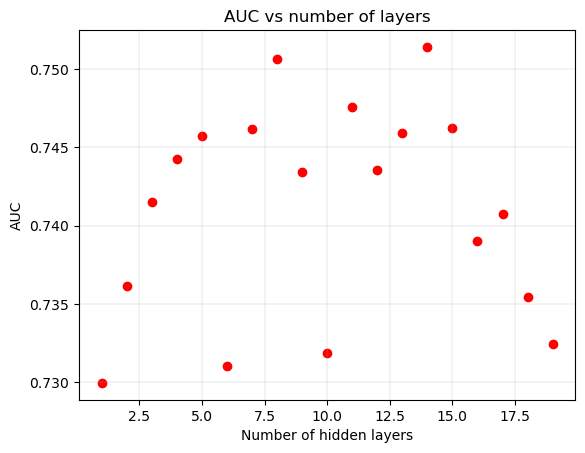

In [306]:
# number of layers
from datetime import datetime
time_complexity = dict()
nepoch = 20
auc = dict()
for n in range(1,20):
    dnn = Sequential()
    for i in range(n):
        dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    
    start = datetime.now()
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    time_complexity[n] = (datetime.now()- start).total_seconds()
    
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = AUC_score(y_val,y_score) # n + 1 output layer

plt.title("AUC vs number of layers")
plt.xlabel("Number of hidden layers")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.scatter(auc.keys(), auc.values(), color = "red")
plt.show()

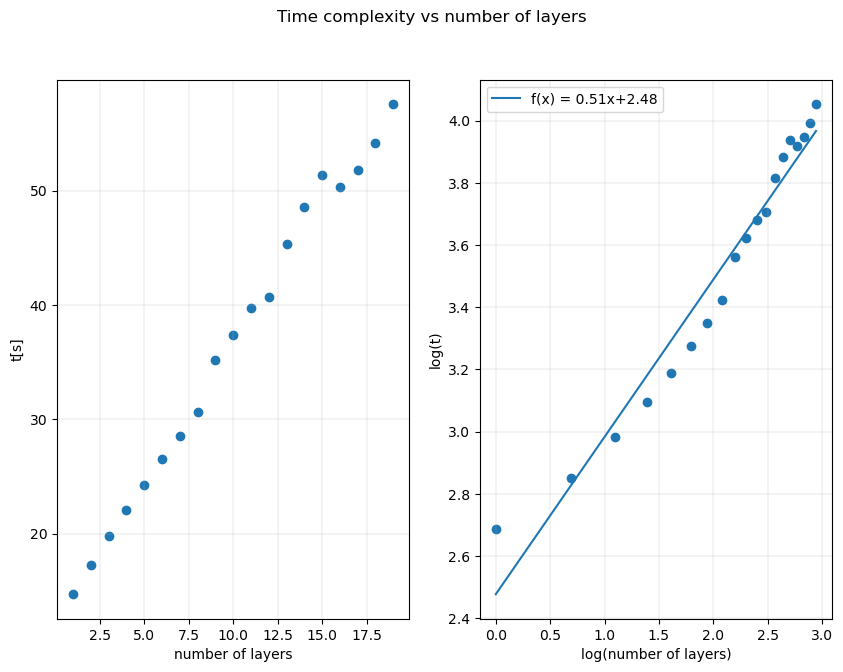

In [340]:
# plot time complexity
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a*x + b

fig, ax = plt.subplots(1,2, figsize = (10,7))
fig.suptitle("Time complexity vs number of layers")

ax[0].grid(lw = 0.2)
ax[1].grid(lw = 0.2)

ax[0].set_xlabel("number of layers")
ax[0].set_ylabel("t[s]")
ax[0].scatter(time_complexity.keys(), time_complexity.values())

log_time = [np.log(i) for i in time_complexity.values()]
x = [np.log(i) for i in time_complexity.keys()]
params, pcov = curve_fit(linear, x, log_time)
y = [linear(i, *params) for i in x]
ax[1].plot(x, y, label = f"f(x) = {params[0].round(2)}x+{params[1].round(2)}")

ax[1].set_xlabel("log(number of layers)")
ax[1].set_ylabel("log(t)")
ax[1].scatter(x, log_time)
ax[1].legend()
plt.show()

Epoch 1/10
360/360 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5286 - auc: 0.5013 - binary_crossentropy: 0.6917 - val_loss: 0.6915 - val_accuracy: 0.5283 - val_auc: 0.5000 - val_binary_crossentropy: 0.6915
Epoch 2/10
360/360 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5289 - auc: 0.5004 - binary_crossentropy: 0.6915 - val_loss: 0.6915 - val_accuracy: 0.5283 - val_auc: 0.5000 - val_binary_crossentropy: 0.6915
Epoch 3/10
360/360 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5289 - auc: 0.5004 - binary_crossentropy: 0.6915 - val_loss: 0.6915 - val_accuracy: 0.5283 - val_auc: 0.5000 - val_binary_crossentropy: 0.6915
Epoch 4/10
360/360 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5289 - auc: 0.5005 - binary_crossentropy: 0.6915 - val_loss: 0.6915 - val_accuracy: 0.5283 - val_auc: 0.5000 - val_binary_crossentropy: 0.6915
Epoch 5/10
360/360 [============================

360/360 [==============================] - 1s 3ms/step - loss: 0.5960 - accuracy: 0.6790 - auc: 0.7436 - binary_crossentropy: 0.5960 - val_loss: 0.5923 - val_accuracy: 0.6796 - val_auc: 0.7491 - val_binary_crossentropy: 0.5923
Epoch 6/10
360/360 [==============================] - 1s 3ms/step - loss: 0.5877 - accuracy: 0.6873 - auc: 0.7534 - binary_crossentropy: 0.5877 - val_loss: 0.5848 - val_accuracy: 0.6881 - val_auc: 0.7573 - val_binary_crossentropy: 0.5848
Epoch 7/10
360/360 [==============================] - 1s 3ms/step - loss: 0.5815 - accuracy: 0.6928 - auc: 0.7603 - binary_crossentropy: 0.5815 - val_loss: 0.5796 - val_accuracy: 0.6933 - val_auc: 0.7625 - val_binary_crossentropy: 0.5796
Epoch 8/10
360/360 [==============================] - 1s 3ms/step - loss: 0.5769 - accuracy: 0.6970 - auc: 0.7652 - binary_crossentropy: 0.5769 - val_loss: 0.5753 - val_accuracy: 0.6972 - val_auc: 0.7669 - val_binary_crossentropy: 0.5753
Epoch 9/10
360/360 [==============================] - 1s 3m

360/360 [==============================] - 1s 3ms/step - loss: 0.5645 - accuracy: 0.7056 - auc: 0.7771 - binary_crossentropy: 0.5645 - val_loss: 0.5617 - val_accuracy: 0.7082 - val_auc: 0.7801 - val_binary_crossentropy: 0.5617
Epoch 10/10
360/360 [==============================] - 1s 3ms/step - loss: 0.5616 - accuracy: 0.7077 - auc: 0.7798 - binary_crossentropy: 0.5616 - val_loss: 0.5589 - val_accuracy: 0.7086 - val_auc: 0.7827 - val_binary_crossentropy: 0.5589


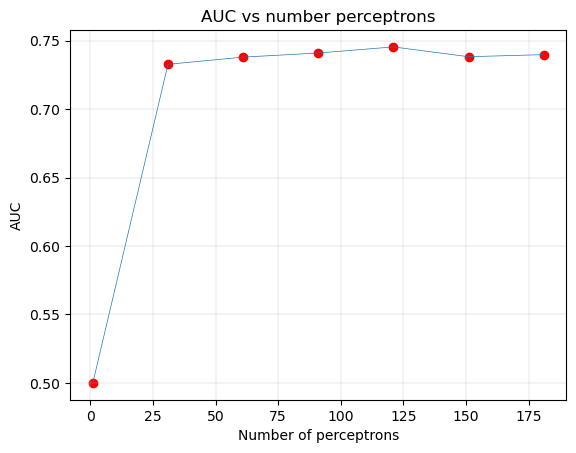

In [299]:
# number of perceptrons, 3 layers
nepoch = 10
auc = dict()
for n in range(1,200,30):
    dnn = Sequential()
    dnn.add(Dense(n, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(n, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = AUC_score(y_val,y_score) # n + 1 output layer

!matplotlib inline
plt.title("AUC vs number of perceptrons")
plt.xlabel("Number of perceptrons")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.scatter(auc.keys(), auc.values(), color = "red")
plt.plot(auc.keys(), auc.values(), lw = 0.5)
plt.show()

360/360 [==============================] - 1s 3ms/step - loss: 0.6632 - accuracy: 0.5914 - auc: 0.6274 - binary_crossentropy: 0.6632 - val_loss: 0.6427 - val_accuracy: 0.6204 - val_auc: 0.6697 - val_binary_crossentropy: 0.6427
Epoch 1/6
360/360 [==============================] - 1s 3ms/step - loss: 0.6642 - accuracy: 0.5911 - auc: 0.6258 - binary_crossentropy: 0.6642 - val_loss: 0.6447 - val_accuracy: 0.6188 - val_auc: 0.6660 - val_binary_crossentropy: 0.6447
Epoch 2/6
360/360 [==============================] - 1s 2ms/step - loss: 0.6392 - accuracy: 0.6266 - auc: 0.6749 - binary_crossentropy: 0.6392 - val_loss: 0.6362 - val_accuracy: 0.6339 - val_auc: 0.6834 - val_binary_crossentropy: 0.6362
Epoch 3/6
360/360 [==============================] - 1s 2ms/step - loss: 0.6317 - accuracy: 0.6382 - auc: 0.6891 - binary_crossentropy: 0.6317 - val_loss: 0.6311 - val_accuracy: 0.6423 - val_auc: 0.6950 - val_binary_crossentropy: 0.6311
Epoch 4/6
360/360 [==============================] - 1s 2ms/st

360/360 [==============================] - 1s 2ms/step - loss: 0.6631 - accuracy: 0.5908 - auc: 0.6294 - binary_crossentropy: 0.6631 - val_loss: 0.6430 - val_accuracy: 0.6213 - val_auc: 0.6702 - val_binary_crossentropy: 0.6430
Epoch 2/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6366 - accuracy: 0.6308 - auc: 0.6809 - binary_crossentropy: 0.6366 - val_loss: 0.6335 - val_accuracy: 0.6368 - val_auc: 0.6902 - val_binary_crossentropy: 0.6335
Epoch 3/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6267 - accuracy: 0.6447 - auc: 0.6992 - binary_crossentropy: 0.6267 - val_loss: 0.6252 - val_accuracy: 0.6506 - val_auc: 0.7070 - val_binary_crossentropy: 0.6252
Epoch 4/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6179 - accuracy: 0.6562 - auc: 0.7139 - binary_crossentropy: 0.6179 - val_loss: 0.6158 - val_accuracy: 0.6628 - val_auc: 0.7206 - val_binary_crossentropy: 0.6158
Epoch 5/21
360/360 [==============================] - 1s 2m

360/360 [==============================] - 1s 2ms/step - loss: 0.5761 - accuracy: 0.6969 - auc: 0.7662 - binary_crossentropy: 0.5761 - val_loss: 0.5745 - val_accuracy: 0.6977 - val_auc: 0.7683 - val_binary_crossentropy: 0.5745
Epoch 15/26
360/360 [==============================] - 1s 2ms/step - loss: 0.5740 - accuracy: 0.6985 - auc: 0.7683 - binary_crossentropy: 0.5740 - val_loss: 0.5724 - val_accuracy: 0.6997 - val_auc: 0.7705 - val_binary_crossentropy: 0.5724
Epoch 16/26
360/360 [==============================] - 1s 2ms/step - loss: 0.5722 - accuracy: 0.6999 - auc: 0.7702 - binary_crossentropy: 0.5722 - val_loss: 0.5704 - val_accuracy: 0.7016 - val_auc: 0.7724 - val_binary_crossentropy: 0.5704
Epoch 17/26
360/360 [==============================] - 1s 2ms/step - loss: 0.5705 - accuracy: 0.7013 - auc: 0.7718 - binary_crossentropy: 0.5705 - val_loss: 0.5688 - val_accuracy: 0.7024 - val_auc: 0.7740 - val_binary_crossentropy: 0.5688
Epoch 18/26
360/360 [==============================] - 1

360/360 [==============================] - 1s 2ms/step - loss: 0.5650 - accuracy: 0.7042 - auc: 0.7760 - binary_crossentropy: 0.5650 - val_loss: 0.5672 - val_accuracy: 0.7014 - val_auc: 0.7736 - val_binary_crossentropy: 0.5672
Epoch 23/31
360/360 [==============================] - 1s 2ms/step - loss: 0.5641 - accuracy: 0.7048 - auc: 0.7768 - binary_crossentropy: 0.5641 - val_loss: 0.5664 - val_accuracy: 0.7023 - val_auc: 0.7744 - val_binary_crossentropy: 0.5664
Epoch 24/31
360/360 [==============================] - 1s 2ms/step - loss: 0.5632 - accuracy: 0.7056 - auc: 0.7777 - binary_crossentropy: 0.5632 - val_loss: 0.5659 - val_accuracy: 0.7025 - val_auc: 0.7748 - val_binary_crossentropy: 0.5659
Epoch 25/31
360/360 [==============================] - 1s 2ms/step - loss: 0.5624 - accuracy: 0.7061 - auc: 0.7785 - binary_crossentropy: 0.5624 - val_loss: 0.5648 - val_accuracy: 0.7031 - val_auc: 0.7758 - val_binary_crossentropy: 0.5648
Epoch 26/31
360/360 [==============================] - 1

360/360 [==============================] - 1s 2ms/step - loss: 0.5596 - accuracy: 0.7089 - auc: 0.7818 - binary_crossentropy: 0.5596 - val_loss: 0.5579 - val_accuracy: 0.7088 - val_auc: 0.7834 - val_binary_crossentropy: 0.5579
Epoch 26/36
360/360 [==============================] - 1s 2ms/step - loss: 0.5588 - accuracy: 0.7097 - auc: 0.7826 - binary_crossentropy: 0.5588 - val_loss: 0.5570 - val_accuracy: 0.7097 - val_auc: 0.7843 - val_binary_crossentropy: 0.5570
Epoch 27/36
360/360 [==============================] - 1s 2ms/step - loss: 0.5579 - accuracy: 0.7102 - auc: 0.7834 - binary_crossentropy: 0.5579 - val_loss: 0.5563 - val_accuracy: 0.7099 - val_auc: 0.7849 - val_binary_crossentropy: 0.5563
Epoch 28/36
360/360 [==============================] - 1s 2ms/step - loss: 0.5571 - accuracy: 0.7108 - auc: 0.7842 - binary_crossentropy: 0.5571 - val_loss: 0.5555 - val_accuracy: 0.7110 - val_auc: 0.7856 - val_binary_crossentropy: 0.5555
Epoch 29/36
360/360 [==============================] - 1

360/360 [==============================] - 1s 2ms/step - loss: 0.5627 - accuracy: 0.7069 - auc: 0.7791 - binary_crossentropy: 0.5627 - val_loss: 0.5609 - val_accuracy: 0.7089 - val_auc: 0.7811 - val_binary_crossentropy: 0.5609
Epoch 24/41
360/360 [==============================] - 1s 2ms/step - loss: 0.5619 - accuracy: 0.7075 - auc: 0.7799 - binary_crossentropy: 0.5619 - val_loss: 0.5601 - val_accuracy: 0.7104 - val_auc: 0.7819 - val_binary_crossentropy: 0.5601
Epoch 25/41
360/360 [==============================] - 1s 2ms/step - loss: 0.5610 - accuracy: 0.7082 - auc: 0.7807 - binary_crossentropy: 0.5610 - val_loss: 0.5591 - val_accuracy: 0.7102 - val_auc: 0.7827 - val_binary_crossentropy: 0.5591
Epoch 26/41
360/360 [==============================] - 1s 2ms/step - loss: 0.5602 - accuracy: 0.7087 - auc: 0.7814 - binary_crossentropy: 0.5602 - val_loss: 0.5583 - val_accuracy: 0.7108 - val_auc: 0.7835 - val_binary_crossentropy: 0.5583
Epoch 27/41
360/360 [==============================] - 1

360/360 [==============================] - 1s 2ms/step - loss: 0.5694 - accuracy: 0.7010 - auc: 0.7723 - binary_crossentropy: 0.5694 - val_loss: 0.5689 - val_accuracy: 0.7028 - val_auc: 0.7730 - val_binary_crossentropy: 0.5689
Epoch 17/46
360/360 [==============================] - 1s 2ms/step - loss: 0.5677 - accuracy: 0.7024 - auc: 0.7740 - binary_crossentropy: 0.5677 - val_loss: 0.5673 - val_accuracy: 0.7031 - val_auc: 0.7746 - val_binary_crossentropy: 0.5673
Epoch 18/46
360/360 [==============================] - 1s 2ms/step - loss: 0.5662 - accuracy: 0.7035 - auc: 0.7755 - binary_crossentropy: 0.5662 - val_loss: 0.5659 - val_accuracy: 0.7053 - val_auc: 0.7759 - val_binary_crossentropy: 0.5659
Epoch 19/46
360/360 [==============================] - 1s 2ms/step - loss: 0.5649 - accuracy: 0.7048 - auc: 0.7768 - binary_crossentropy: 0.5649 - val_loss: 0.5645 - val_accuracy: 0.7064 - val_auc: 0.7774 - val_binary_crossentropy: 0.5645
Epoch 20/46
360/360 [==============================] - 1

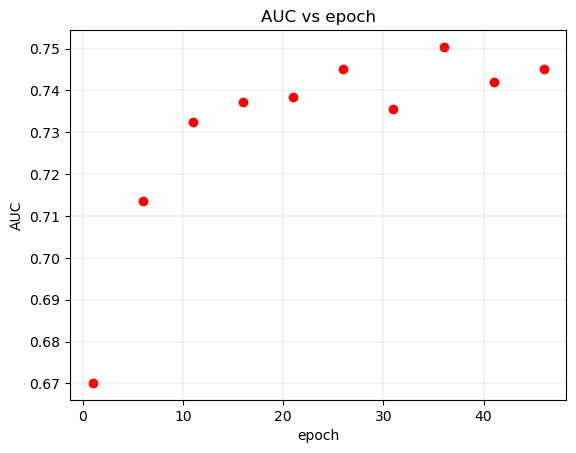

In [301]:
# epoch

nepoch = 10
auc = dict()
for n in range(1,50,5):
    nepoch = n
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = AUC_score(y_val,y_score) # n + 1 output layer

plt.title("AUC vs epoch")
plt.xlabel("epoch")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.scatter(auc.keys(), auc.values(), color = "red")
plt.show()

Epoch 1/15
360/360 [==============================] - 2s 4ms/step - loss: 0.6526 - accuracy: 0.6072 - auc: 0.6484 - binary_crossentropy: 0.6526 - val_loss: 0.6346 - val_accuracy: 0.6344 - val_auc: 0.6837 - val_binary_crossentropy: 0.6346
Epoch 2/15
360/360 [==============================] - 1s 4ms/step - loss: 0.6258 - accuracy: 0.6462 - auc: 0.6996 - binary_crossentropy: 0.6258 - val_loss: 0.6170 - val_accuracy: 0.6587 - val_auc: 0.7159 - val_binary_crossentropy: 0.6170
Epoch 3/15
360/360 [==============================] - 1s 4ms/step - loss: 0.6119 - accuracy: 0.6631 - auc: 0.7214 - binary_crossentropy: 0.6119 - val_loss: 0.6077 - val_accuracy: 0.6665 - val_auc: 0.7322 - val_binary_crossentropy: 0.6077
Epoch 4/15
360/360 [==============================] - 1s 4ms/step - loss: 0.5976 - accuracy: 0.6771 - auc: 0.7402 - binary_crossentropy: 0.5976 - val_loss: 0.5934 - val_accuracy: 0.6785 - val_auc: 0.7481 - val_binary_crossentropy: 0.5934
Epoch 5/15
360/360 [============================

360/360 [==============================] - 1s 4ms/step - loss: 0.5892 - accuracy: 0.6834 - auc: 0.7494 - binary_crossentropy: 0.5892 - val_loss: 0.5851 - val_accuracy: 0.6868 - val_auc: 0.7546 - val_binary_crossentropy: 0.5851
Epoch 5/17
360/360 [==============================] - 1s 4ms/step - loss: 0.5805 - accuracy: 0.6905 - auc: 0.7592 - binary_crossentropy: 0.5805 - val_loss: 0.5749 - val_accuracy: 0.6958 - val_auc: 0.7655 - val_binary_crossentropy: 0.5749
Epoch 6/17
360/360 [==============================] - 1s 4ms/step - loss: 0.5747 - accuracy: 0.6951 - auc: 0.7654 - binary_crossentropy: 0.5747 - val_loss: 0.5699 - val_accuracy: 0.6985 - val_auc: 0.7707 - val_binary_crossentropy: 0.5699
Epoch 7/17
360/360 [==============================] - 1s 4ms/step - loss: 0.5706 - accuracy: 0.6985 - auc: 0.7696 - binary_crossentropy: 0.5706 - val_loss: 0.5675 - val_accuracy: 0.7005 - val_auc: 0.7742 - val_binary_crossentropy: 0.5675
Epoch 8/17
360/360 [==============================] - 1s 4m

360/360 [==============================] - 1s 4ms/step - loss: 0.6081 - accuracy: 0.6679 - auc: 0.7269 - binary_crossentropy: 0.6081 - val_loss: 0.5976 - val_accuracy: 0.6772 - val_auc: 0.7411 - val_binary_crossentropy: 0.5976
Epoch 4/19
360/360 [==============================] - 1s 4ms/step - loss: 0.5924 - accuracy: 0.6826 - auc: 0.7462 - binary_crossentropy: 0.5924 - val_loss: 0.5847 - val_accuracy: 0.6866 - val_auc: 0.7555 - val_binary_crossentropy: 0.5847
Epoch 5/19
360/360 [==============================] - 1s 4ms/step - loss: 0.5816 - accuracy: 0.6909 - auc: 0.7581 - binary_crossentropy: 0.5816 - val_loss: 0.5745 - val_accuracy: 0.6935 - val_auc: 0.7659 - val_binary_crossentropy: 0.5745
Epoch 6/19
360/360 [==============================] - 1s 4ms/step - loss: 0.5744 - accuracy: 0.6959 - auc: 0.7659 - binary_crossentropy: 0.5744 - val_loss: 0.5704 - val_accuracy: 0.6978 - val_auc: 0.7699 - val_binary_crossentropy: 0.5704
Epoch 7/19
360/360 [==============================] - 1s 4m

360/360 [==============================] - 1s 4ms/step - loss: 0.5429 - accuracy: 0.7207 - auc: 0.7968 - binary_crossentropy: 0.5429 - val_loss: 0.5443 - val_accuracy: 0.7196 - val_auc: 0.7956 - val_binary_crossentropy: 0.5443
Epoch 19/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5420 - accuracy: 0.7211 - auc: 0.7976 - binary_crossentropy: 0.5420 - val_loss: 0.5432 - val_accuracy: 0.7205 - val_auc: 0.7967 - val_binary_crossentropy: 0.5432
Epoch 20/20
360/360 [==============================] - 1s 4ms/step - loss: 0.5408 - accuracy: 0.7219 - auc: 0.7987 - binary_crossentropy: 0.5408 - val_loss: 0.5423 - val_accuracy: 0.7217 - val_auc: 0.7975 - val_binary_crossentropy: 0.5423
Epoch 1/21
360/360 [==============================] - 2s 4ms/step - loss: 0.6491 - accuracy: 0.6093 - auc: 0.6558 - binary_crossentropy: 0.6491 - val_loss: 0.6229 - val_accuracy: 0.6464 - val_auc: 0.7092 - val_binary_crossentropy: 0.6229
Epoch 2/21
360/360 [==============================] - 1s 

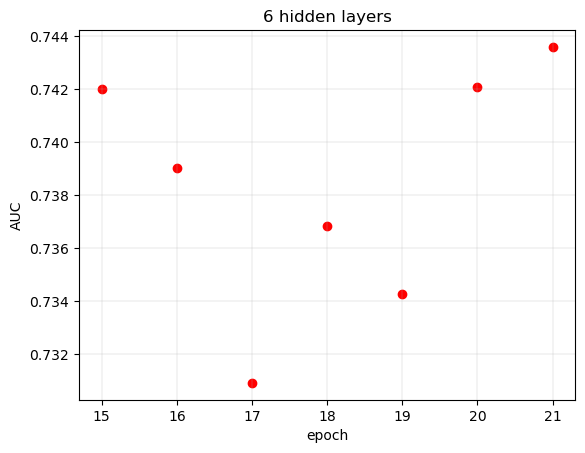

In [348]:
# 8 hidden layers; improve performance
auc = dict()
for n in range(15,22,1):
    nepoch = n
    dnn = Sequential()
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
    dnn.add(Dense(1, activation='sigmoid')) # output layer/value
    dnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', 'binary_crossentropy'])
    eval_metric = 'AUC'
    earlystop_callback = EarlyStopping(
        mode='max',
        monitor='val_' + eval_metric,
        patience=5,
        min_delta=0.00001,
        verbose=1
    )
    start = datetime.now()
    dnn.fit(ds_train,
        epochs=nepoch,
        steps_per_epoch=train_steps,
        #callbacks=[earlystop_callback],
        validation_data=ds_test,
        validation_steps=test_steps
    )
    y_score=dnn.predict(x_val.to_numpy())[:,0]
    auc[n] = AUC_score(y_val,y_score) # n + 1 output layer
plt.title("6 hidden layers")
plt.xlabel("epoch")
plt.ylabel("AUC")
plt.grid(lw = 0.2)
plt.scatter(auc.keys(), auc.values(), color = "red")
plt.show()

Epoch 1/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6640 - accuracy: 0.5889 - auc: 0.6259 - binary_crossentropy: 0.6640 - val_loss: 0.6431 - val_accuracy: 0.6204 - val_auc: 0.6701 - val_binary_crossentropy: 0.6431
Epoch 2/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6371 - accuracy: 0.6295 - auc: 0.6797 - binary_crossentropy: 0.6371 - val_loss: 0.6343 - val_accuracy: 0.6346 - val_auc: 0.6880 - val_binary_crossentropy: 0.6343
Epoch 3/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6288 - accuracy: 0.6417 - auc: 0.6953 - binary_crossentropy: 0.6288 - val_loss: 0.6284 - val_accuracy: 0.6450 - val_auc: 0.7017 - val_binary_crossentropy: 0.6284
Epoch 4/21
360/360 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6511 - auc: 0.7070 - binary_crossentropy: 0.6220 - val_loss: 0.6217 - val_accuracy: 0.6559 - val_auc: 0.7124 - val_binary_crossentropy: 0.6217
Epoch 5/21
360/360 [============================

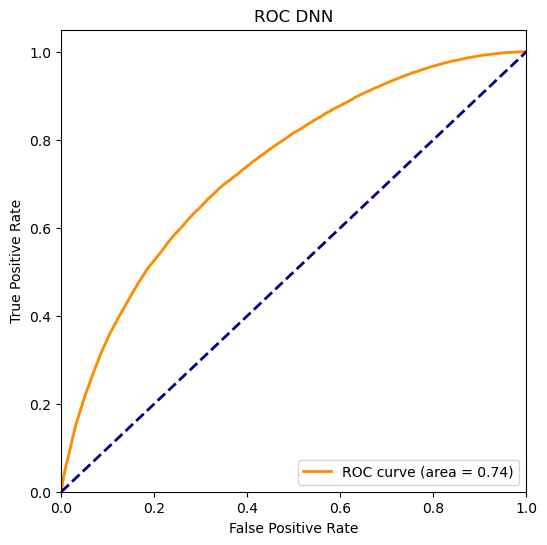

In [362]:
# plot roc
dnn = Sequential()
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(50, input_dim=n_dims, activation='relu'))
dnn.add(Dense(1, activation='sigmoid')) # output layer/value
dnn.compile(optimizer=tf.keras.optimizers.Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'binary_crossentropy'])
eval_metric = 'AUC'
earlystop_callback = EarlyStopping(
    mode='max',
    monitor='val_' + eval_metric,
    patience=5,
    min_delta=0.00001,
    verbose=1
)
dnn.fit(ds_train,
    epochs=nepoch,
    steps_per_epoch=train_steps,
    #callbacks=[earlystop_callback],
    validation_data=ds_test,
    validation_steps=test_steps
)
y_score=dnn.predict(x_val.to_numpy())[:,0]
# plot ROC
from sklearn.metrics import roc_auc_score,roc_curve,auc
fake, true, _ = roc_curve(y_val,y_score)
roc_auc = auc(fake,true)
plt.figure(figsize=[6, 6])
lw=2

plt.plot(fake, true, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC DNN")
plt.legend(loc="lower right")
plt.show()